In [1]:
import cv2
import cv2 as cv
import imutils
import os
from os import path
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import torchvision.transforms.functional as F

# Add code to sys.path
import matplotlib.pyplot as plt 

import sys
sys.path.append('../src')

from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import cv2 as cv
import collections

import dla.src.table_structure_analysis as tsa
import dla.src.xml_utils as xml_utils
from dla.src.image_utils import put_box, put_line
import pytesseract
import numpy as np

from statistics import mean

import importlib
import glosat_utils

from glosat_utils import *

[2023-01-09 11:16:51] Model res_unet18 initialisated with norm_layer=InstanceNorm2d({'momentum': 0.1, 'affine': True, 'track_running_stats': False}) and kwargs {'encoder_name': 'resnet18', 'reduced_layers': False, 'no_maxpool': False, 'conv_as_maxpool': True, 'use_deconv': True, 'use_upcatconv': False, 'use_conv1x1': False, 'pretrained_encoder': False}


In [2]:
config_file = '/data/glosat/glosat_table_dataset/dla/config/cascadeRCNN.py'
table_checkpoint_file = '/data/glosat/glosat_table_dataset/models/model_tables_enchanced_GloSAT.pth'

model = init_detector(config_file, table_checkpoint_file, device='cuda:0')

CLASSES = ("table_body","cell","full_table","header","heading")
color = 255


/data/glosat/glosat_table_dataset/mmdetection/mmdet/apis/inference.py:40: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [3]:
directory = '/data/glosat/Appen/Annotation/to_annotate'
outdirectory = '/data/glosat/Appen/Annotation/to_annotate_table_boundary'

In [4]:
files = os.listdir(directory)
files

['124.jpg',
 '259.jpg',
 '153.jpg',
 '359.jpg',
 '322.jpg',
 '13.jpg',
 '3.jpg',
 '309.jpg',
 '491.jpg',
 '263.jpg',
 '100.jpg',
 '429.jpg',
 '444.jpg',
 '62.jpg',
 '298.jpg',
 '42.jpg',
 '106.jpg',
 '331.jpg',
 '457.jpg',
 '295.jpg',
 '113.jpg',
 '61.jpg',
 '119.jpg',
 '272.jpg',
 '422.jpg',
 '289.jpg',
 '414.jpg',
 '434.jpg',
 '374.jpg',
 '155.jpg',
 '310.jpg',
 '351.jpg',
 '50.jpg',
 '159.jpg',
 '297.jpg',
 '268.jpg',
 '29.jpg',
 '474.jpg',
 '125.jpg',
 '65.jpg',
 '273.jpg',
 '70.jpg',
 '455.jpg',
 '421.jpg',
 '73.jpg',
 '431.jpg',
 '487.jpg',
 '307.jpg',
 '58.jpg',
 '76.jpg',
 '293.jpg',
 '329.jpg',
 '63.jpg',
 '423.jpg',
 '486.jpg',
 '442.jpg',
 '364.jpg',
 '137.jpg',
 '313.jpg',
 '111.jpg',
 '157.jpg',
 '420.jpg',
 '112.jpg',
 '424.jpg',
 '392.jpg',
 '386.jpg',
 '146.jpg',
 '320.jpg',
 '482.jpg',
 '323.jpg',
 '350.jpg',
 '103.jpg',
 '461.jpg',
 '81.jpg',
 '349.jpg',
 '261.jpg',
 '53.jpg',
 '26.jpg',
 '400.jpg',
 '114.jpg',
 '117.jpg',
 '283.jpg',
 '255.jpg',
 '469.jpg',
 '378.jpg

In [5]:
filename = '3'

In [6]:
filename = filename.replace('.jpg', '')
if not os.path.exists(outdirectory):
    os.mkdir(outdirectory)
if not os.path.exists(outdirectory+'/XML-VOC'):
    os.mkdir(outdirectory+'/XML-VOC')

### Preprocessing

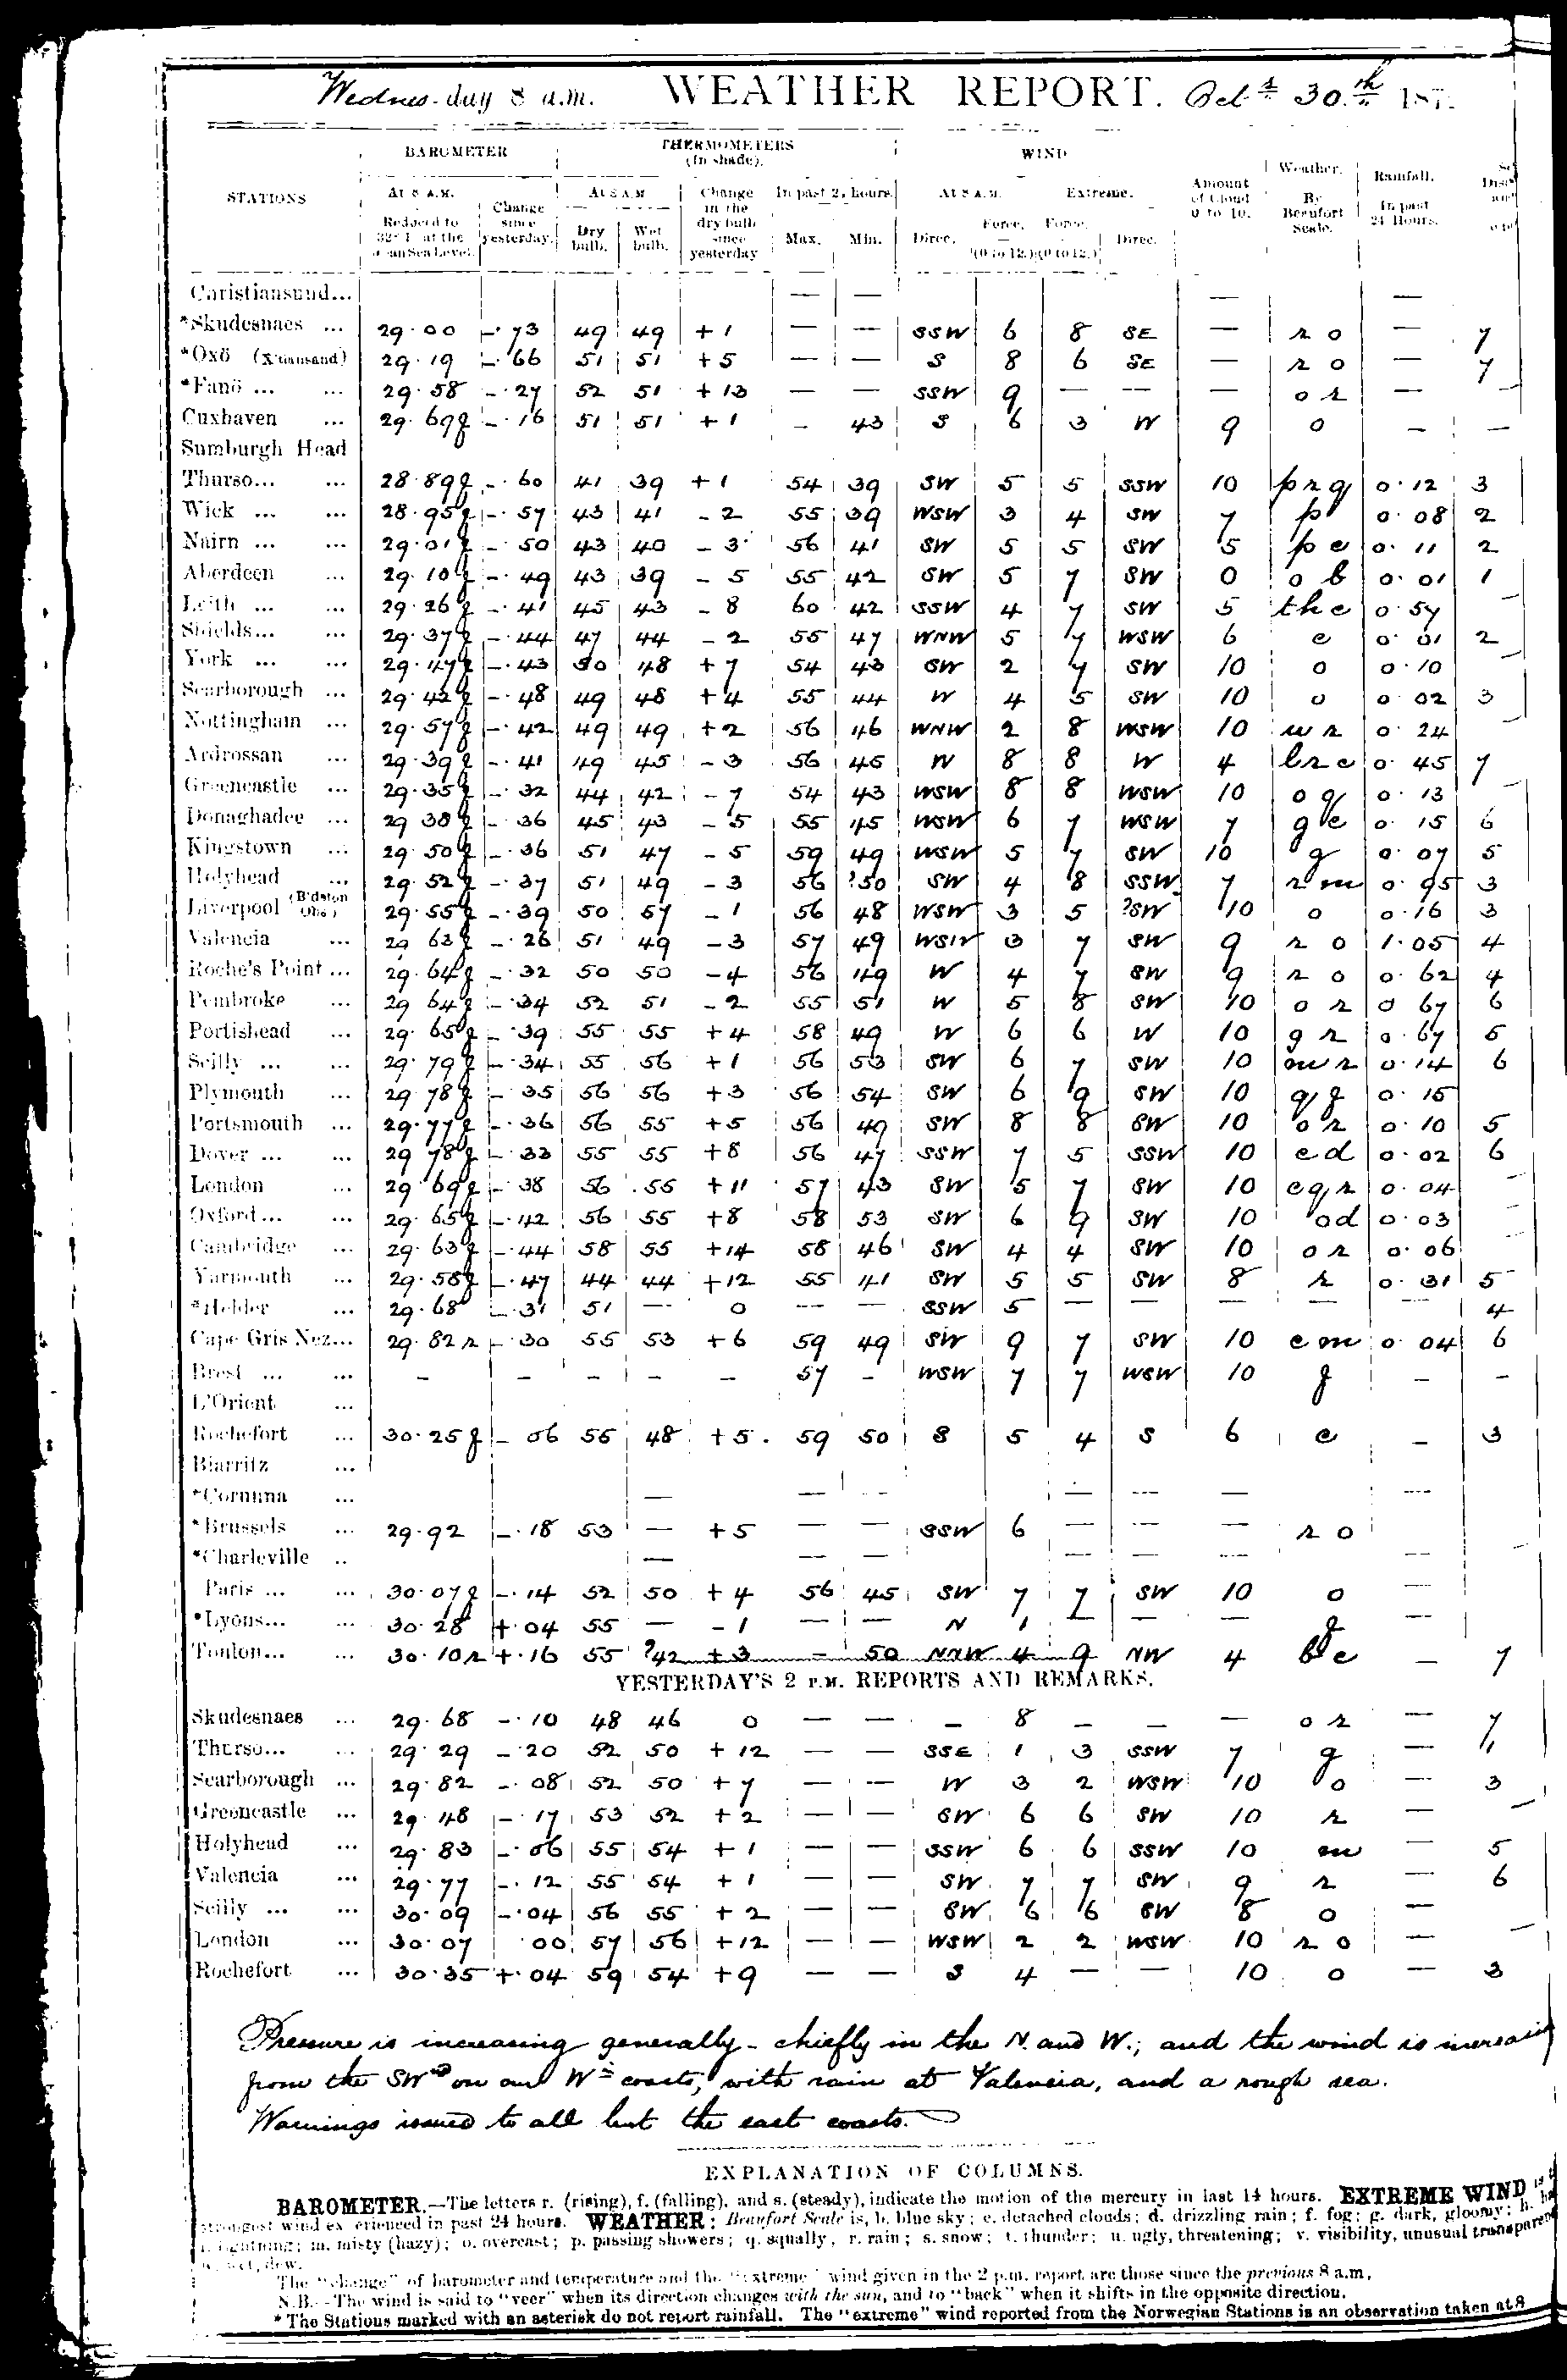

In [7]:
img_path = f'{directory}/{filename}.jpg'

img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255

im_pil = Image.fromarray(image)
im_pil  

### Detect tables and cells

In [8]:
full_tables, tables = detect_table_region(model,img)

/home/gyanendro/.local/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [11]:
result = inference_detector(model, img)

In [12]:
#Process table headings
headings = []
for box in result[CLASSES.index("heading")]:
    if box[4]>THRESHOLD :
        headings.append(box[0:4])

#Process table headers
headers = []
for box in result[CLASSES.index("header")]:
    if box[4]>THRESHOLD :
        headers.append(box[0:4])

#Process table bodies
tables = []
for box in result[CLASSES.index("table_body")]:
    if box[4]>THRESHOLD :
        tables.append(box[0:4])

#Process tables
full_tables = []
for box in result[CLASSES.index("full_table")]:
    if box[4]>THRESHOLD :
        full_tables.append(box[0:4])

        if all(tsa.how_much_contained(table,box)<0.5 for table in tables):
            tables.append(box[0:4])

for table in tables:
    if all(tsa.how_much_contained(table,full_table)<0.5 for full_table in full_tables):
        full_tables.append(table)


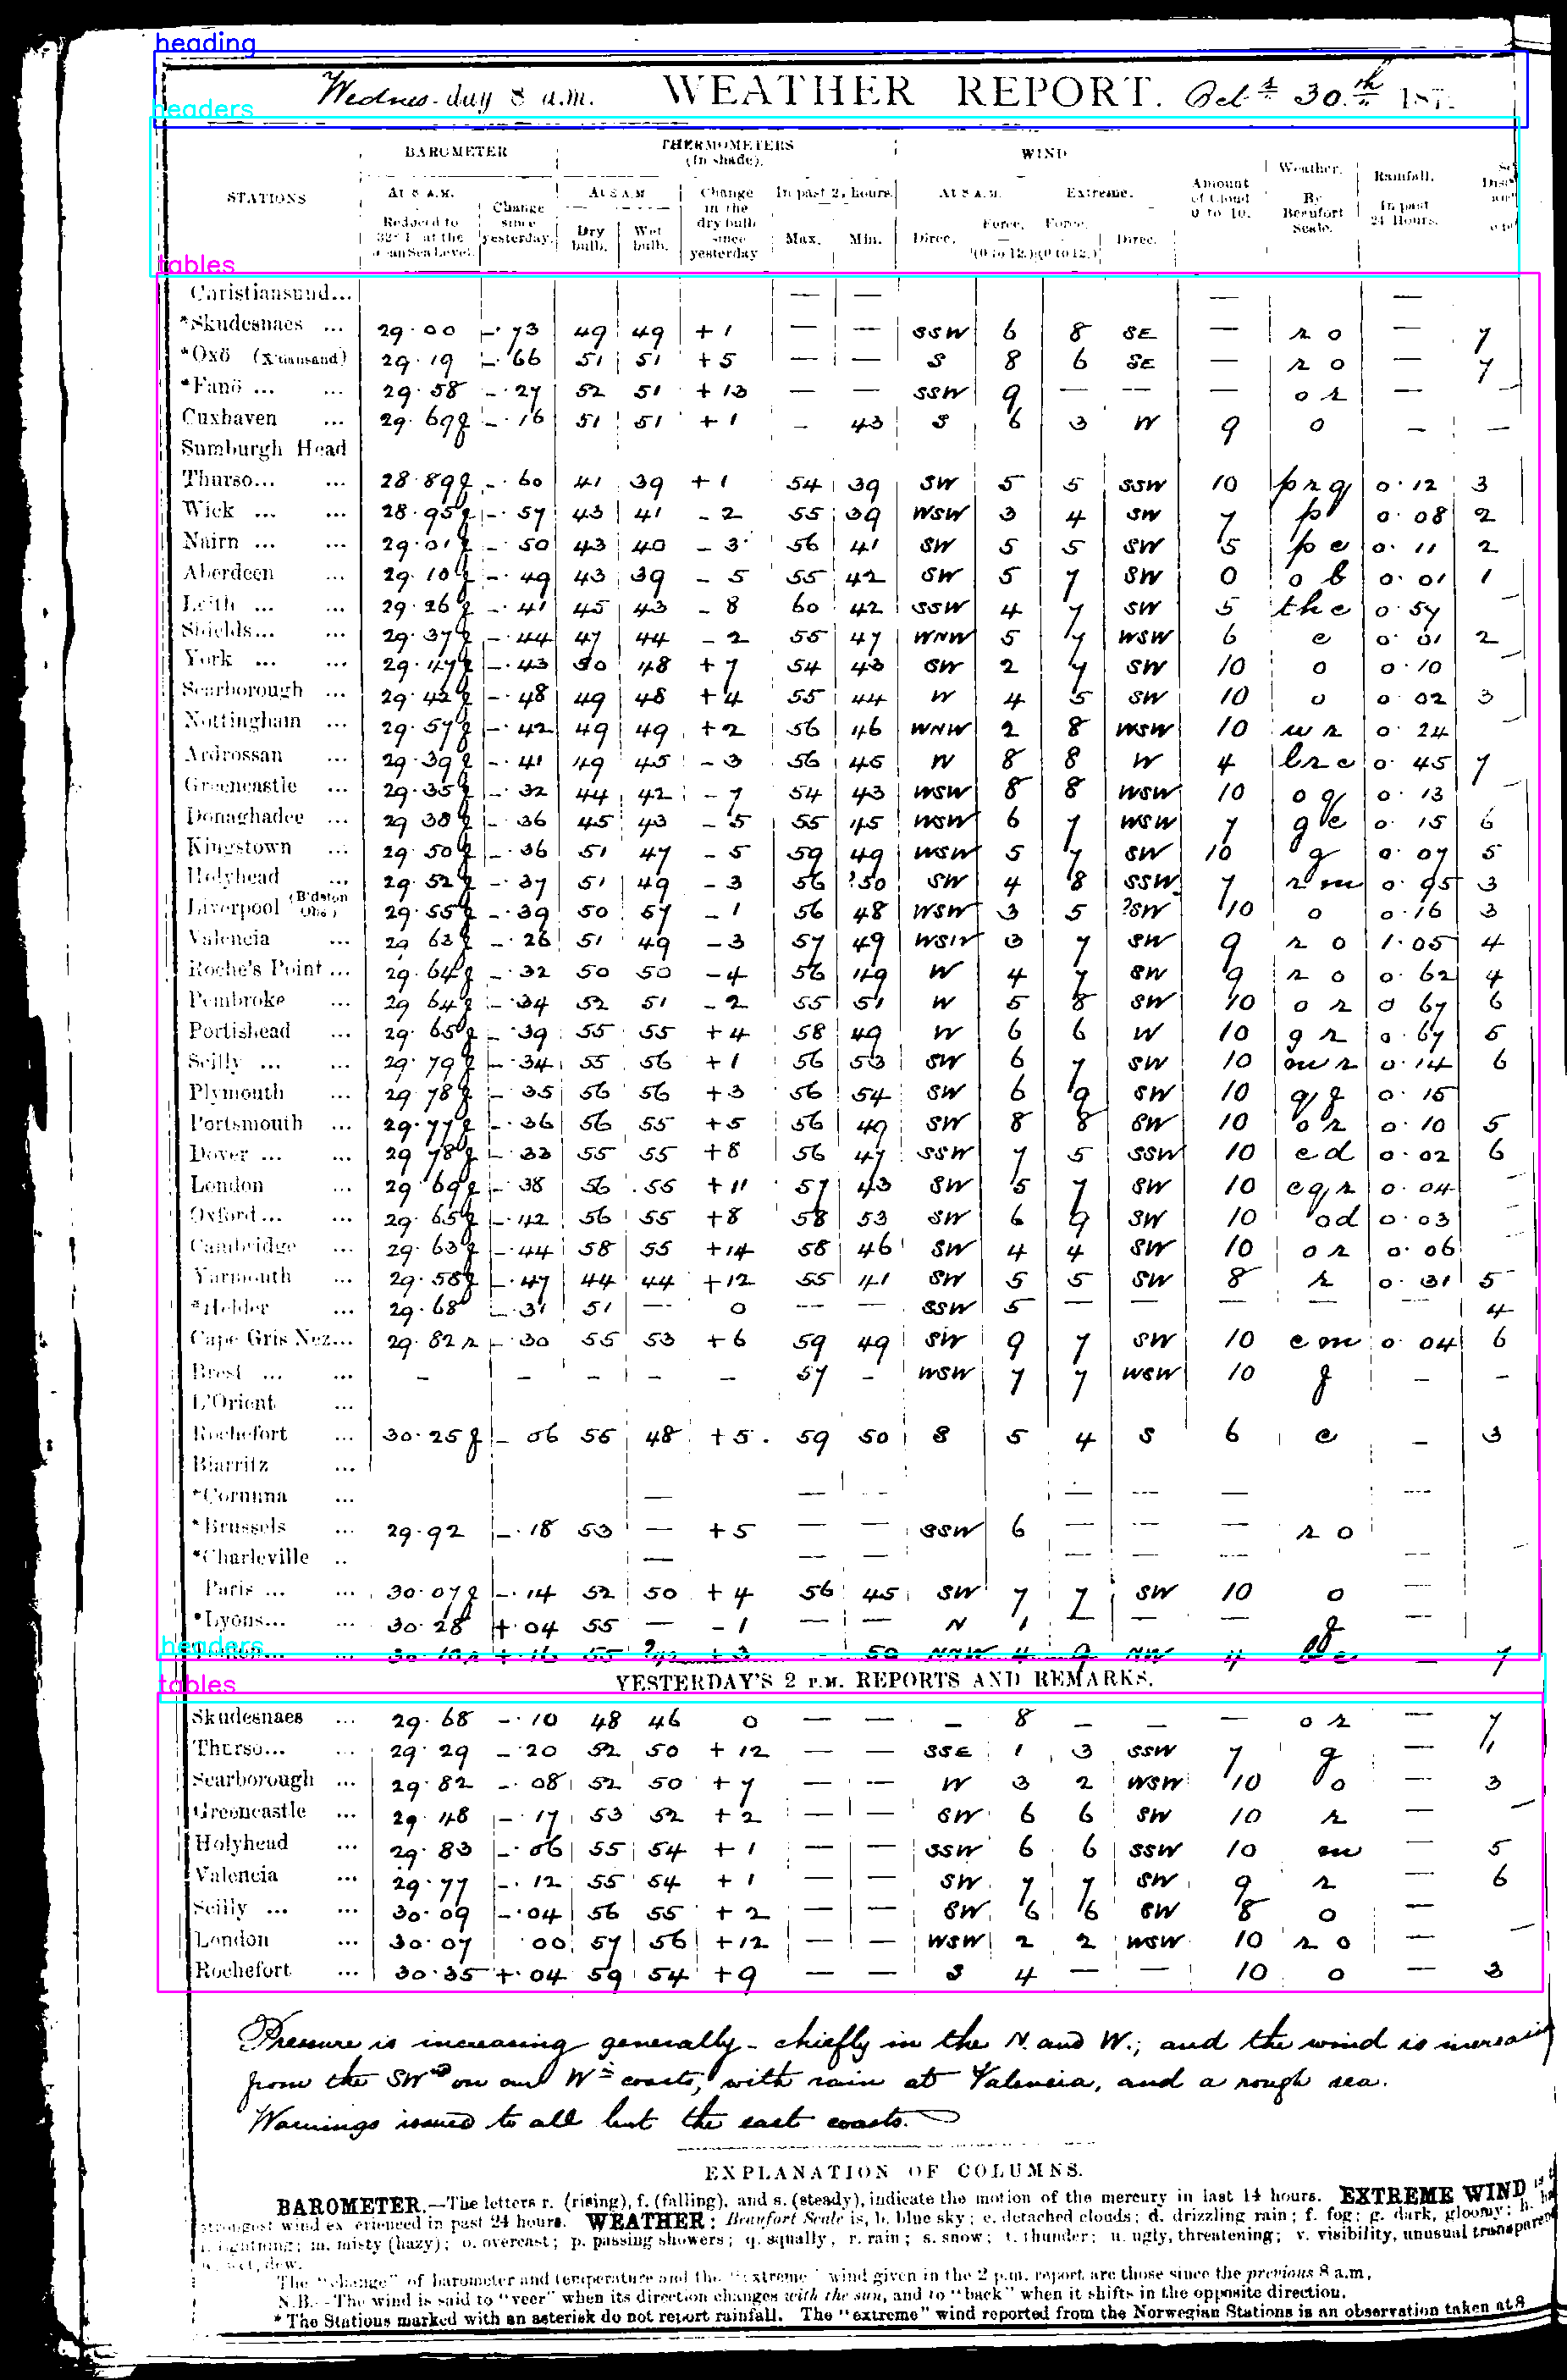

In [14]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for count,box in enumerate(headings):
    box = list(map(int, box[0:4]))
    box = box[0:4]+np.asarray([-5,-5,5,5])
#     image, height, width, _ = image_preprocessing(img)
    put_box(image,box,(0,0,color),"heading") # Cyan 
    
#     im_pil.save(f"{outdirectory}/{filename}-{count}.jpg")

#     xml_utils.save_VOC_xml_from_cells([],[],tables,tables,possible_cells,f"{outdirectory}/XML/{filename}.xml",width,height)

for count,box in enumerate(headers):
    box = list(map(int, box[0:4]))
    box = box[0:4]+np.asarray([-5,-5,5,5])
#     image, height, width, _ = image_preprocessing(img)
    put_box(image,box,(0,color,color),"headers") # Cyan 
    
for count,box in enumerate(tables):
    box = list(map(int, box[0:4]))
    box = box[0:4]+np.asarray([-5,-5,5,5])
#     image, height, width, _ = image_preprocessing(img)
    put_box(image,box,(color,0,color),"tables") # Cyan # for box in list(exclude_cells):
#     put_box(image,box,(0,0,color)) # Blue

im_pil = Image.fromarray(image)
im_pil  

### Save table boundary images

In [34]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for count,box in enumerate(tables):
    box = list(map(int, box[0:4]))
    box = box[0:4]+np.asarray([-5,-5,5,5])
    image, height, width, _ = image_preprocessing(img)
    put_box(image,box,(0,color,color)) # Cyan   
    im_pil.save(f"{outdirectory}/{filename}-{count}.jpg")
#     xml_utils.save_ICDAR_xml( full_tables, [], [], f"{outdirectory}/XML/{filename}-{count}.xml" )
    xml_utils.save_VOC_xml_from_cells([],[],[box],[box],[],f"{outdirectory}/XML-VOC/{filename}-{count}.xml",width,height)
    


### Get cell coordinates and average cell size

In [36]:
table_cells = get_x_y_initial(tables, cells_by_image[filename]+coarse_cells_by_image[filename], THRESHOLD)
cell_cordinates, average_cordinates = get_coordinates(table_cells,0.7)

In [37]:
# Average table cell in a page if multiple table exists 
x_avg = []
y_avg = []
for xa,ya in average_cordinates:
    x_avg.append(xa)
    y_avg.append(ya)

average_cordinates.append((mean(x_avg),mean(y_avg)))

new_ori_correct_cells = []
for cell in ori_correct_cells:
    idx, score = get_table_coord_initial(cell, tables)
    if score>0.5:
        cell[4] = idx
        cell = list(map(int, cell))
        new_cell = cell[0:4]
        #new_cell, changed = correct_boundary_single_cell(cell, masks[1], tables[idx], average_cordinates[-1], 0.7)
    if type(idx)!= list:
        new_ori_correct_cells.append(new_cell+[idx])

ori_correct_cells =  list(new_ori_correct_cells)

In [38]:
filter_ori_correct_cells =filter_overlapped_cell(ori_correct_cells, average_cordinates)

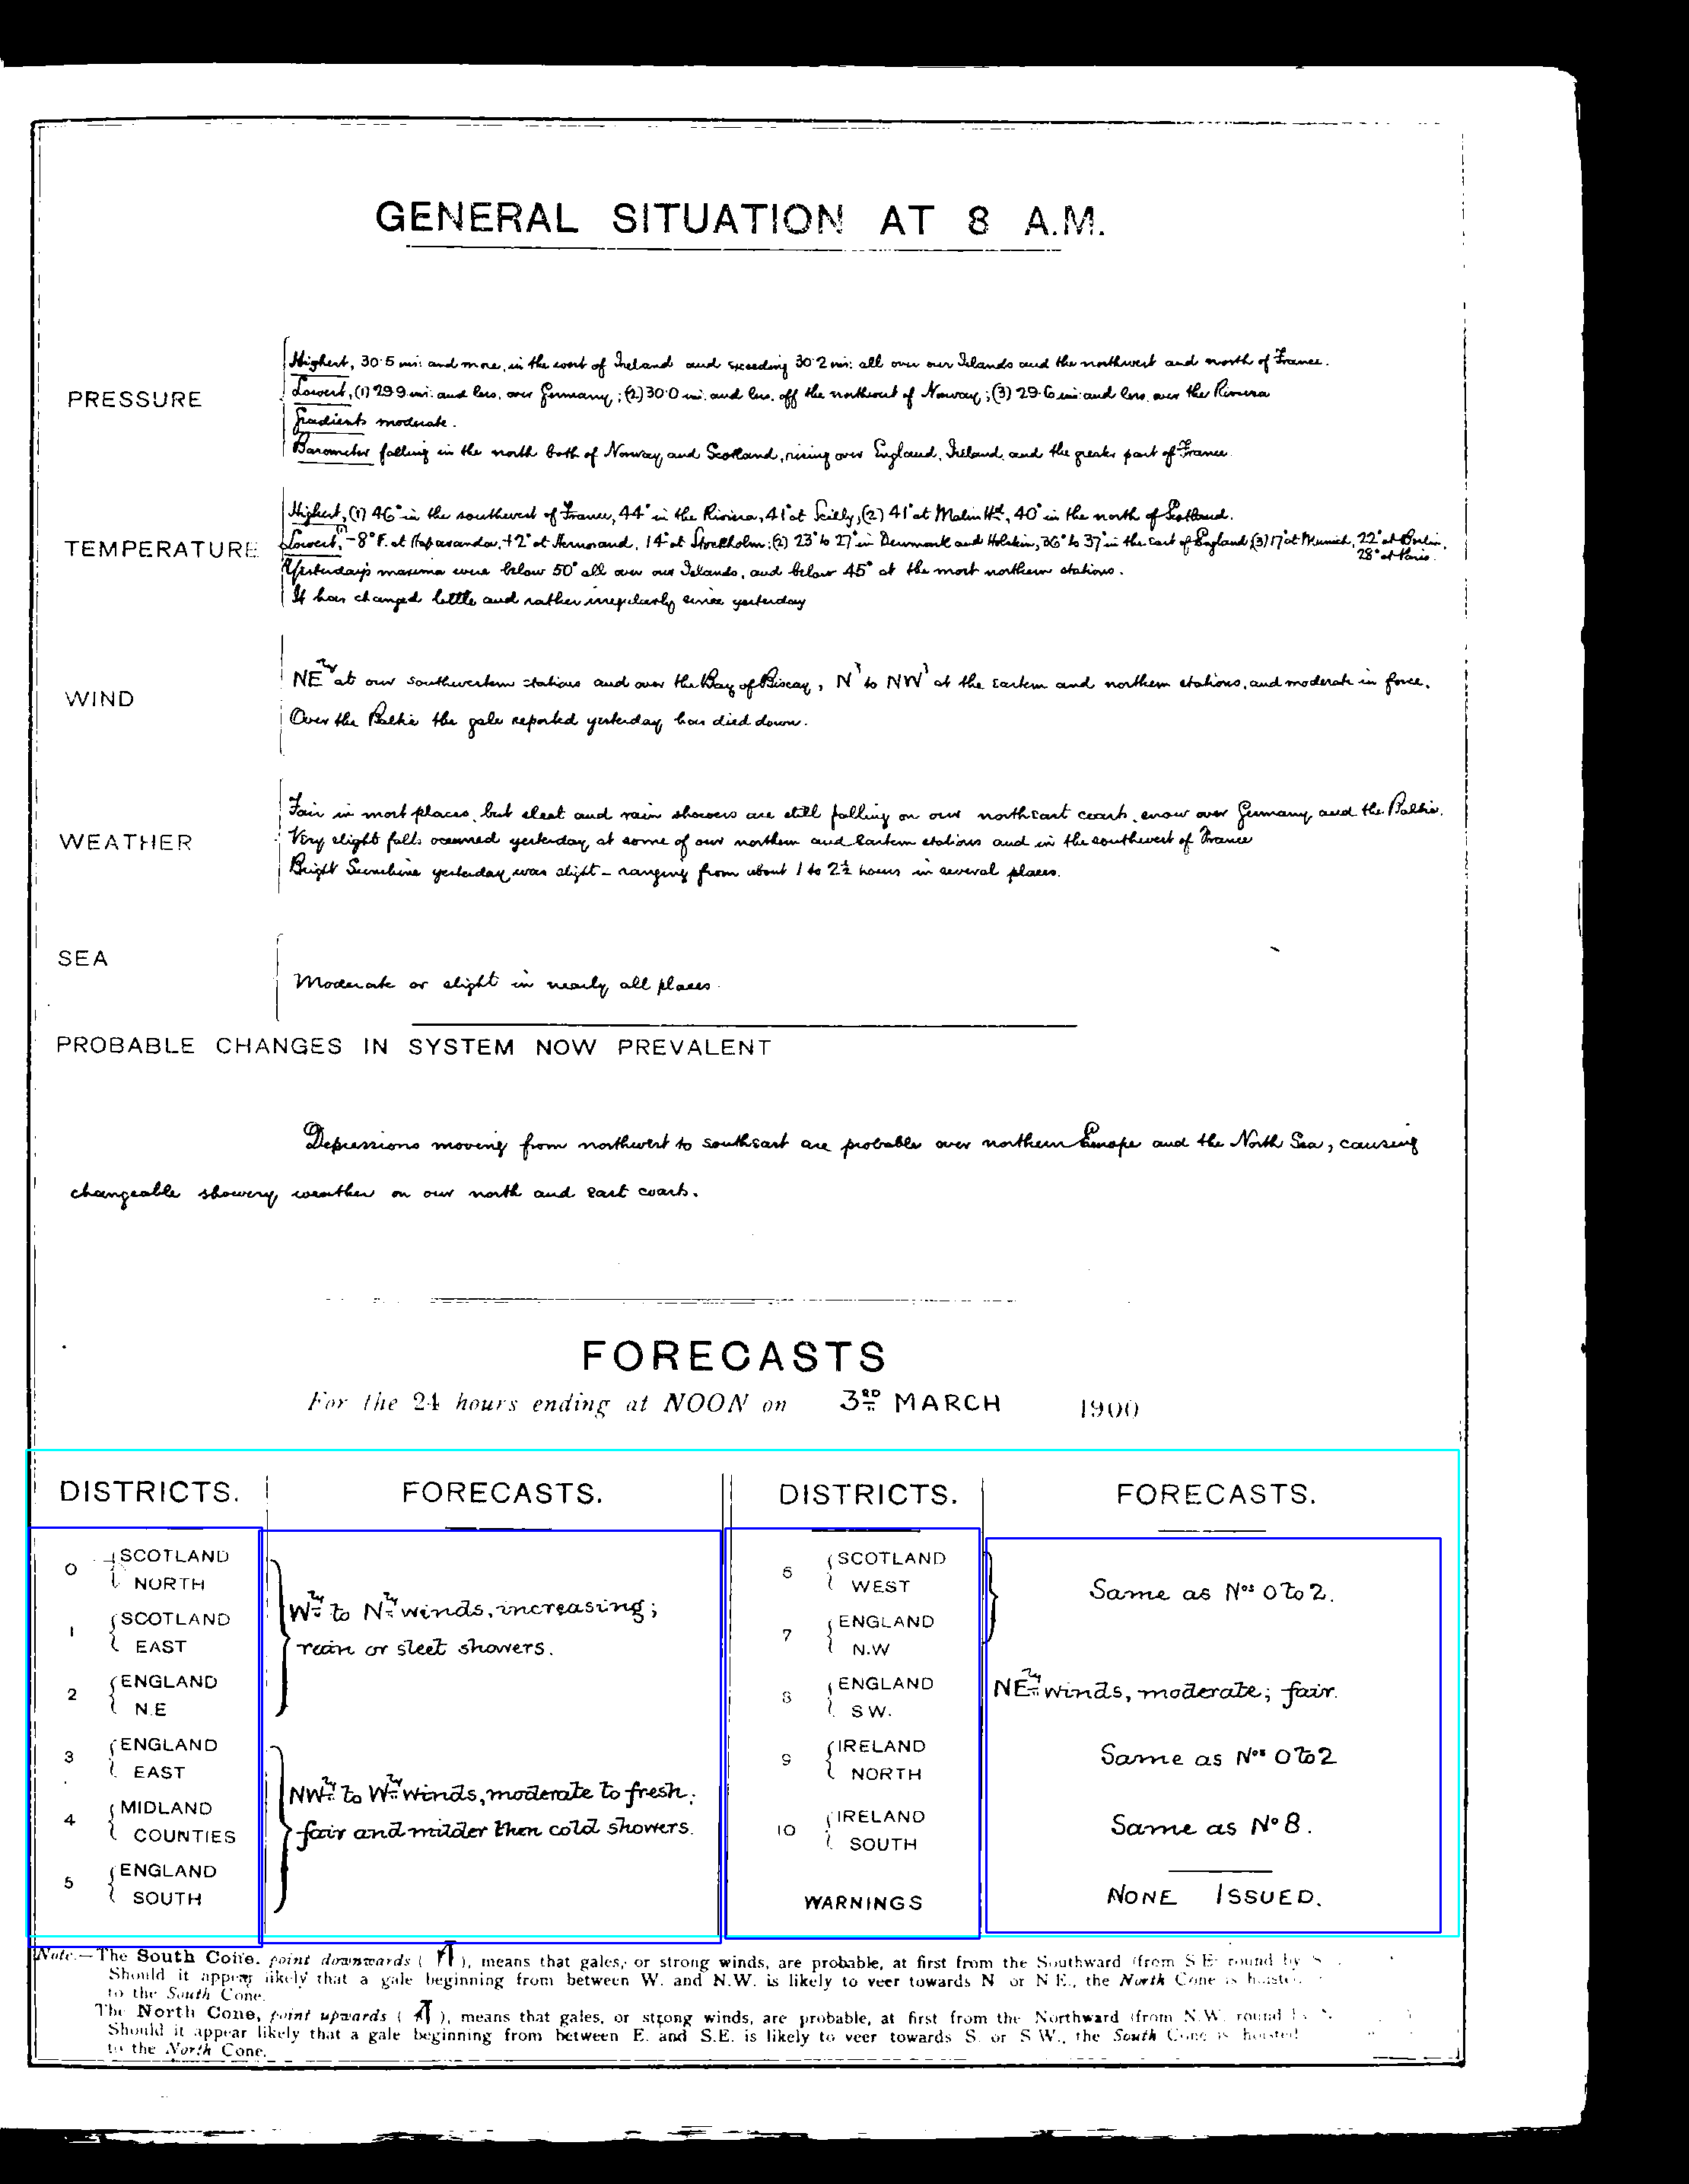

In [39]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(filter_ori_correct_cells):
    put_box(image,box,(0,0,color)) # Blue
    
# for box in list(exclude_cells):
#     put_box(image,box,(color,0,0)) # Red

im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/4.filtered_table_cell_detection.jpg")
im_pil  

In [40]:
table_cells = get_x_y(tables, filter_ori_correct_cells)
cell_cordinates, average_cordinates = get_coordinates(table_cells,0.5)

In [41]:
filter_ori_correct_cells

[[37, 2007, 344, 2558, 0],
 [953, 2008, 1287, 2547, 0],
 [340, 2011, 947, 2553, 0],
 [1296, 2021, 1893, 2539, 0]]

In [42]:
table_cells

[[[37, 344, 953, 1287, 340, 947, 1296, 1893],
  [2007, 2558, 2008, 2547, 2011, 2553, 2021, 2539]]]

In [43]:
cell_cordinates

[[[37, 342, 950, 1291, 1893], [2009, 2545]]]

### Generate cells

In [44]:
possible_cells, exclude_cells_pred = generate_cells(masks[1], tables, cell_cordinates, average_cordinates)

[34, 1905, 37, 2009]
[34, 2009, 37, 2544]
[37, 1905, 342, 2009]
[37, 2009, 342, 2544]
[342, 1905, 950, 2009]
[342, 2009, 950, 2544]
[950, 1905, 1291, 2009]
[950, 2009, 1291, 2544]
[1291, 1905, 1893, 2009]
[1291, 2009, 1893, 2544]
[1893, 1905, 1917, 2009]
[1893, 2009, 1917, 2544]


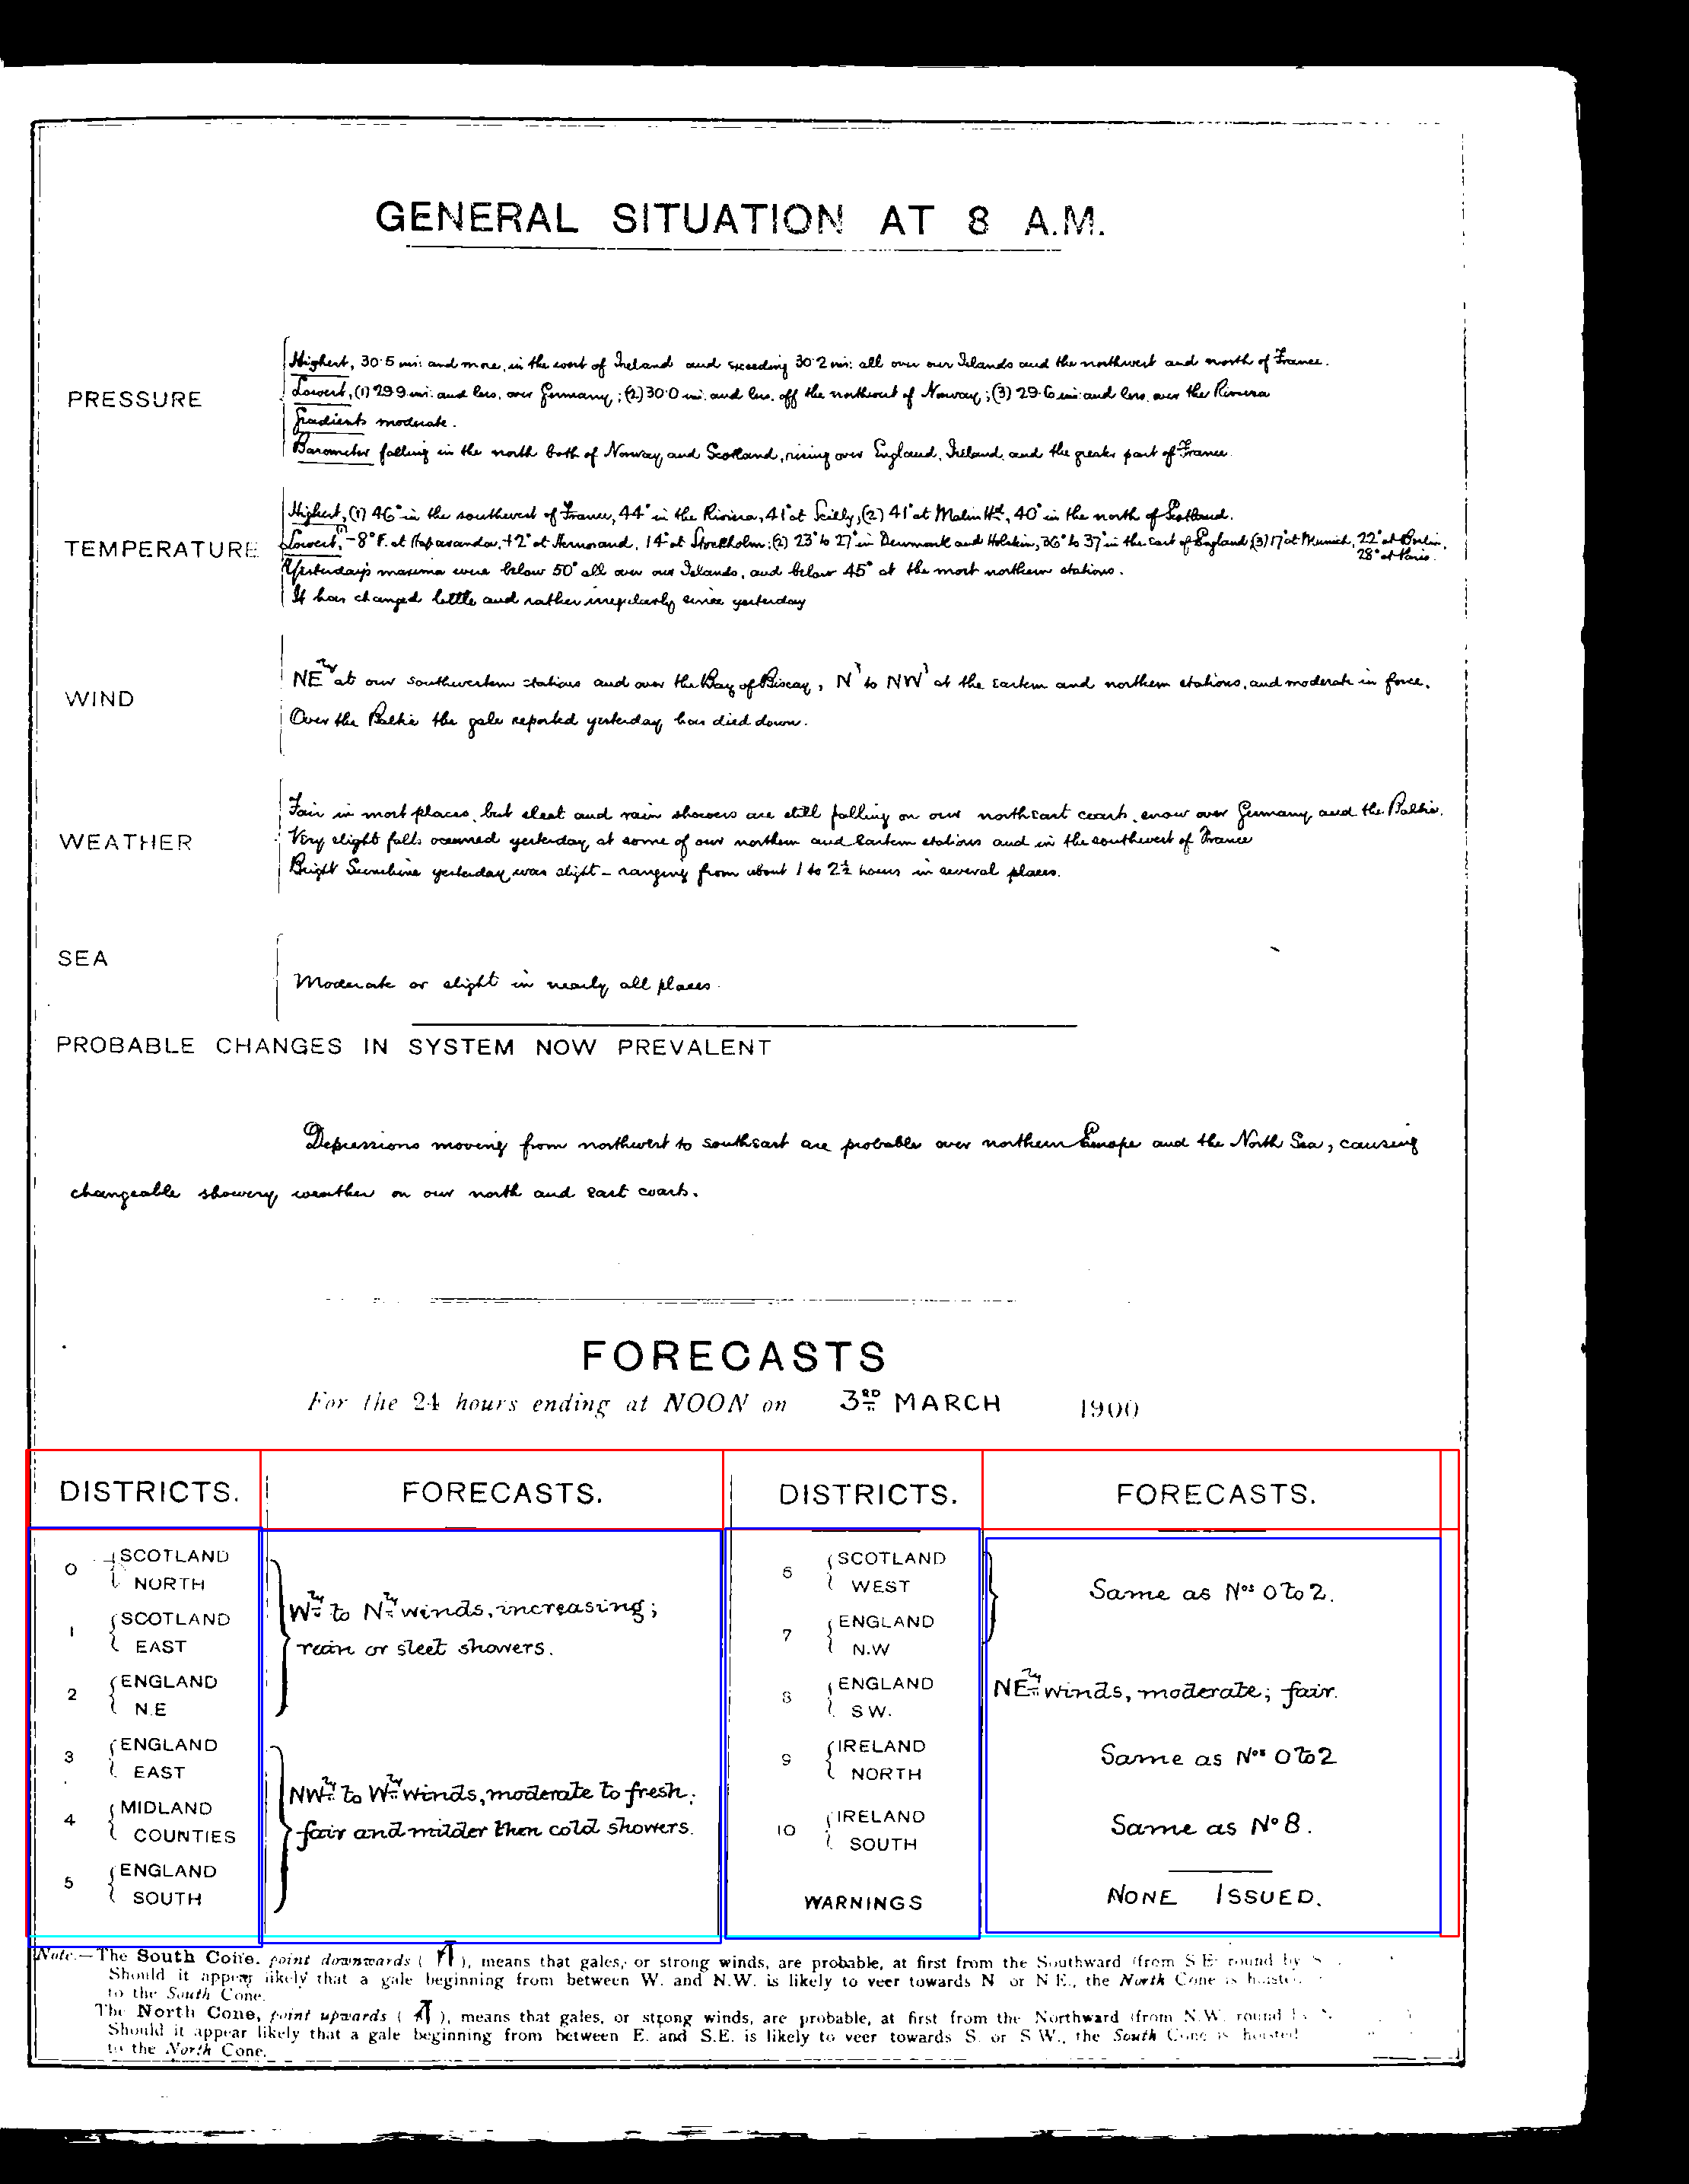

In [45]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(exclude_cells_pred):
    put_box(image,box,(color,0,0)) # Red
    
for box in list(filter_ori_correct_cells):
    put_box(image,box,(0,0,color)) # Green
    
# for box in list(correct_cells):
#     put_box(image,box,(0,color,0)) # Green
    
# for box in list(blank_cells):
#     put_box(image,box,(color,color,0)) # Yellow
    
im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/5.table_cell_generation.jpg")
im_pil  

In [46]:
if len(possible_cells)>0:
    correct_cells, blank_cells, exclude_cells = classify_cells(possible_cells, masks[1], average_cordinates,pc = 0.7) 
else:
    correct_cells, blank_cells, exclude_cells = classify_cells(ori_correct_cells, masks[1], average_cordinates)   

In [42]:
considered_cells = correct_cells + blank_cells
considered_cells, filter_considered_cells_new = find_overlapped_cell(filter_ori_correct_cells, considered_cells, average_cordinates)

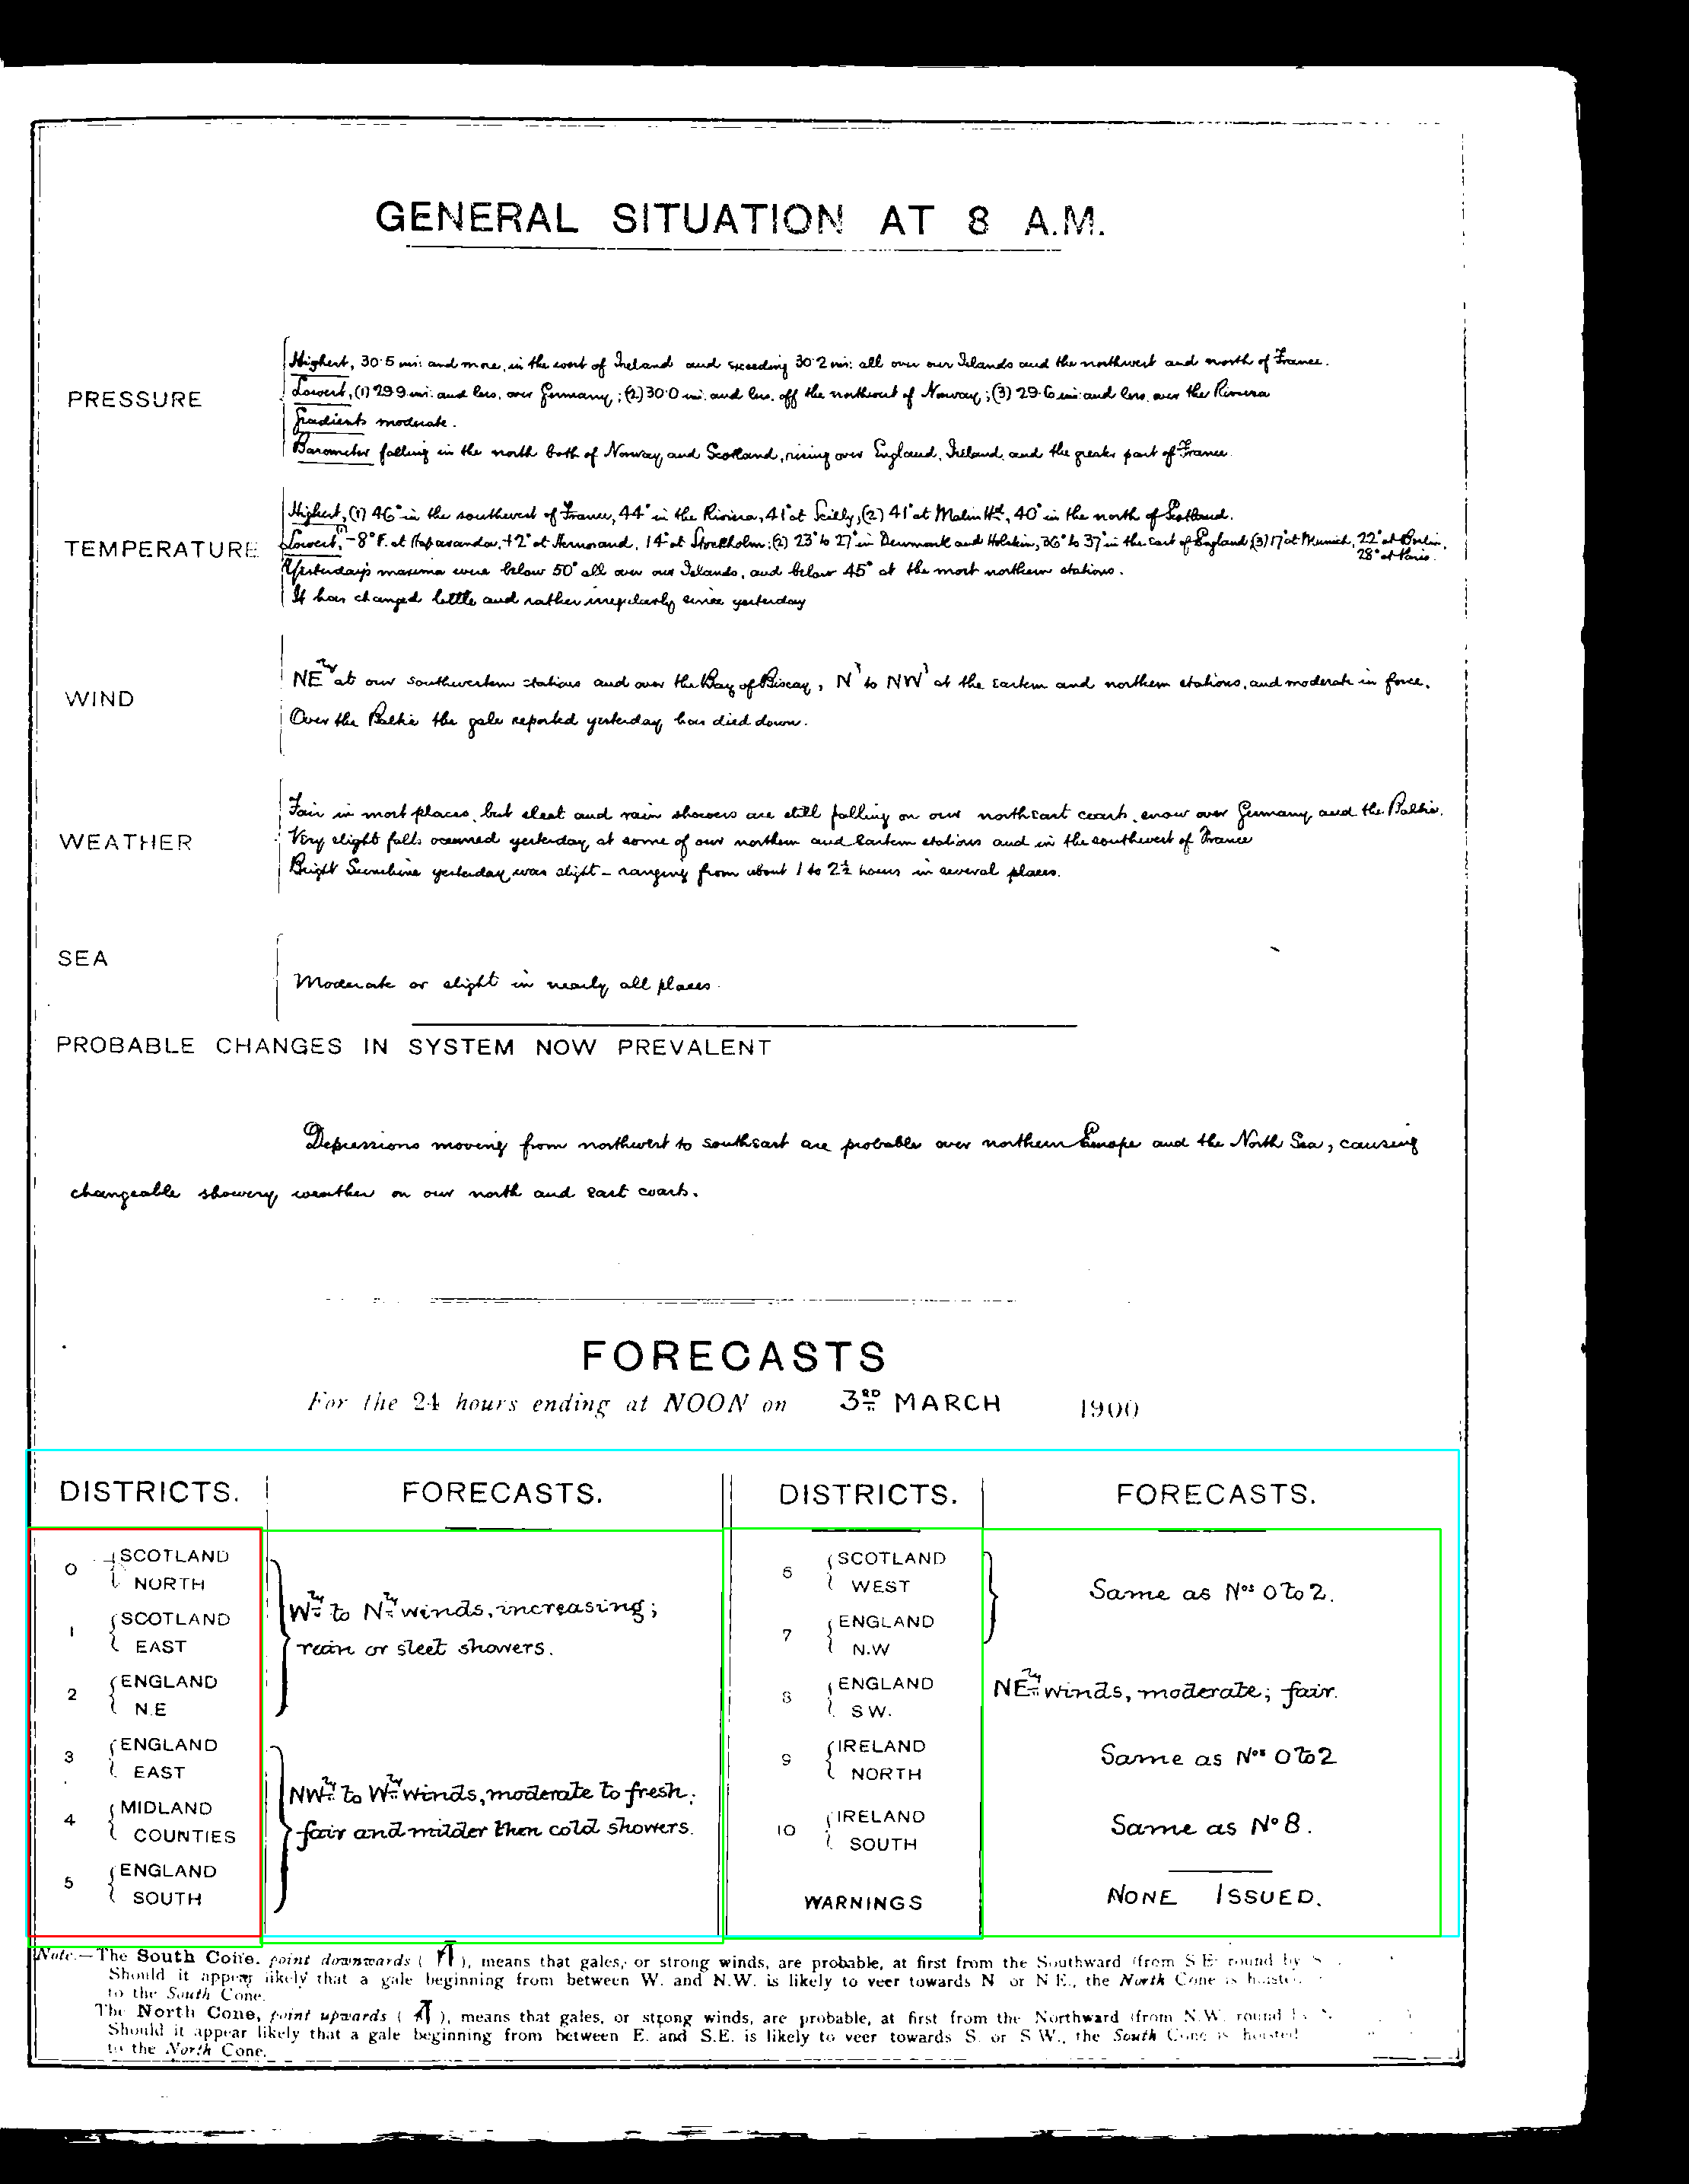

In [43]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(filter_considered_cells_new):
    put_box(image,box,(0,color,0)) # Green
    
for box in list(exclude_cells):
    put_box(image,box,(color,0,0)) # Yellow
    
for box in list(considered_cells):
    put_box(image,box,(0,0,color)) # Green
    
im_pil = Image.fromarray(image)
# im_pil.save(f"{outdirectory}/{filename}/5.table_cell_generation.jpg")
im_pil  

In [44]:
if len(exclude_cells_pred)>0:
    ex_correct_cells, ex_blank_cells, ex_exclude_cells = classify_cells(exclude_cells_pred, masks[1], average_cordinates, pc=0.7) 

In [45]:
ex_considered_cells = ex_correct_cells + ex_blank_cells
ex_considered_cells, filter_considered_cells_new = find_overlapped_cell(filter_considered_cells_new+considered_cells, ex_considered_cells, average_cordinates)

In [46]:
exclude_cells, filter_considered_cells_new = find_overlapped_cell(filter_considered_cells_new+ex_considered_cells, ex_exclude_cells+exclude_cells, average_cordinates)

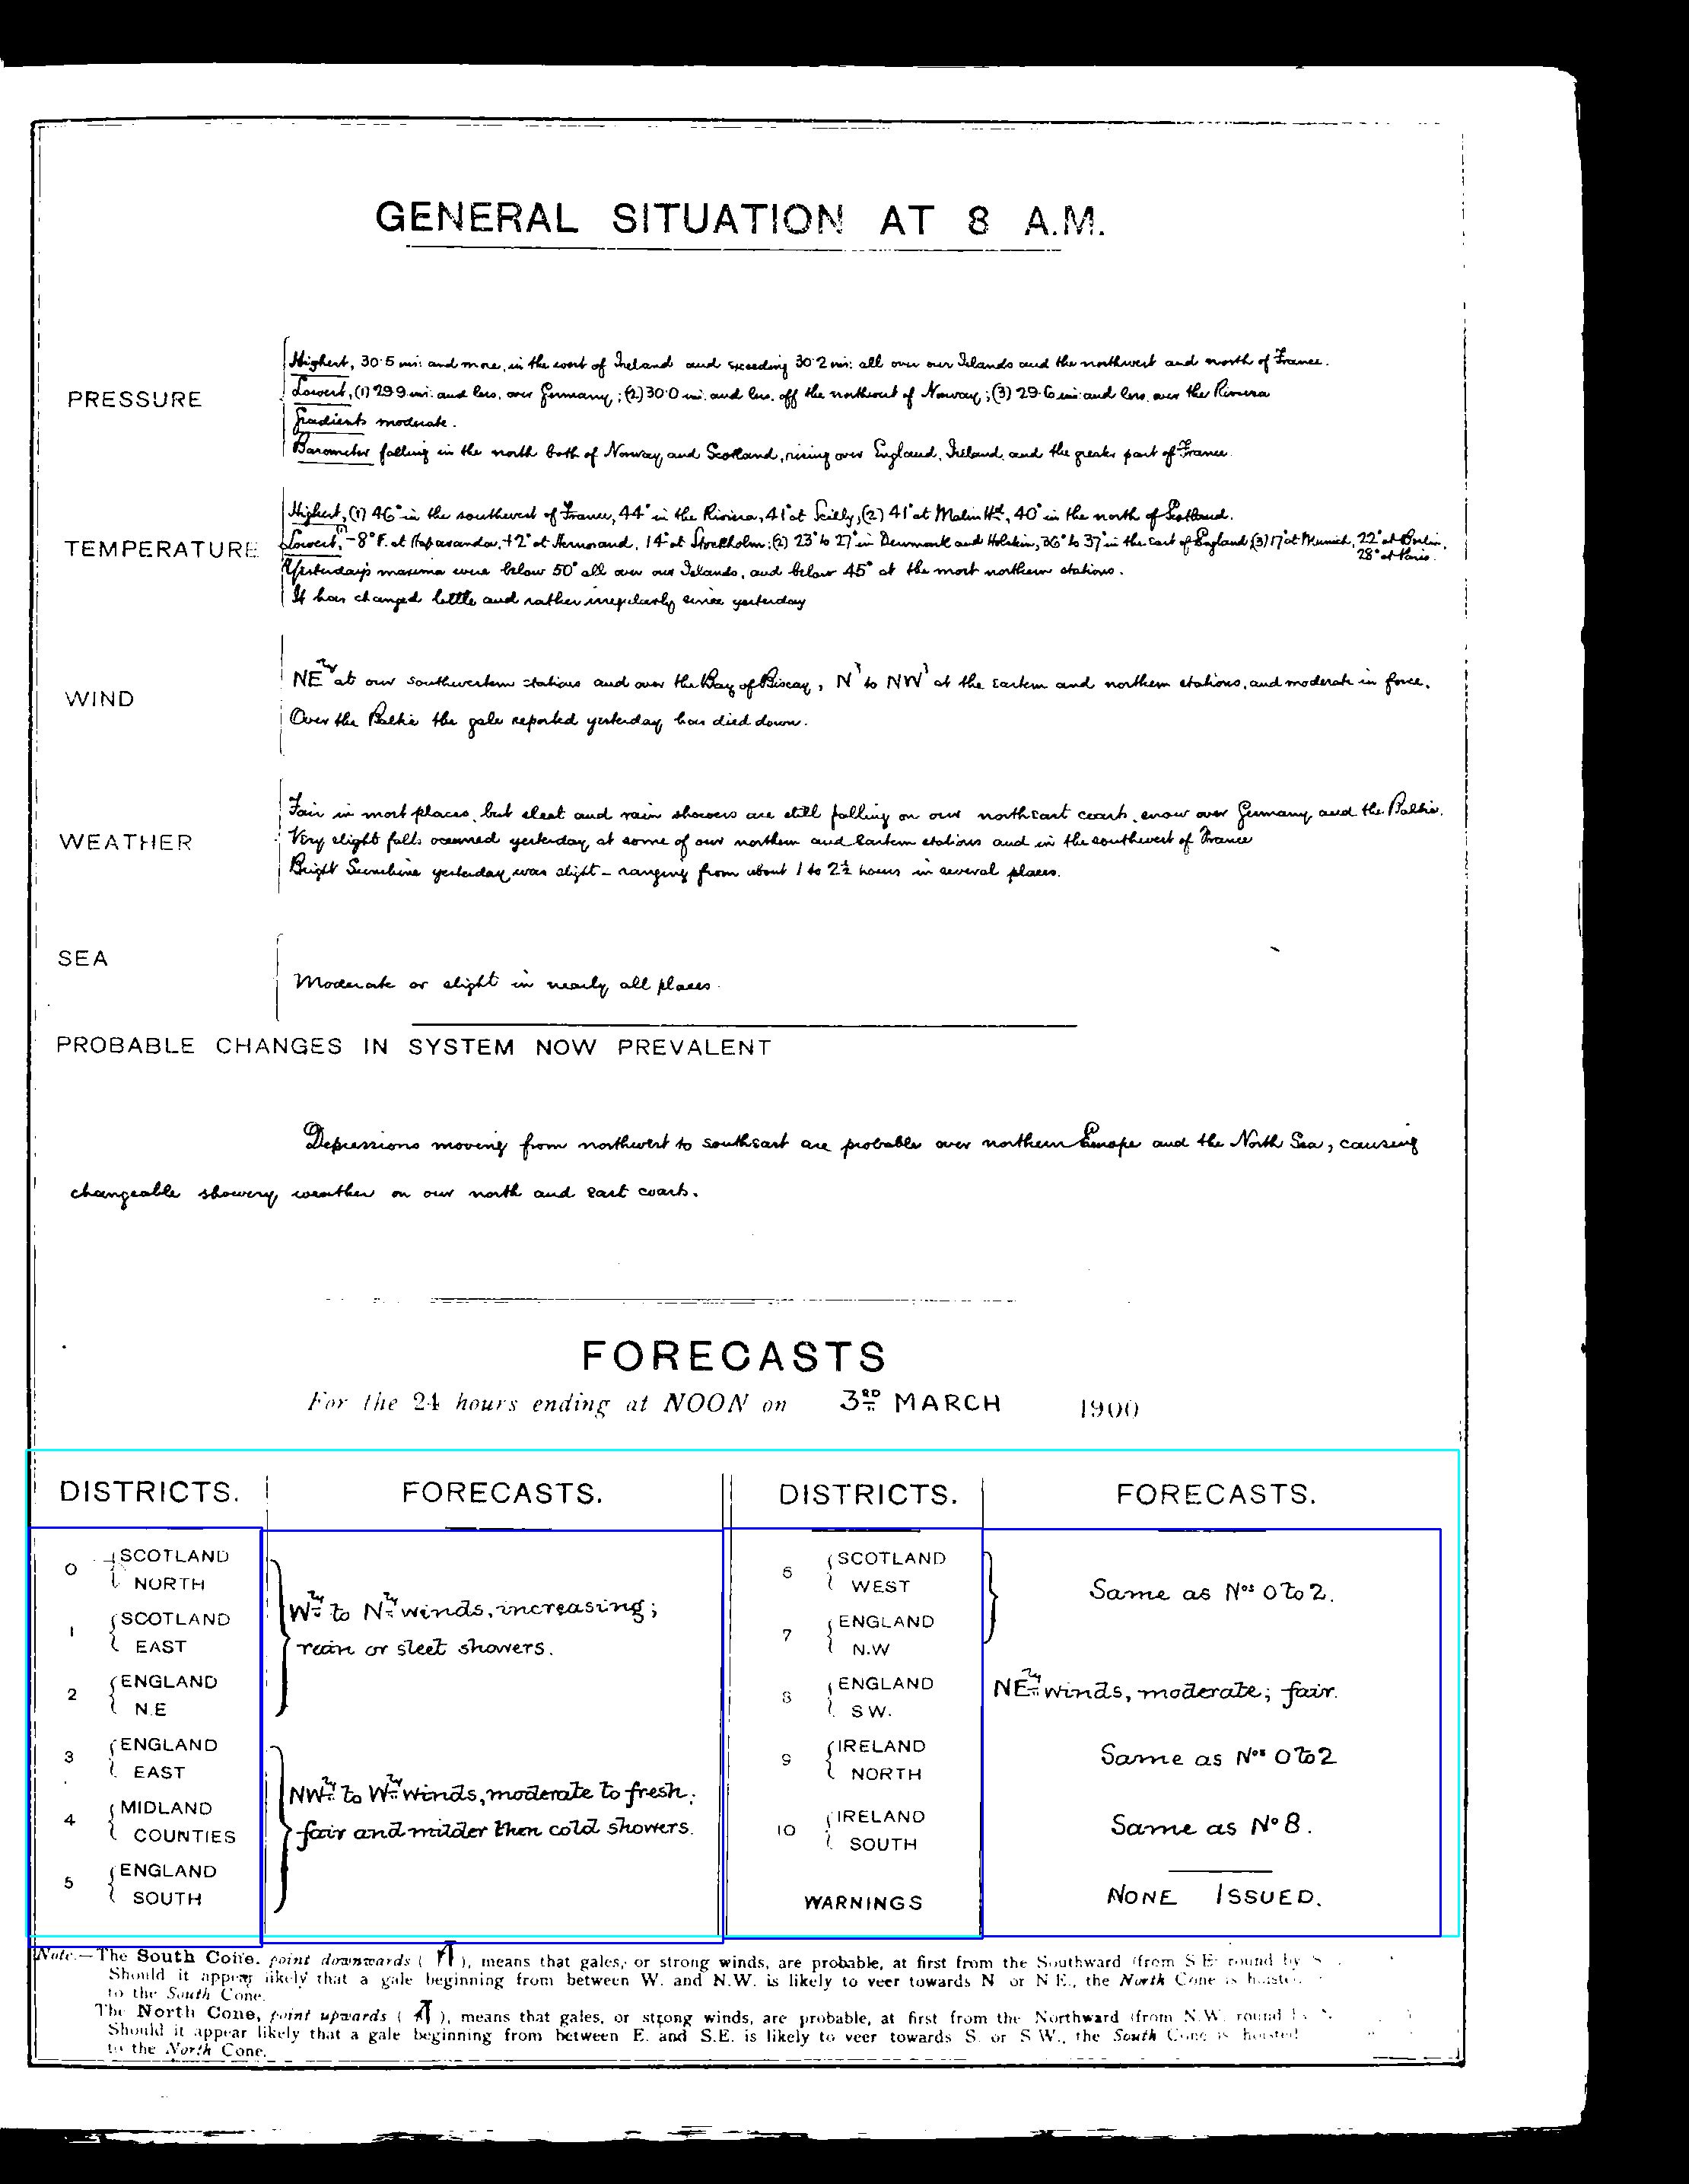

In [47]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(exclude_cells):
    put_box(image,box,(color,0,0)) # Red
    
for box in list(filter_considered_cells_new):
    put_box(image,box,(0,0,color)) # Green
    
im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/6.table_cell_generation_valid.jpg")
im_pil  

### Correct error cells

In [48]:
if len(exclude_cells)>2:
    corrected_cells_new, error_cells = classify_error_cells(exclude_cells, tables, masks[1], average_cordinates,0.7)
    
    if len(corrected_cells_new)>0:
        corrected_cells_n, blank_cells_n, exclude_cells_n = classify_cells(corrected_cells_new, masks[1], average_cordinates)
    else:
        corrected_cells_n = []
        blank_cells_n = []
        exclude_cells_n = []
else:
    corrected_cells_n = []
    blank_cells_n = []
    exclude_cells_n = []
    error_cells = []

In [49]:
corrected_cells_n, _ = find_overlapped_cell(exclude_cells, corrected_cells_n, average_cordinates)
blank_cells_n, _ = find_overlapped_cell(exclude_cells, blank_cells_n, average_cordinates)

In [50]:
considered_cells = filter_considered_cells_new+corrected_cells_n+blank_cells_n
exclude_cells_n, _ = find_overlapped_cell(considered_cells, exclude_cells, average_cordinates)

In [51]:
filter_all_valid_cells_new =filter_overlapped_cell(considered_cells, average_cordinates)

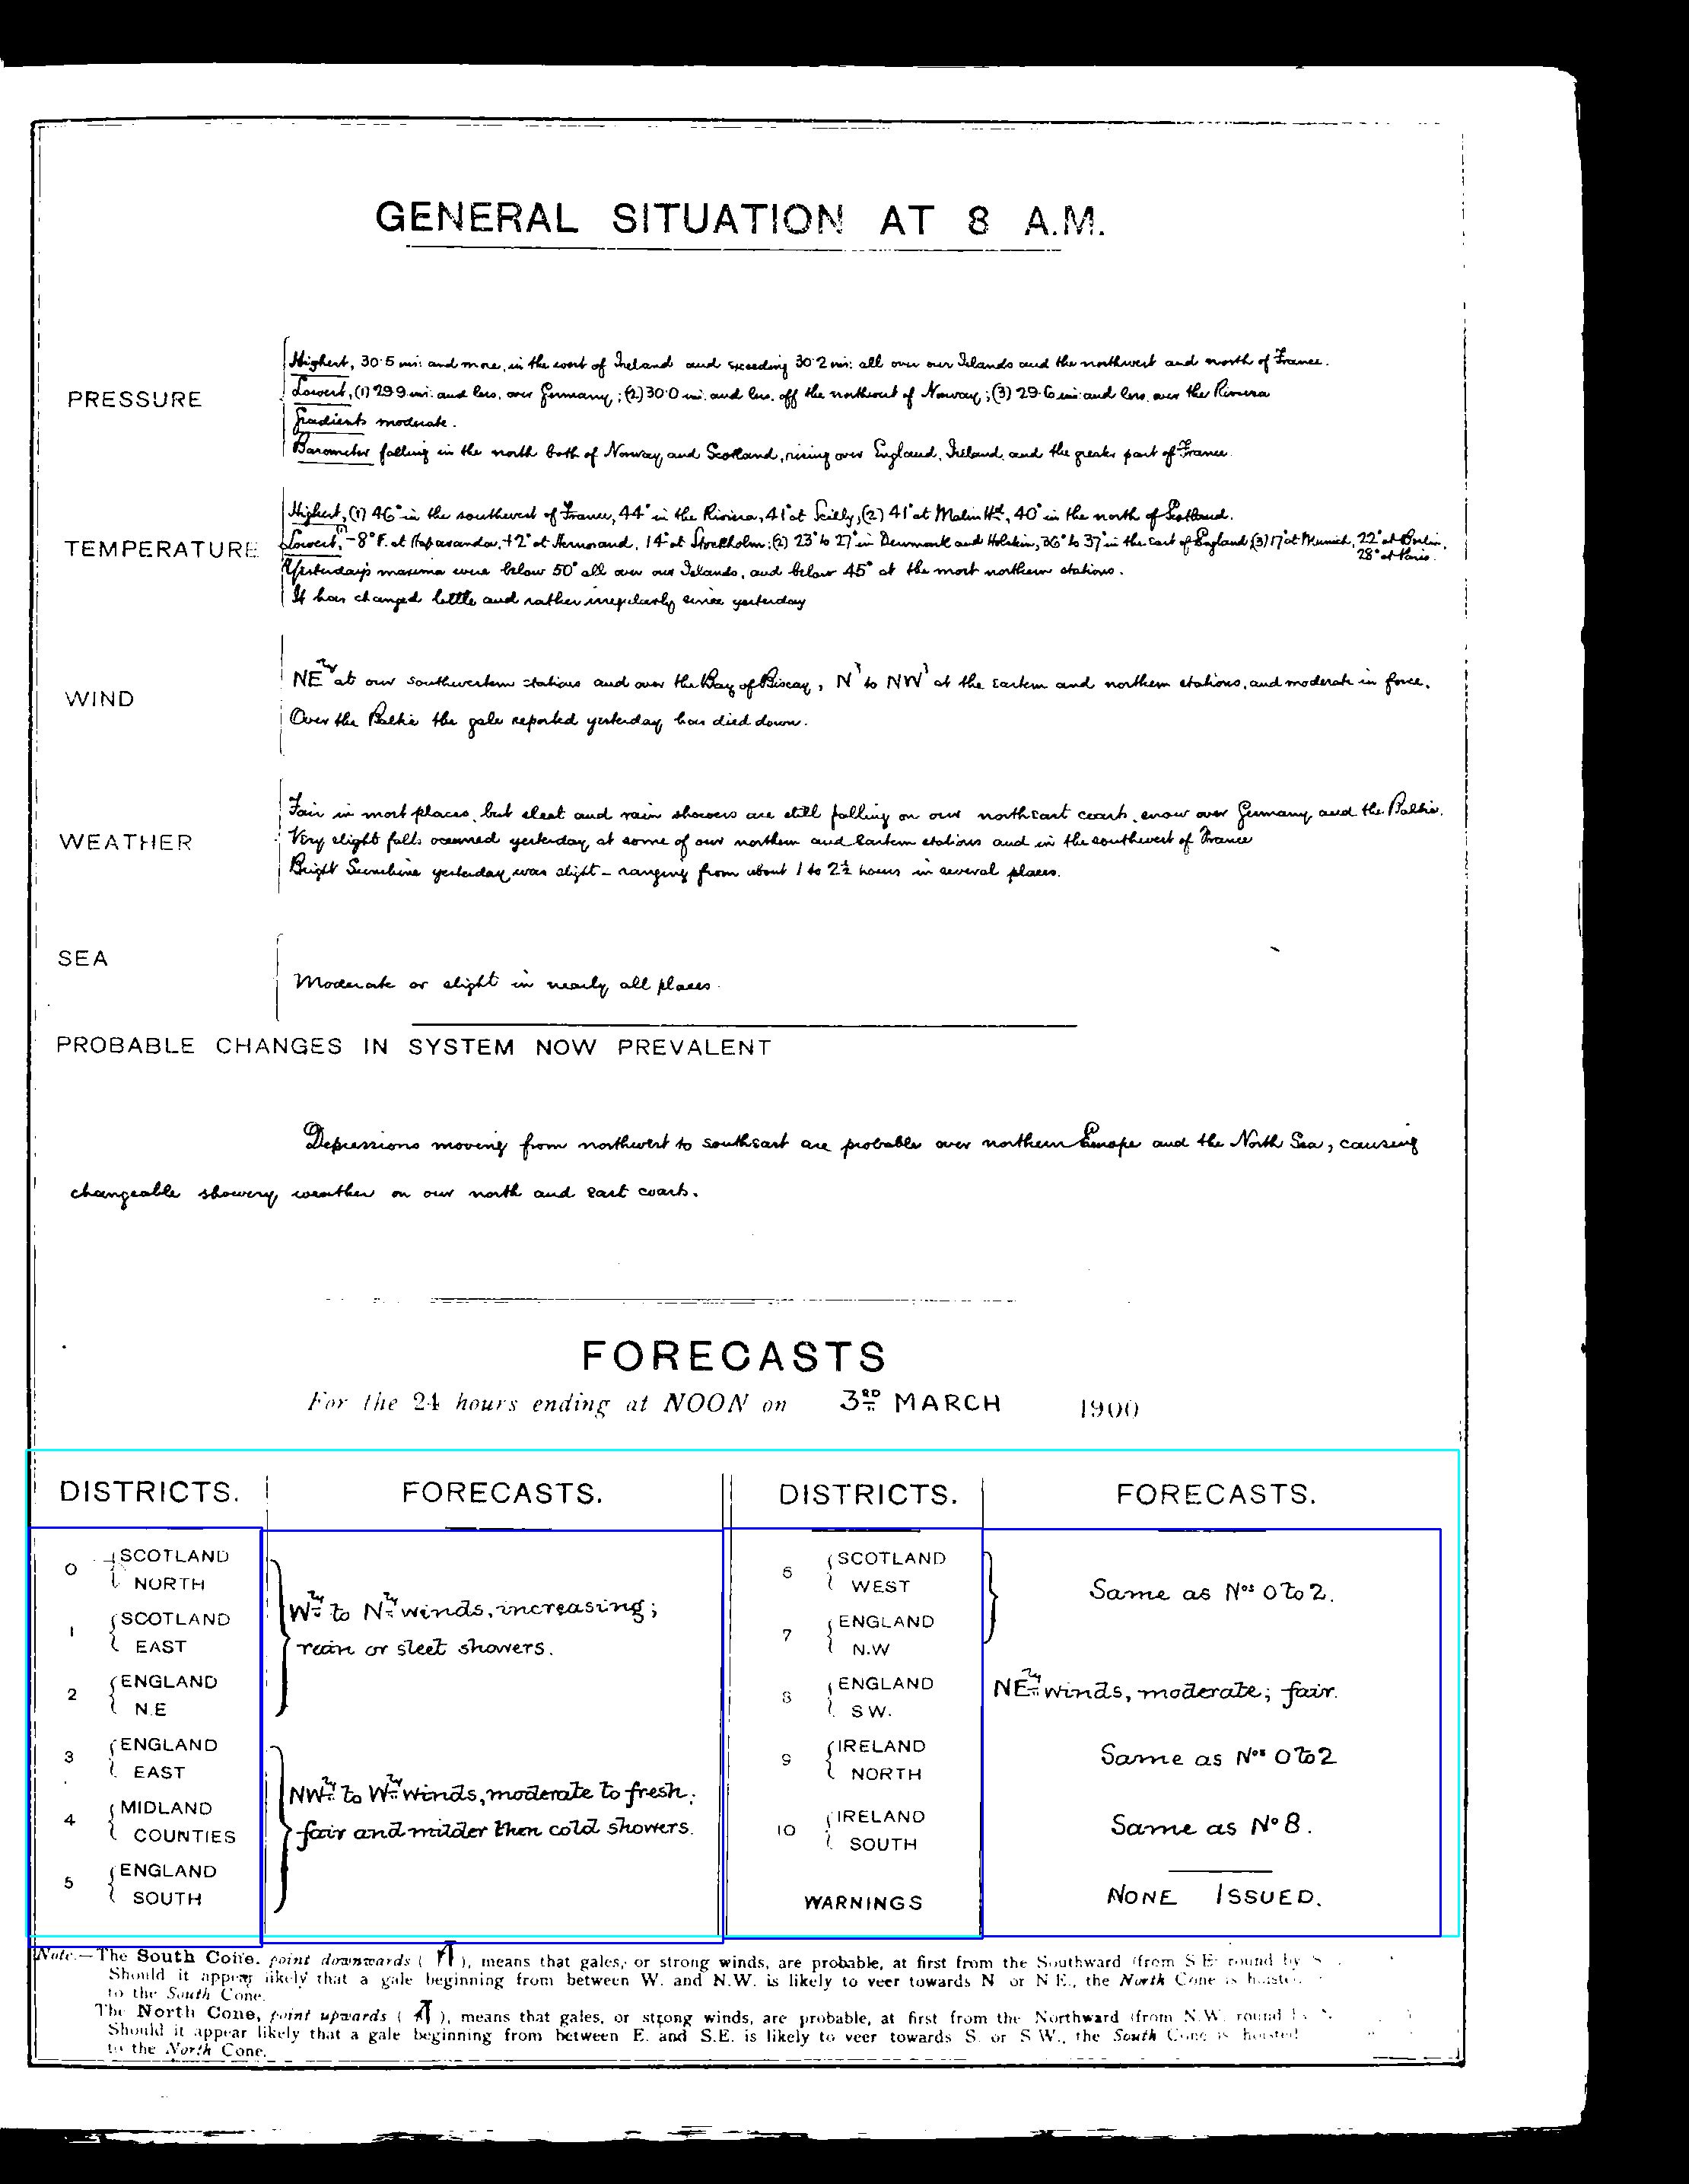

In [52]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
    
for box in list(filter_all_valid_cells_new):
    put_box(image,box,(0,0,color)) # Green
    
# for box in list(corrected_cells_n):
#     put_box(image,box,(0,color,0)) # Green
    
# for box in list(blank_cells_n):
#     put_box(image,box,(0,0,color)) # Green
    
for box in list(exclude_cells_n):
    put_box(image,box,(color,0,0)) # Red
    
im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/7.table_cell_correction_invalid.jpg")
im_pil  

### Generate new cells from valid cells

In [53]:
table_cells = get_x_y(tables, list(filter_all_valid_cells_new)) 
cell_cordinates, average_cordinates = get_coordinates(table_cells,0.7)

possible_cells, exclude_cells_pred = generate_cells(masks[1], tables, cell_cordinates, average_cordinates)
possible_cells, all_valid_cells = find_overlapped_cell(filter_all_valid_cells_new, possible_cells, average_cordinates)

[[[37, 343, 950, 1291, 1893], [2008, 2547]]]
[37, 950, 1291, 1893] [37, 343, 950, 1291, 1893] 464.0 0.7
[34, 1905, 37, 2008]
[34, 2008, 37, 2544]
[37, 1905, 950, 2008]
[37, 2008, 950, 2544]
[950, 1905, 1291, 2008]
[950, 2008, 1291, 2544]
[1291, 1905, 1893, 2008]
[1291, 2008, 1893, 2544]
[1893, 1905, 1917, 2008]
[1893, 2008, 1917, 2544]


In [54]:
if len(possible_cells)>0:
    correct_cells, blank_cells, exclude_cells = classify_cells(possible_cells, masks[1], average_cordinates,pc = 0.7) 
else:
    correct_cells = [] 
    blank_cells = []
    exclude_cells = []

In [55]:
considered_cells = correct_cells + blank_cells
considered_cells, filter_considered_cells_new = find_overlapped_cell(filter_all_valid_cells_new, considered_cells, average_cordinates)

In [56]:
if len(exclude_cells_pred)>0:
    ex_correct_cells, ex_blank_cells, ex_exclude_cells = classify_cells(exclude_cells_pred, masks[1], average_cordinates, pc=0.7) 

ex_considered_cells = ex_correct_cells + ex_blank_cells
ex_considered_cells, filter_considered_cells_new = find_overlapped_cell(filter_considered_cells_new+considered_cells, ex_considered_cells, average_cordinates)

In [57]:
exclude_cells, filter_considered_cells_new = find_overlapped_cell(filter_considered_cells_new+ex_considered_cells, exclude_cells_pred, average_cordinates)

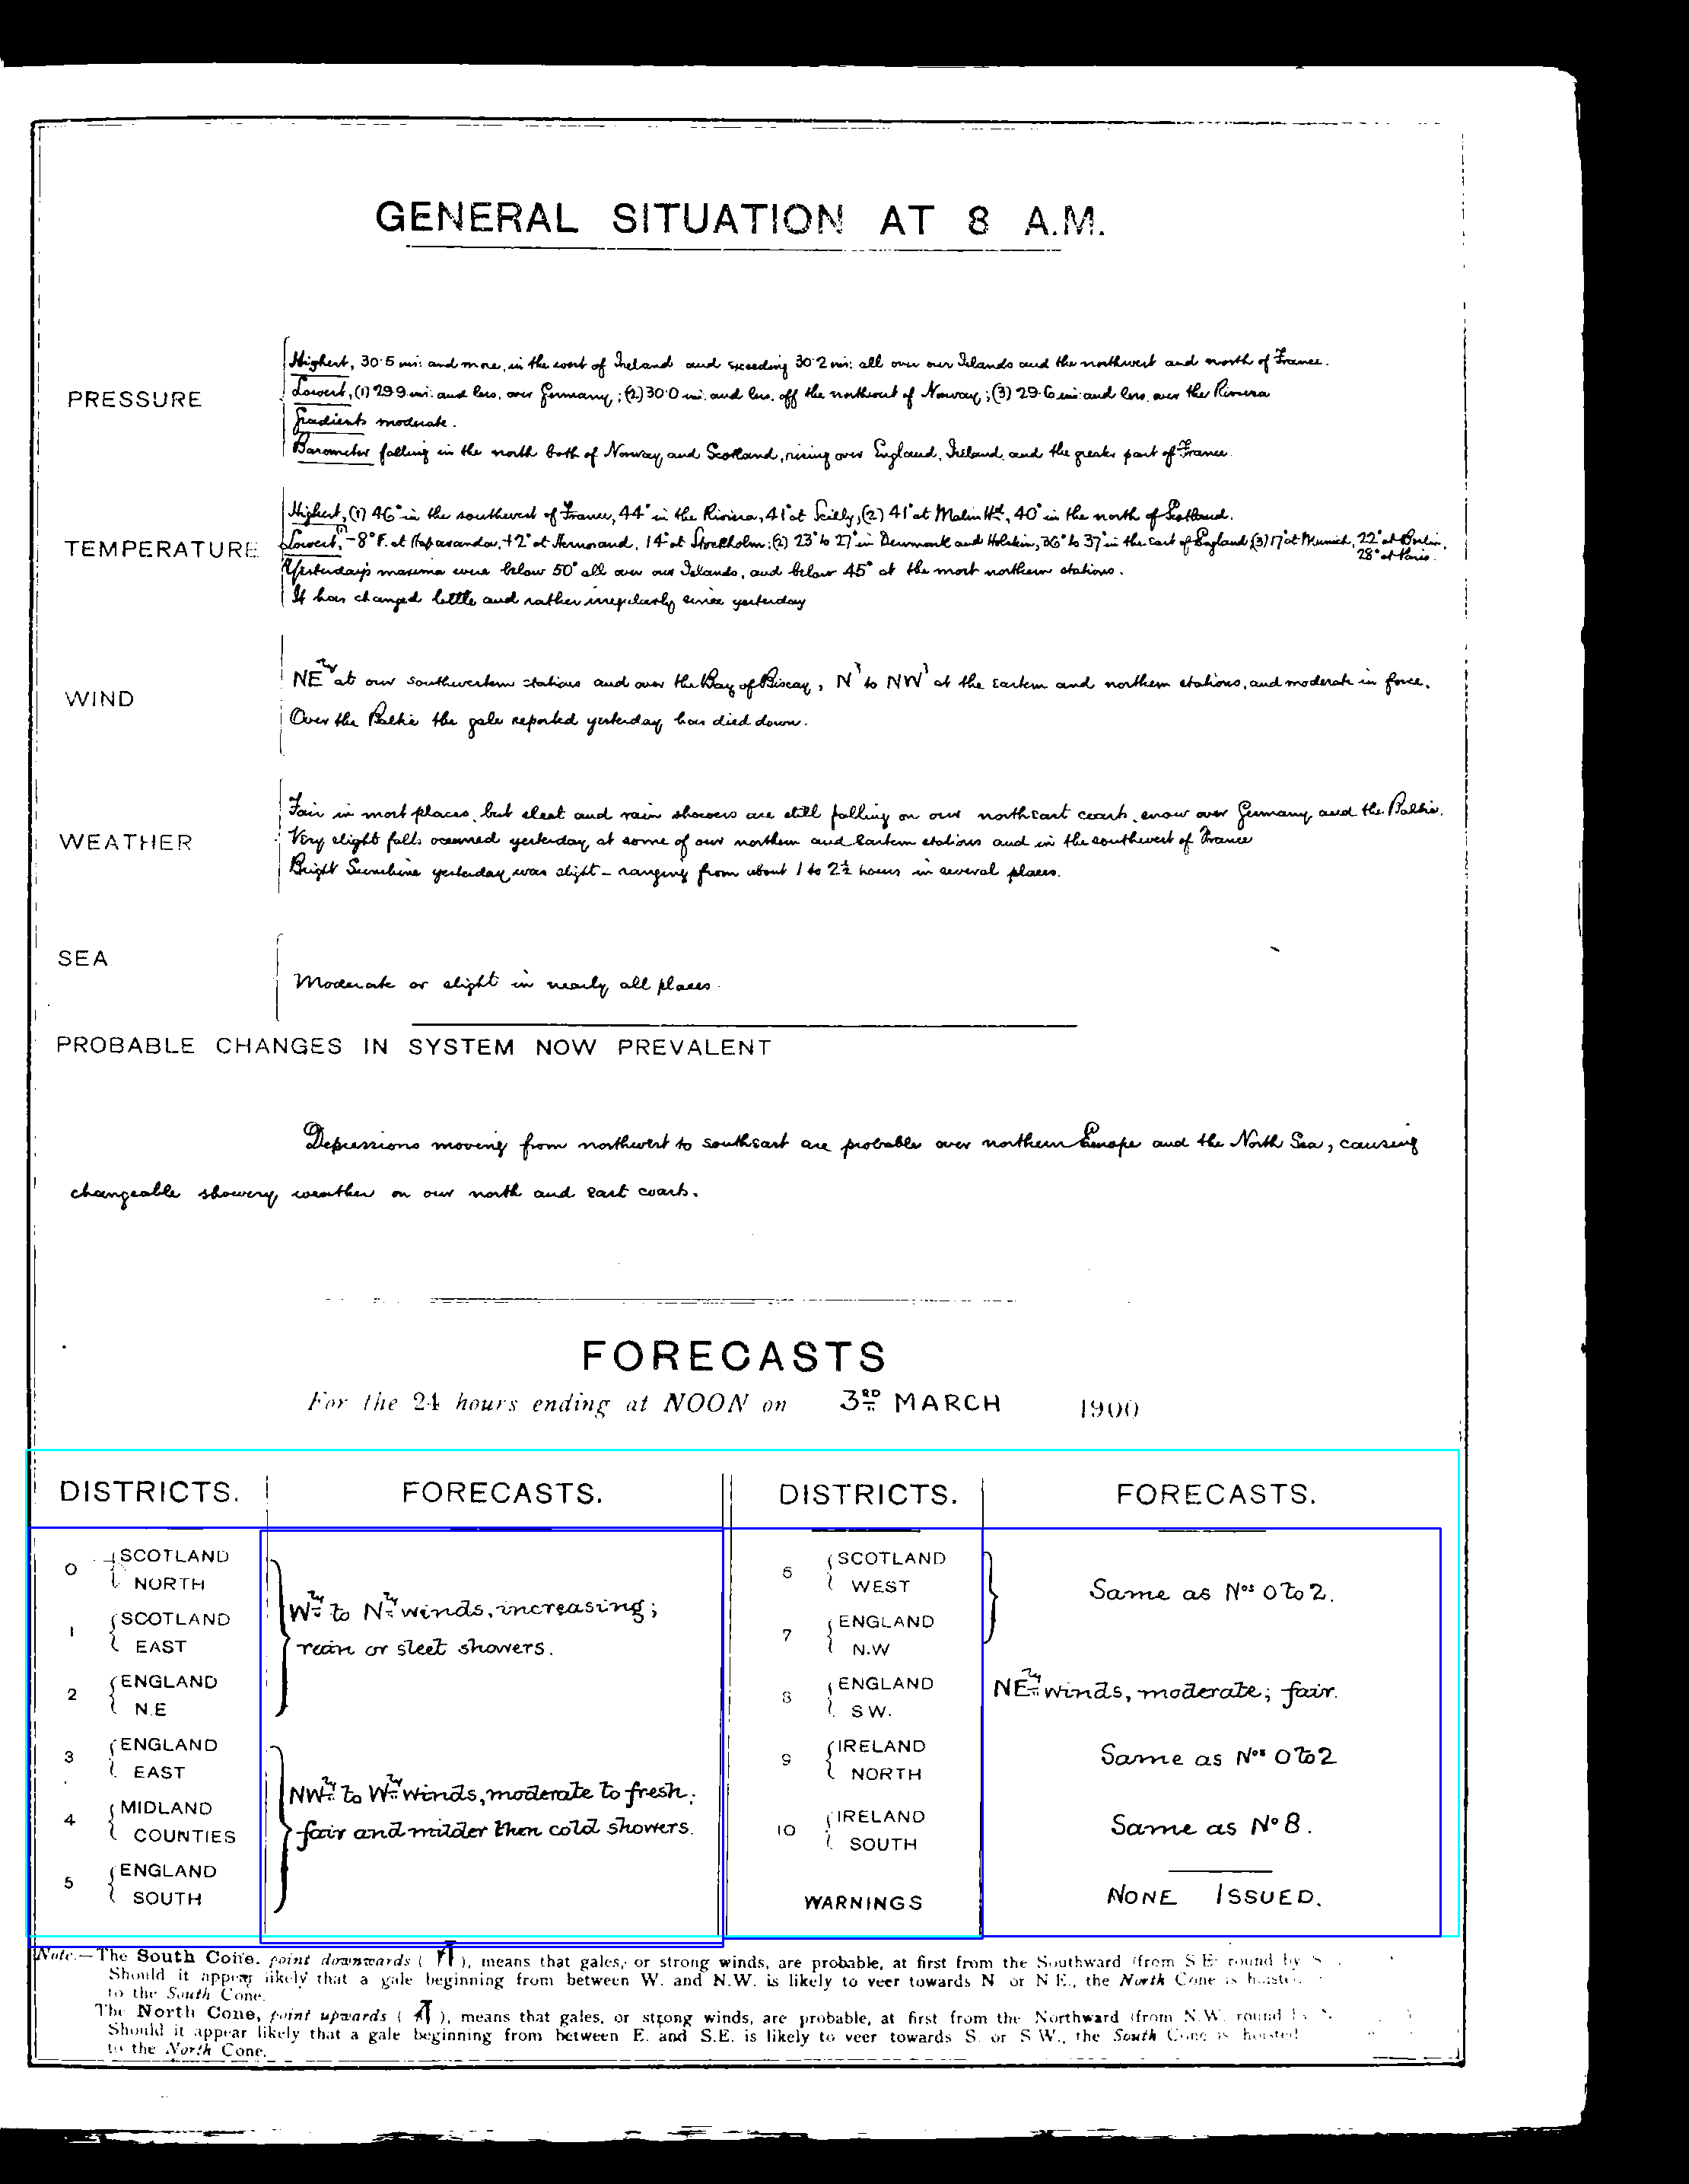

In [58]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)
color = 255

for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(exclude_cells):
    put_box(image,box,(color,0,0)) # Green
    
for box in list(filter_considered_cells_new):
    put_box(image,box,(0,0,color)) # Green
# for box in list(ex_considered_cells):
#     put_box(image,box,(0,color,0)) # Green
    
    
im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/8.table_cell_gen_valid_cell.jpg")
im_pil  

### Merge error cells for correction

In [59]:
# def merge_cells(cells, tables, average_cordinates):    
#     x_y_neighbouring_cells_dict = {}
#     if len(cells)>2:
#         neighbouring_cells, y_cords, x_cords = get_x_y_neighbour_cells(cells, tables, average_cordinates)

#         for yid in neighbouring_cells:
#             cells = neighbouring_cells[yid]

#             x_neighbours = cells[1]

#             tid = x_neighbours[0][4]

#             avg_x, avg_y = average_cordinates[tid]

#             # print(yid,y_neighbours,x_neighbours,tid, average_cordinates[tid])

#             # find x_neighbours
#             ncells = []
#             imagedraw = []
#             next_cell_begin = True
#             starting_cell = []

#             y_neighbours = []
#             for y_nid in cells[0]:
#                 if abs(y_nid - yid) < (avg_y + avg_y * 0.2):  # Filter column neighbour ids
#                     y_neighbours.append(y_nid)

#             for xid, xcell in enumerate(x_neighbours):  # Filter row neighbour cells
#                 # Either split the cell or merge to begining cell
#                 if next_cell_begin:
#                     starting_cell = list(xcell)
#                 elif abs(starting_cell[2] - xcell[0]) < avg_x * 0.01:
#                     starting_cell[2] = xcell[2]

#                 # check next cell distance
#                 if (xid + 1) < len(x_neighbours):
#                     next_cell = x_neighbours[xid + 1]
#                     if abs(next_cell[0] - xcell[2]) < avg_x * 0.01:
#                         next_cell_begin = False
#                     else:
#                         ncells.append(starting_cell)
#                         starting_cell = []
#                         next_cell_begin = True
#                 elif len(x_neighbours) == 1:
#                     ncells.append(starting_cell)
#                     starting_cell = []

#             if len(starting_cell) > 0:
#                 ncells.append(starting_cell)

#             #     print(x_neighbours,'---',ncells)
#             x_y_neighbouring_cells_dict[yid] = (y_neighbours, ncells)

#     # combine x and y neighbours v2
#     neighbours = []
#     if len(x_y_neighbouring_cells_dict) > 0:
#         for yid in x_y_neighbouring_cells_dict:
#             ynid, xnid = x_y_neighbouring_cells_dict[yid]
#             above_cells = []
#             cur_cells = []
#             below_cells = []
#             for y_n in ynid:
#                 if y_n < yid:
#                     above_cells = x_y_neighbouring_cells_dict[y_n][1]
#                 else:
#                     cur_cells = xnid
#                     if y_n > yid:
#                         below_cells = x_y_neighbouring_cells_dict[y_n][1]

#             print(
#                 f'============{yid}================== \nAbove cells:{above_cells} \nCurrent cells: {xnid} \nBelow cells: {below_cells}')

#             for cur_cell2 in xnid:
#                 xc0, yc0, xc1, yc1, tid = cur_cell2[0:5]
#                 avg_x, avg_y = average_cordinates[tid]
#                 cur_neigh = []
#                 for cur_cell_a in above_cells:
#                     xa0, ya0, xa1, ya1, tid_a = cur_cell_a[0:5]
#                     cell_a = [xa0, ya0, xa1, ya1]
#                     cell_b = [xc0, ya0, xc1, ya1]

#                     if tsa.how_much_contained(cell_a, cell_b) > 0.5:
#                         cur_neigh.append(cur_cell_a)
#                     elif tsa.how_much_contained(cell_b, cell_a) > 0.5:
#                         cur_neigh.append(cur_cell_a)

#                 cur_neigh.append(cur_cell2)
#                 for cur_cell_b in below_cells:
#                     xb0, yb0, xb1, yb1, tid_b = cur_cell_b[0:5]
#                     cell_a = [xc0, yc0, xc1, yc1]
#                     cell_b = [xb0, yc0, xb1, yc1]

#                     if tsa.how_much_contained(cell_a, cell_b) > 0.5:
#                         cur_neigh.append(cur_cell_b)
#                     elif tsa.how_much_contained(cell_b, cell_a) > 0.5:
#                         cur_neigh.append(cur_cell_b)

#                 neighbours.append(cur_neigh)


#     merged_cells = []
#     for neigh_cells in neighbours:
#         if len(neigh_cells)>1:
#             cell = neigh_cells[0]
#             end_cell =  neigh_cells[-1]
#             print(cell, end_cell)
#             cur_cell2 = list(cell)
#             cur_cell2[3] = end_cell[3]
#             merged_cells.append(cur_cell2)
#         else:
#             merged_cells+=neigh_cells
            
#     return merged_cells


In [60]:
merged_cells = merge_cells(exclude_cells, tables, average_cordinates)

In [61]:
filter_merged_cells =filter_overlapped_cell(merged_cells, average_cordinates)

In [62]:
# img = cv.imread(img_path)
# image, height, width, _ = image_preprocessing(img)
# color = 255

# for box in tables:
#     box = list(map(int, box[0:4]))
#     put_box(image,box,(0,color,color)) # Cyan 
    
# for box in list(exclude_cells_not_merged):
#     put_box(image,box,(0,color,color)) # Green
    
# for box in list(filter_merged_cells):
#     put_box(image,box,(color,0,0)) # Green
    
# # for box in list(filter_considered_cells_new):
# #     put_box(image,box,(0,0,color)) # Green
    
# im_pil = Image.fromarray(image)
# im_pil.save(f"{outdirectory}/{filename}/9.merged_error_cells.jpg")
# im_pil  

In [63]:
seg_cells = []
for cur_cell2 in filter_merged_cells:
    croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
    plt.rcParams["figure.figsize"] = (10,5)
    plt.imshow(croppedimage_full)
    plt.title(f'merged cell')
    plt.show()  
    
    cur_corrected = segment_image(cur_cell2, masks[1], average_cordinates,tables,segmenter=0.05)
    for cur_cell in cur_corrected:
        croppedimage_full=image[int(cur_cell[1]):int(cur_cell[3]),int(cur_cell[0]):int(cur_cell[2])] 
        plt.rcParams["figure.figsize"] = (10,5)
        plt.imshow(croppedimage_full)
        plt.title(f'segmented cell')
        plt.show()  
        seg_cells.append(cur_cell)

In [64]:
filter_seg_cells =filter_overlapped_cell(seg_cells, average_cordinates)

In [65]:
filter_seg_cells_new, filter_considered_cells_new2 = find_overlapped_cell(filter_considered_cells_new,filter_seg_cells, average_cordinates)

In [66]:
exclude_cells_not_merged, filter_seg_cells_new = find_overlapped_cell_final(filter_seg_cells_new, exclude_cells, average_cordinates)

In [67]:
display_cells(filter_seg_cells_new,image)

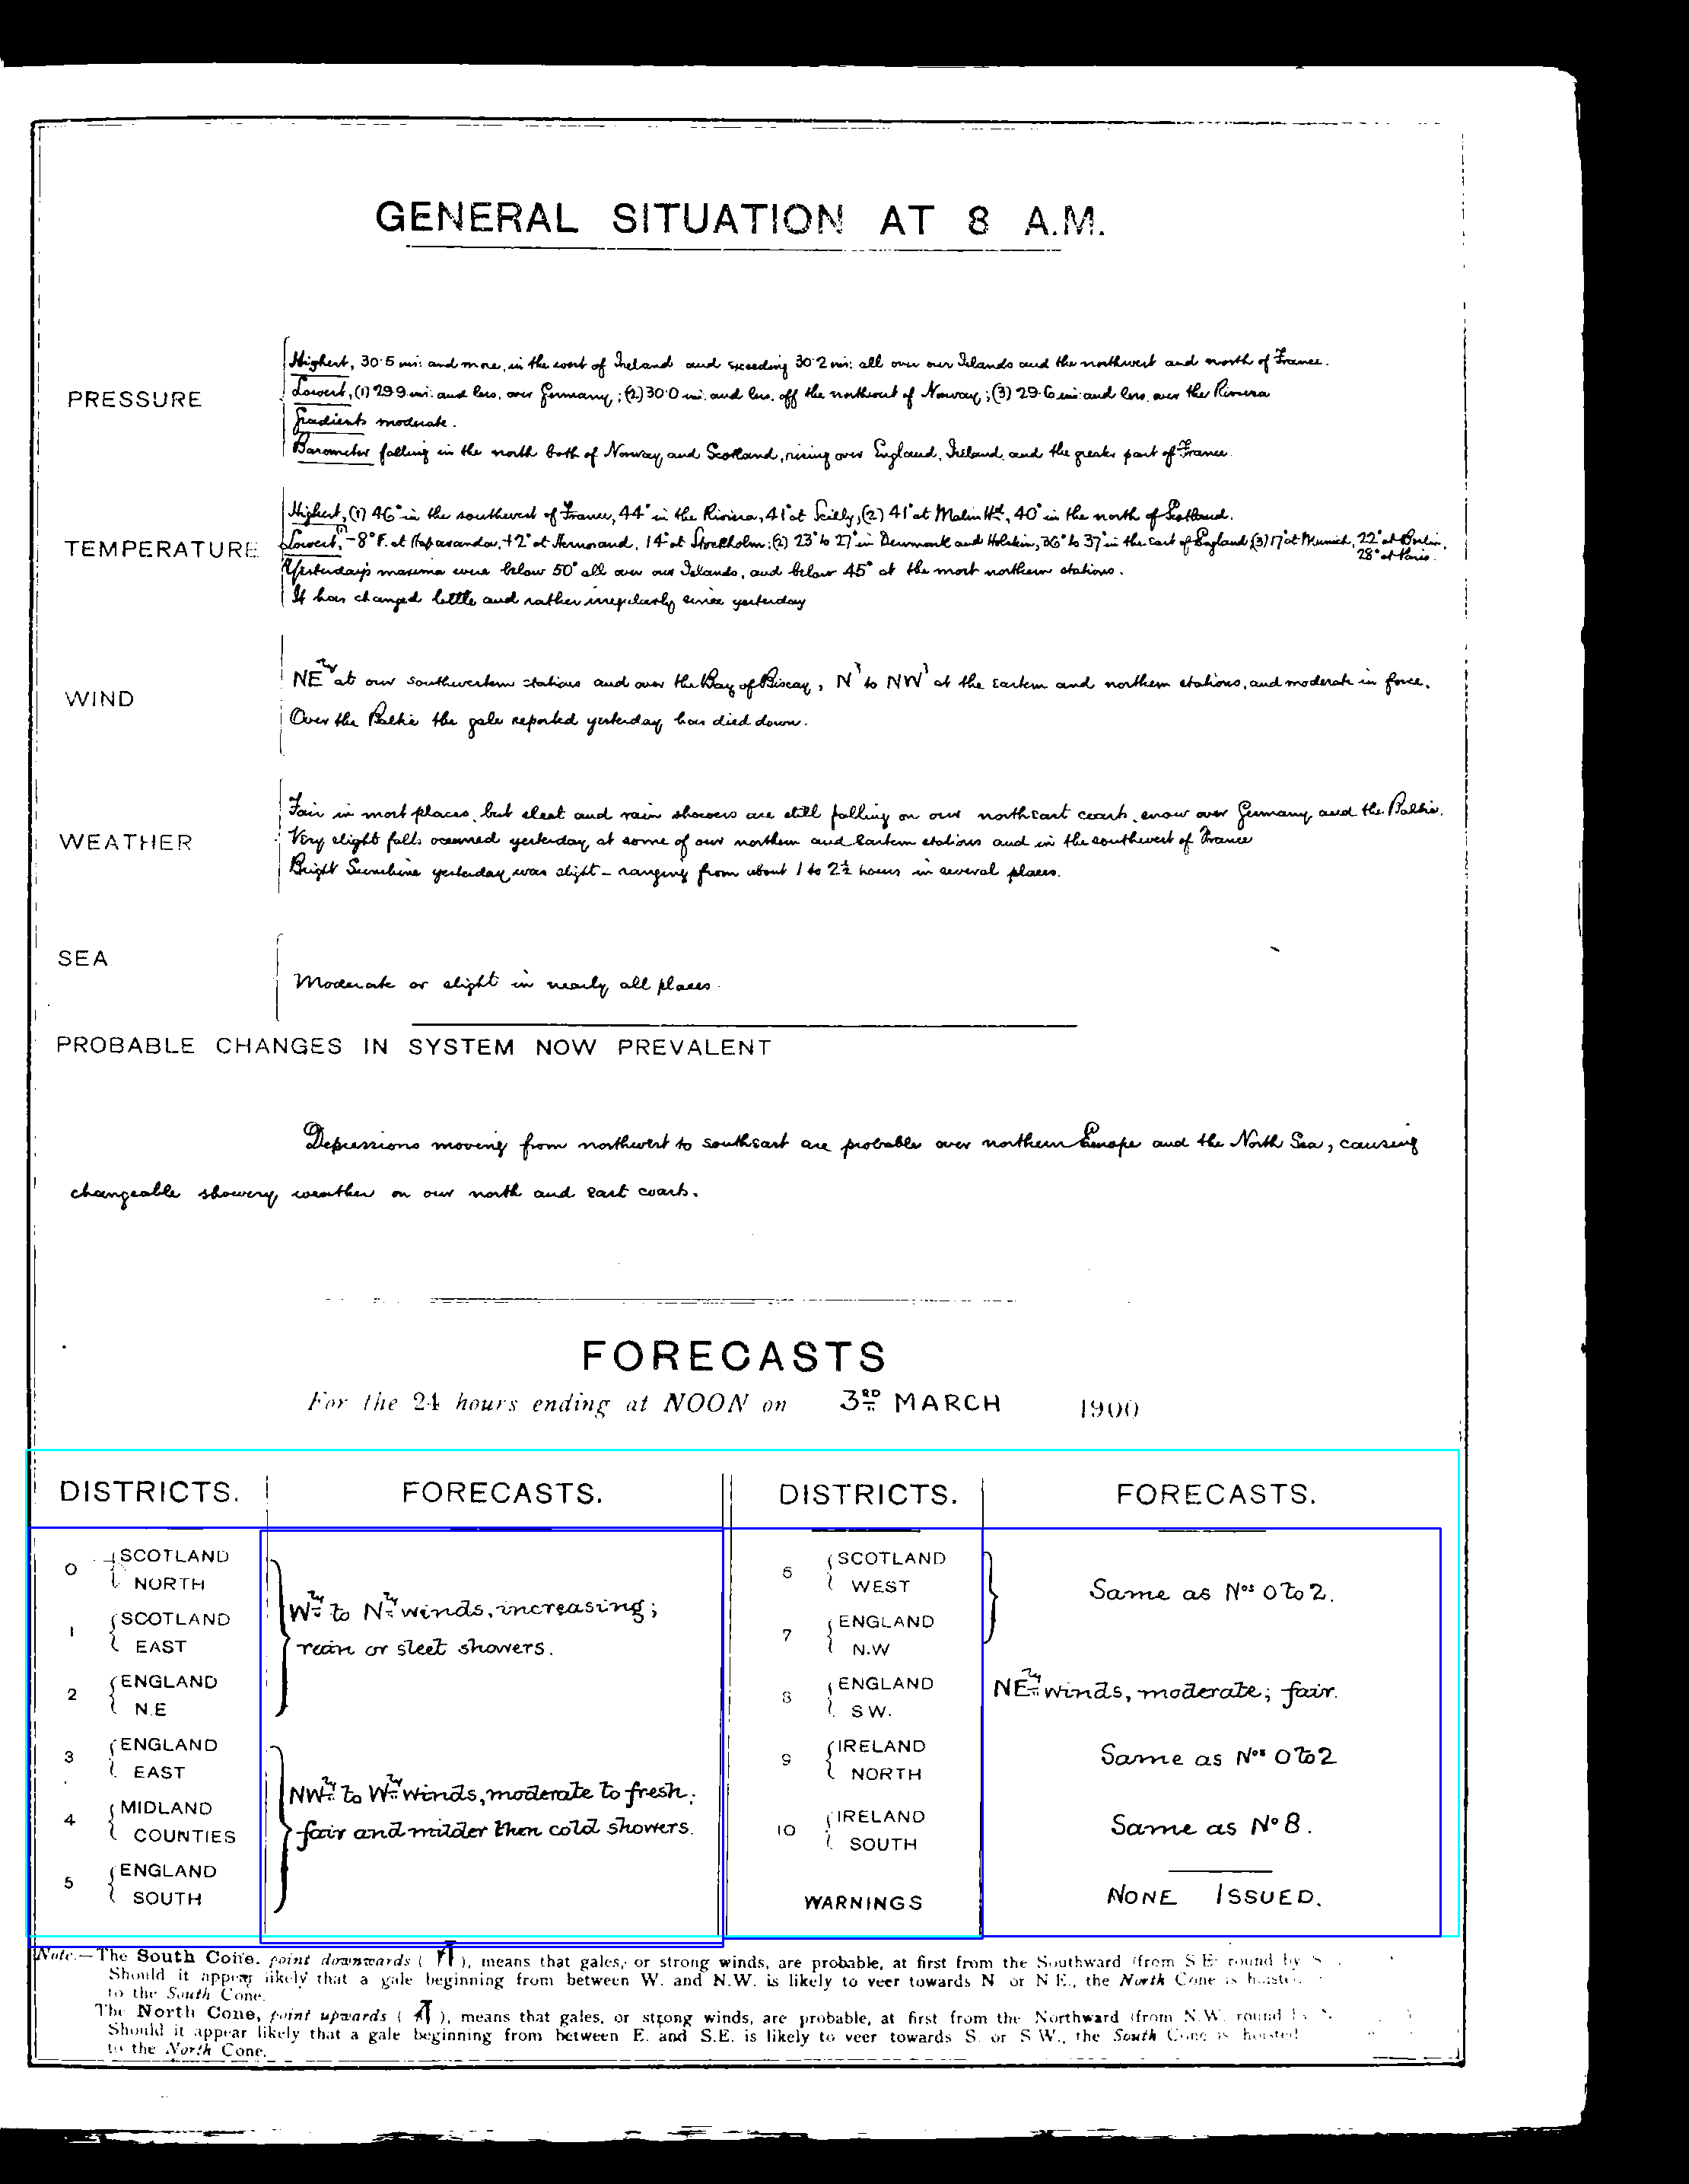

In [68]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)
color = 255

for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(exclude_cells_not_merged):
    put_box(image,box,(color,0,color)) # Green
    
for box in list(filter_seg_cells_new):
    put_box(image,box,(color,0,0)) # Green
    
for box in list(filter_considered_cells_new2):
    put_box(image,box,(0,0,color)) # Green
    
# for box in list(filter_considered_cells_new):
#     put_box(image,box,(0,0,color)) # Green
    
im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/9.segmented_error_cells.jpg")
im_pil  

In [69]:
if len(filter_seg_cells_new)>0:
    new_corrected_excluded_cells, not_corrected_cells = classify_error_cells(filter_seg_cells_new, tables, masks[1], average_cordinates,0.7)
    filter_seg_cells_new, _  = find_overlapped_cell(new_corrected_excluded_cells,filter_seg_cells_new, average_cordinates)
else:
    new_corrected_excluded_cells = []
    not_corrected_cells = []

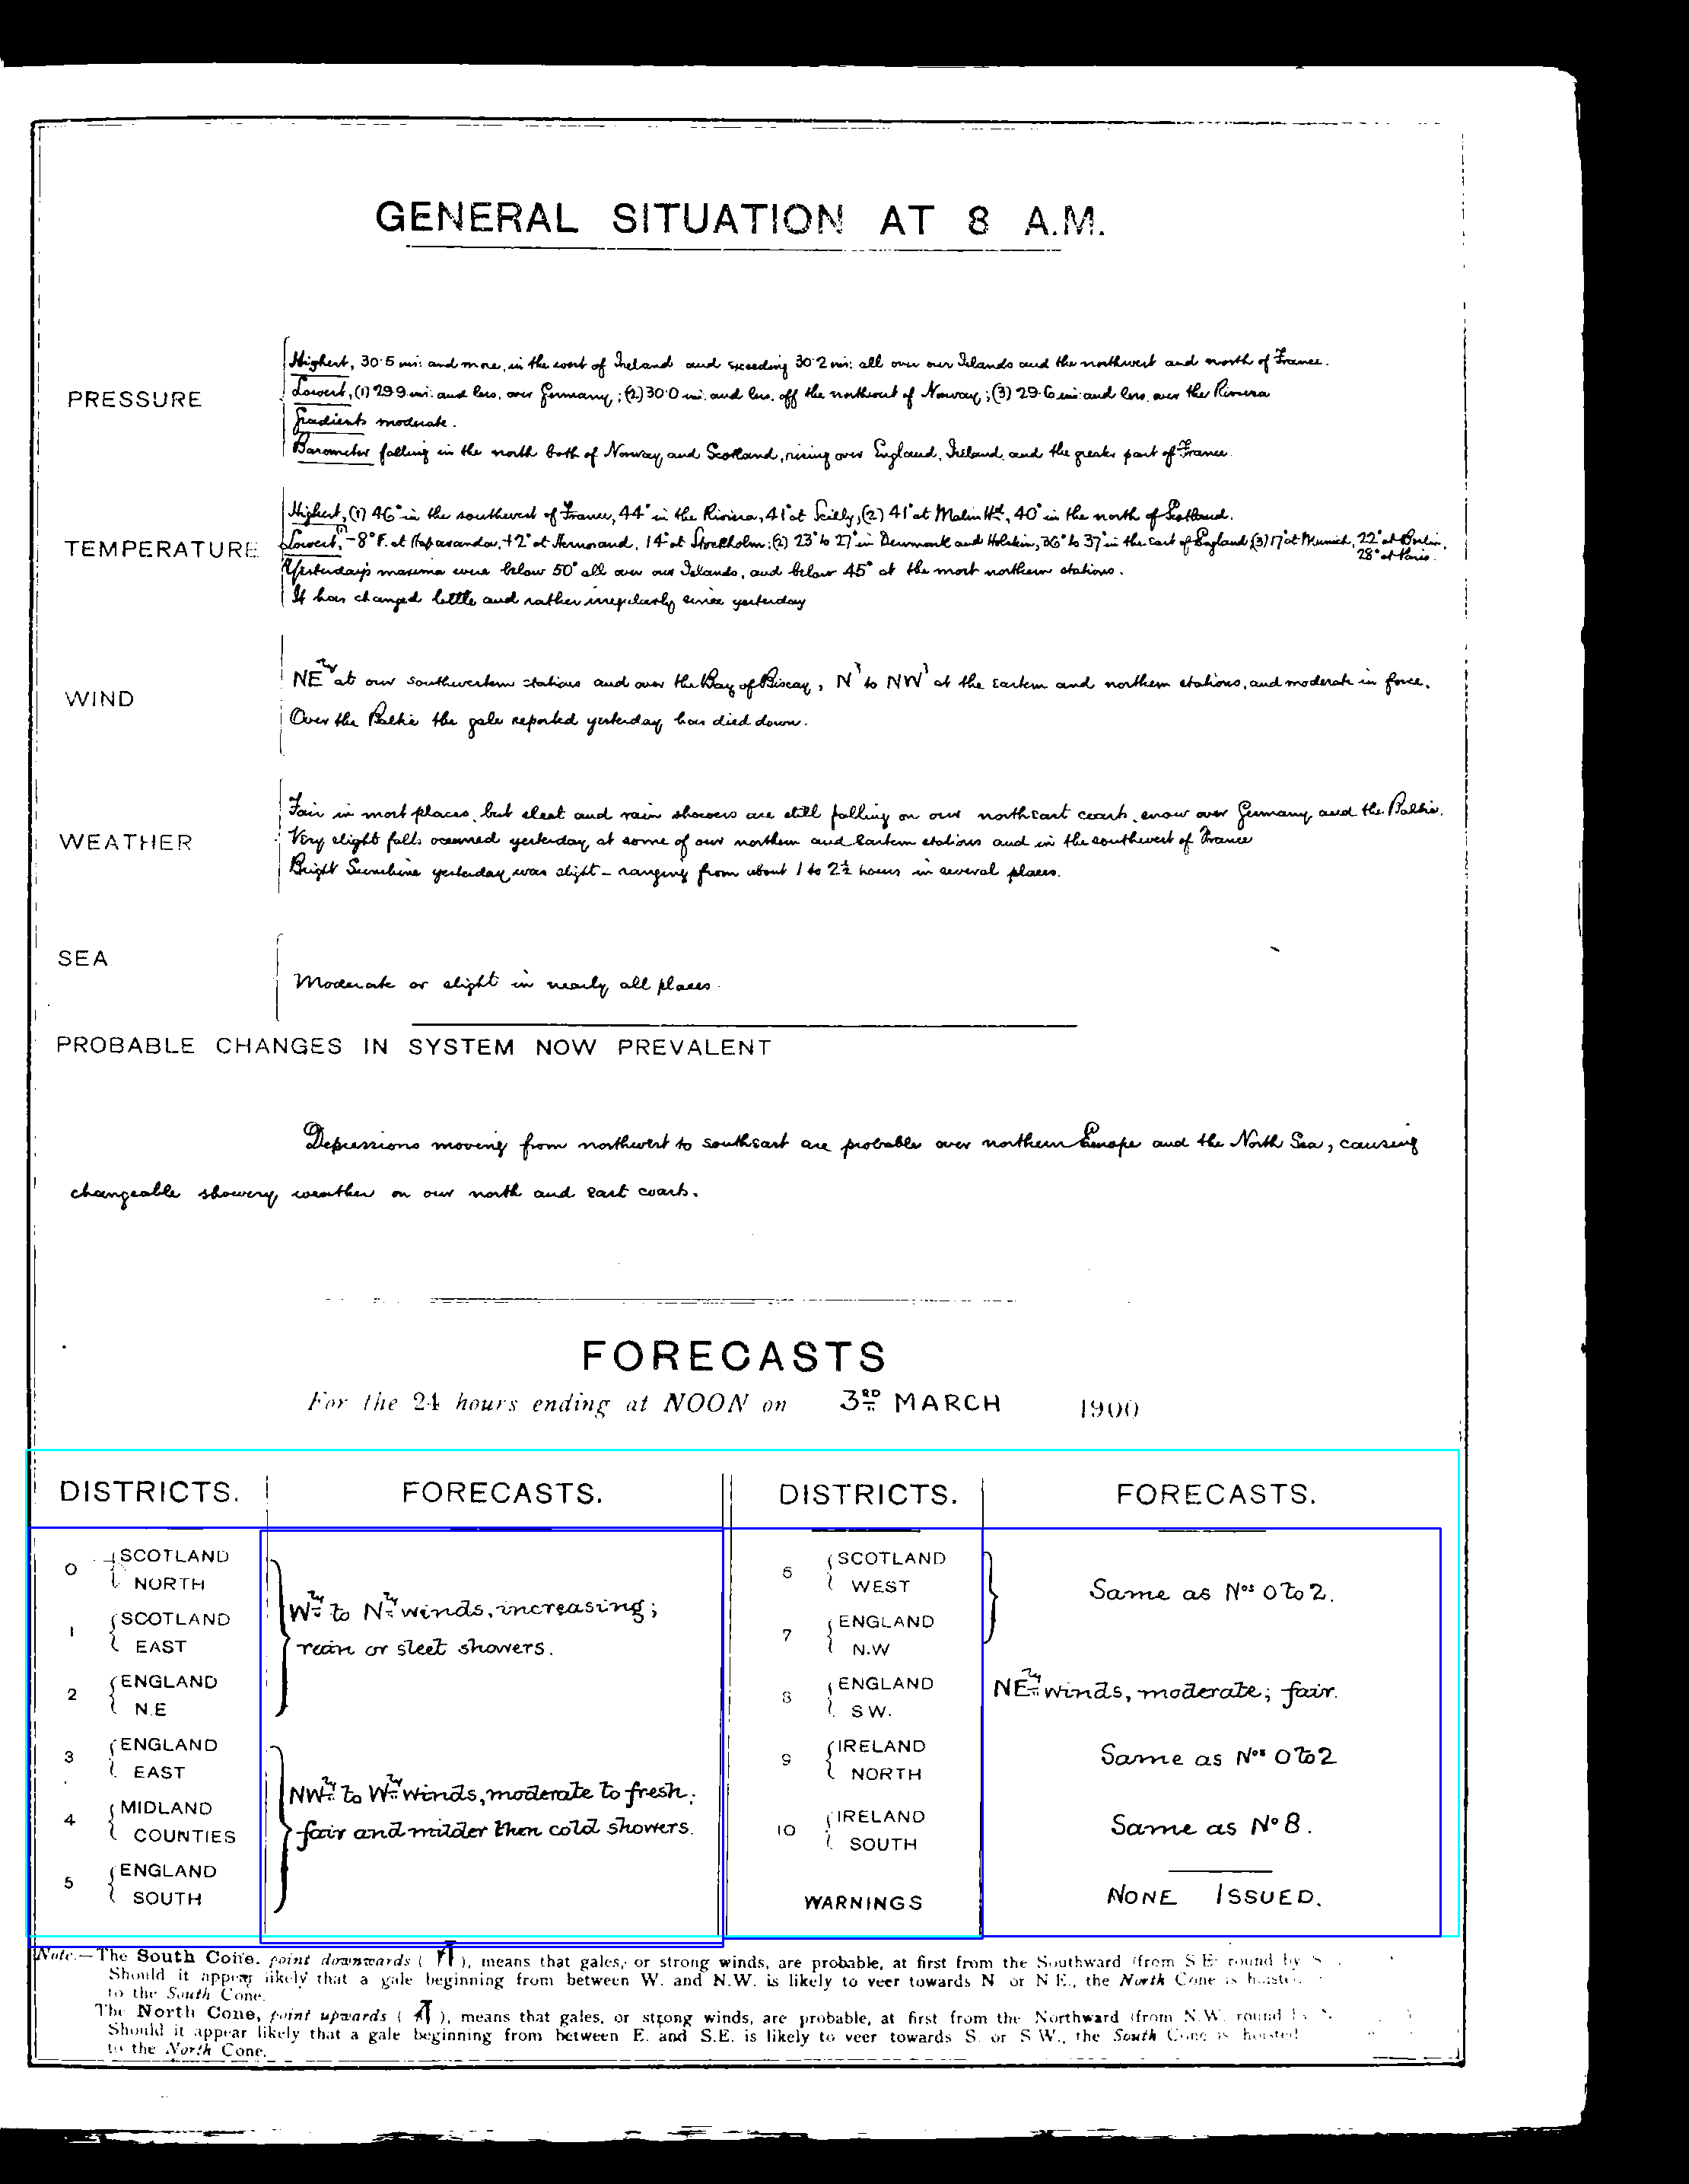

In [70]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)
color = 255

for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(exclude_cells_not_merged):
    put_box(image,box,(color,0,color)) # Green
    
for box in list(filter_seg_cells):
    put_box(image,box,(color,0,0)) # Green
    
for box in list(filter_considered_cells_new2):
    put_box(image,box,(0,0,color)) # Green
    
for box in list(new_corrected_excluded_cells):
    put_box(image,box,(0,color,0)) # Green
    
im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/9.segmented_error_cells.jpg")
im_pil  

In [71]:
considered_cells = filter_considered_cells_new2+new_corrected_excluded_cells

In [72]:
if len(exclude_cells_not_merged)>0:
    new_corrected_excluded_cells, not_corrected_cells = classify_error_cells(exclude_cells_not_merged, tables, masks[1], average_cordinates,0.7)
    exclude_cells_not_merged_new, _  = find_overlapped_cell(considered_cells+new_corrected_excluded_cells,exclude_cells_not_merged, average_cordinates)
else:
    new_corrected_excluded_cells = []
    exclude_cells_not_merged_new = []

In [73]:
exclude_cells_not_merged = merge_cells(exclude_cells_not_merged_new+filter_seg_cells_new, tables, average_cordinates)

In [74]:
exclude_cells_not_merged,large_cells_n =filter_overlapped_cell_final(exclude_cells_not_merged, average_cordinates)
exclude_cells_not_merged,large_cells_n = find_overlapped_cell_final(large_cells_n, exclude_cells_not_merged, average_cordinates)

In [75]:
exclude_cells_not_merged = merge_cells(exclude_cells_not_merged+large_cells_n, tables, average_cordinates)

exclude_cells_not_merged, large_cells_n =filter_overlapped_cell_final(exclude_cells_not_merged, average_cordinates)
exclude_cells_not_merged,large_cells_n = find_overlapped_cell_final(large_cells_n, exclude_cells_not_merged, average_cordinates)

In [76]:
valid_seg_cells =filter_overlapped_cell(considered_cells+new_corrected_excluded_cells, average_cordinates)

In [77]:
valid_seg_cells, valid_large_cells_n =filter_overlapped_cell_final(valid_seg_cells, average_cordinates)

In [78]:
valid_large_cells_n, valid_seg_cells = find_overlapped_cell_final(valid_seg_cells, valid_large_cells_n, average_cordinates)

In [79]:
exclude_cells_merged = merge_cells(exclude_cells_not_merged+large_cells_n, tables, average_cordinates)

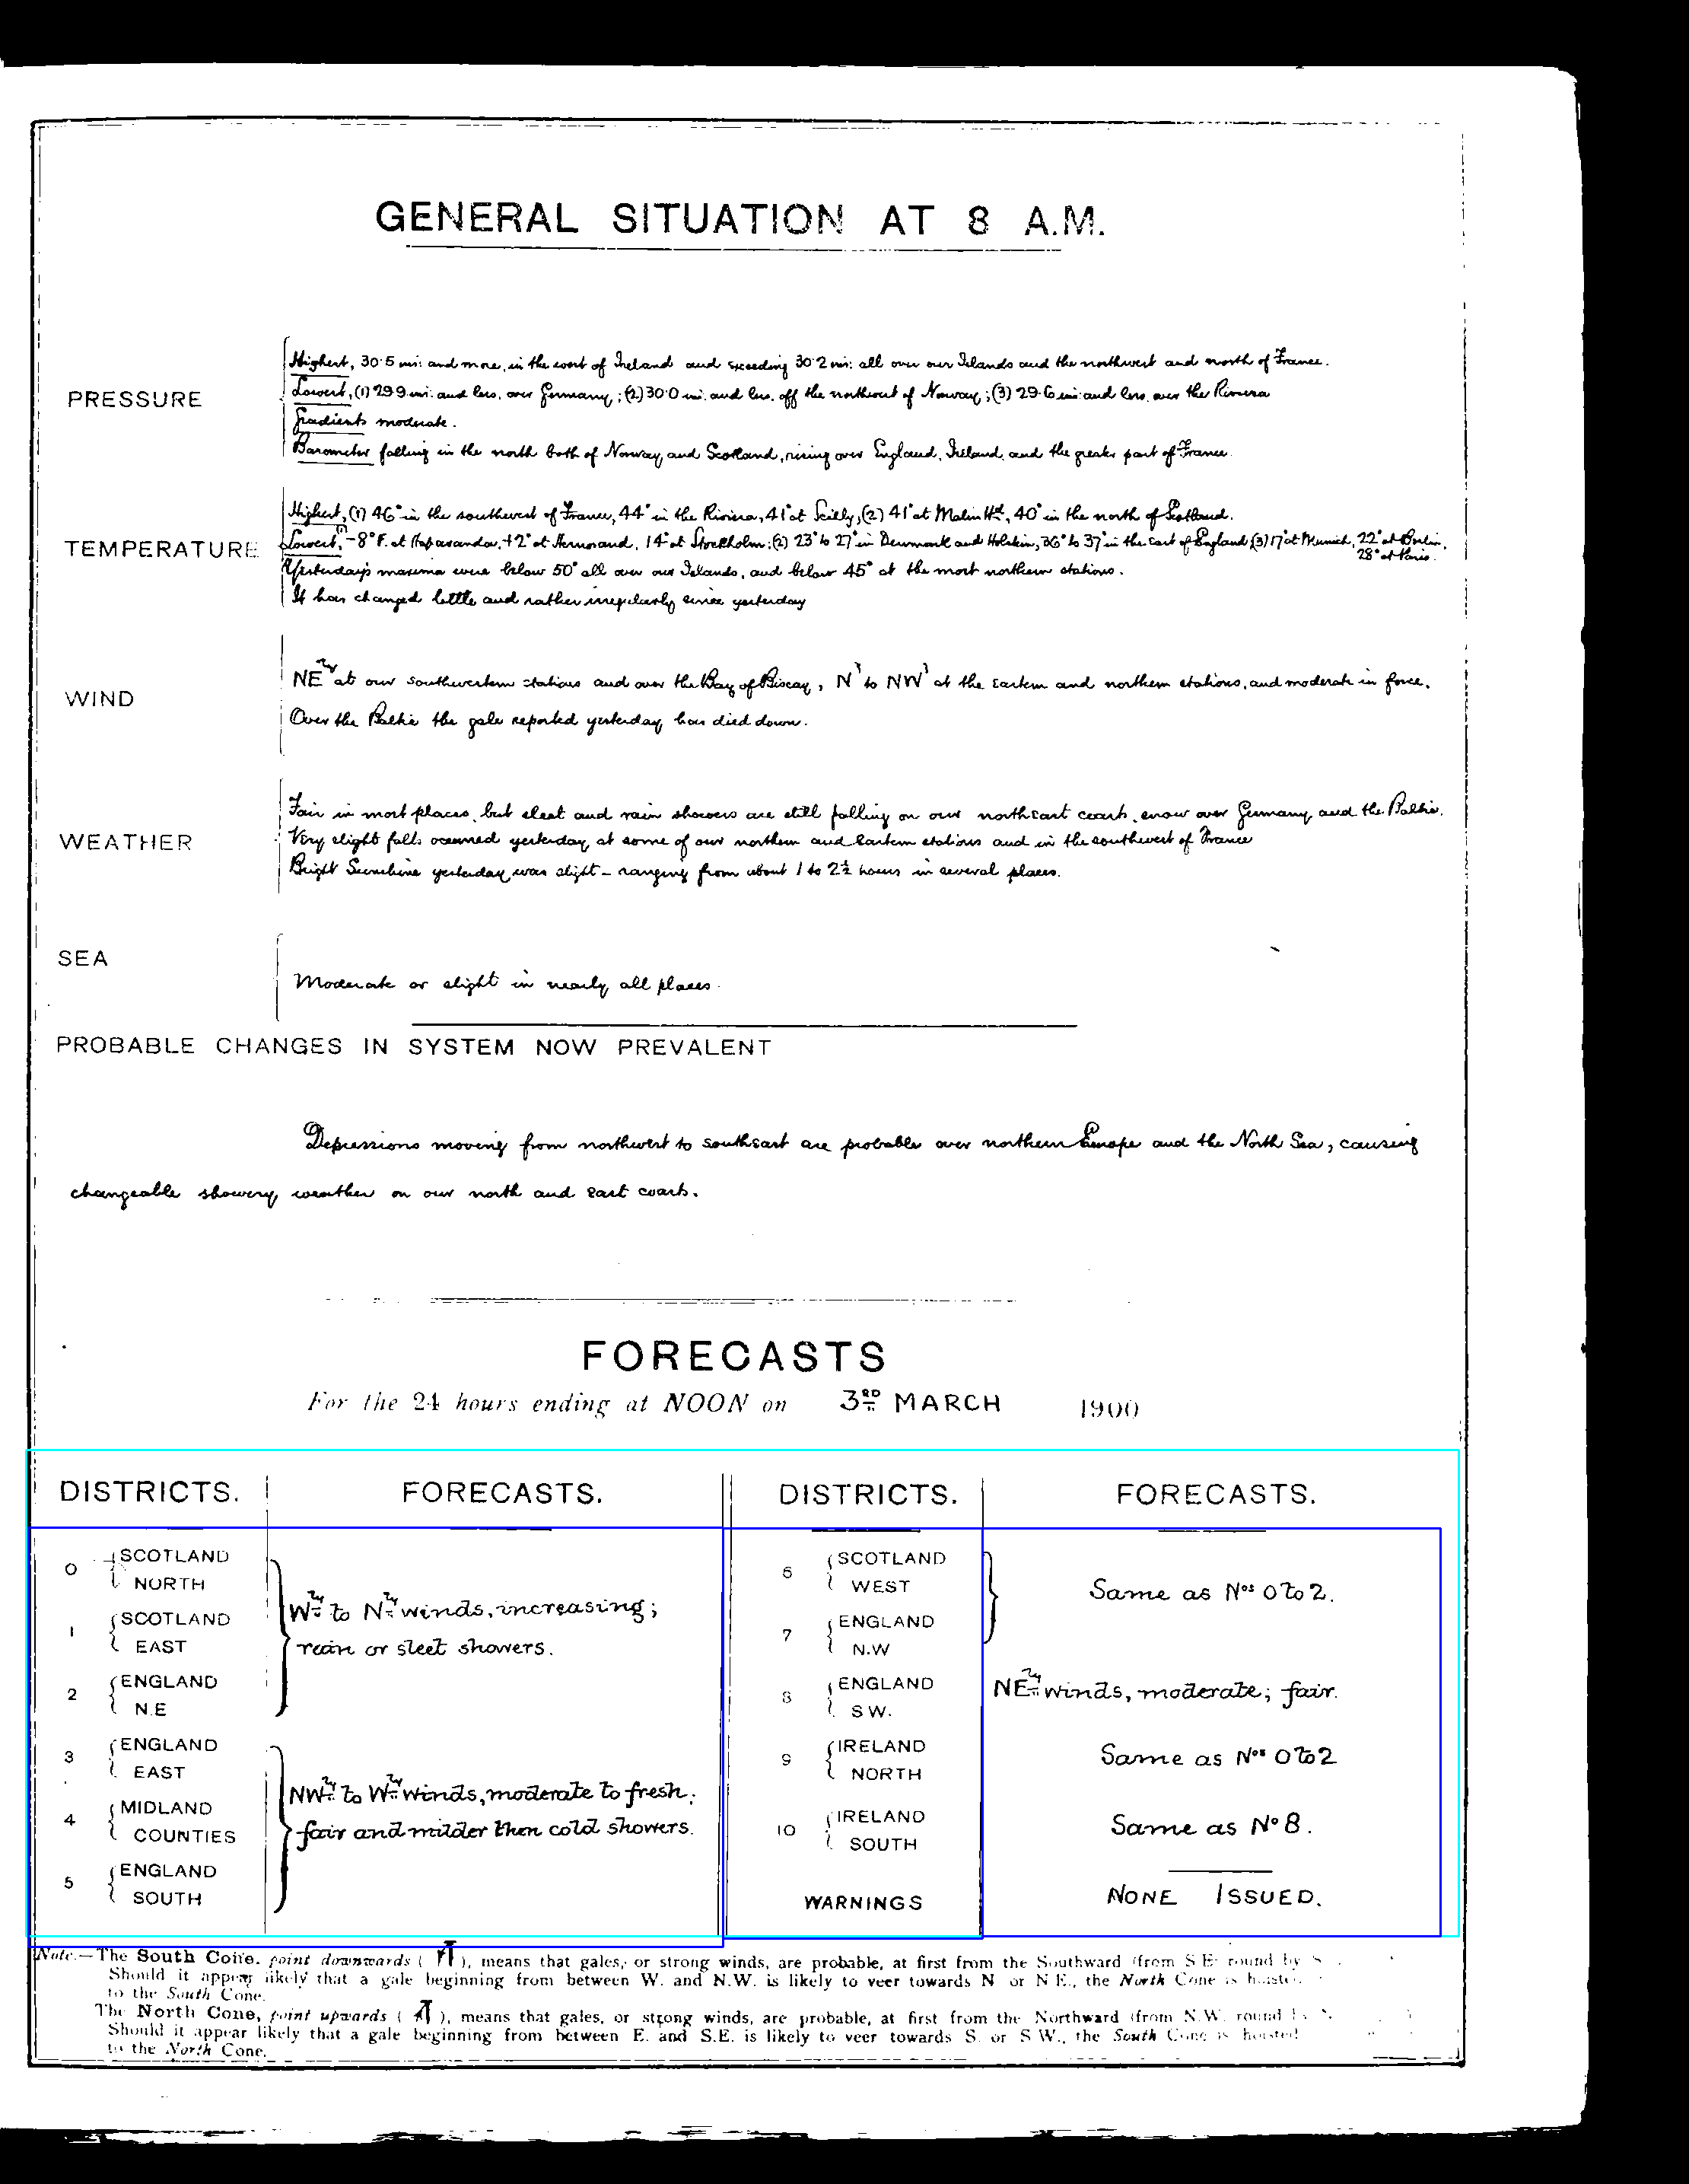

In [80]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)
color = 255

for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(exclude_cells_not_merged):
    put_box(image,box,(color,0,color)) # Green
    
for box in list(large_cells_n):
    put_box(image,box,(color,0,0)) # Green
    
for box in list(valid_seg_cells):
    put_box(image,box,(0,0,color)) # Green
    
for box in list(valid_large_cells_n):
    put_box(image,box,(0,color,0)) # Green
    
im_pil = Image.fromarray(image)
# im_pil.save(f"{outdirectory}/{filename}/10.error_corrected_segmented_cells.jpg")
im_pil  

In [62]:
neighbouring_cells, y_cords, x_cords = get_x_y_neighbour_cells(exclude_cells, tables, average_cordinates)

Row 259 - Cells: [690, 259, 907, 346, 1]


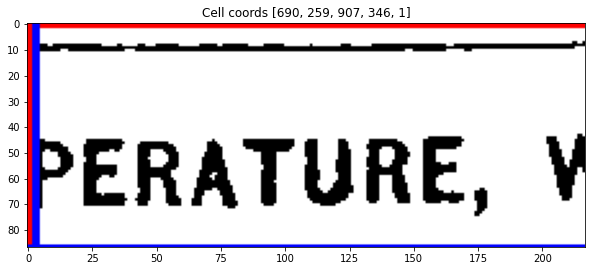

Row 259 - Cells: [907, 259, 1139, 346, 1]


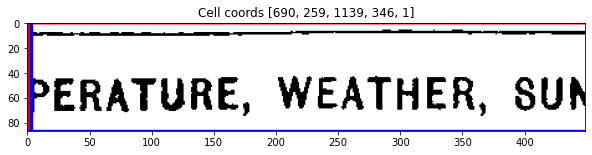

Row 259 - Cells: [1139, 259, 1604, 346, 1]


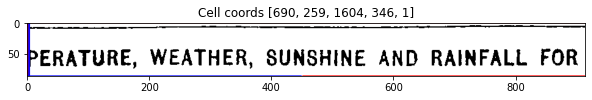

Row 259 - Cells: [1604, 259, 1791, 346, 1]


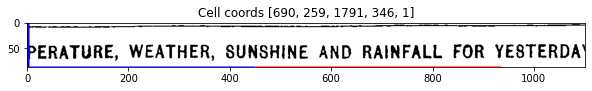

Row 259 - Cells: [1791, 259, 1935, 346, 1]


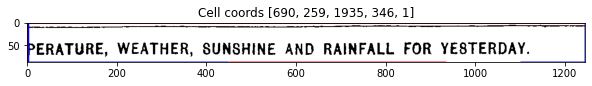

Row 346 - Cells: [1139, 346, 1604, 469, 1]


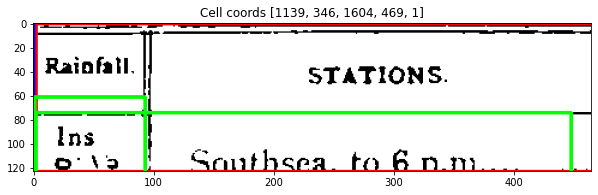

Row 346 - Cells: [1604, 346, 1791, 469, 1]


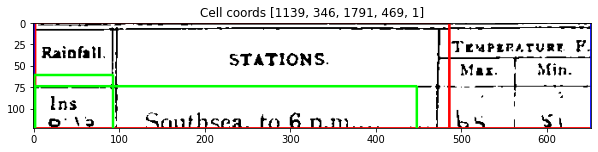

Row 469 - Cells: [276, 469, 690, 806, 1]


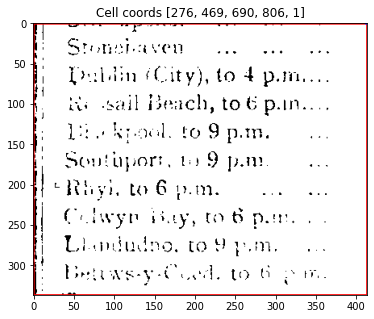

Row 469 - Cells: [1139, 469, 1604, 806, 1]


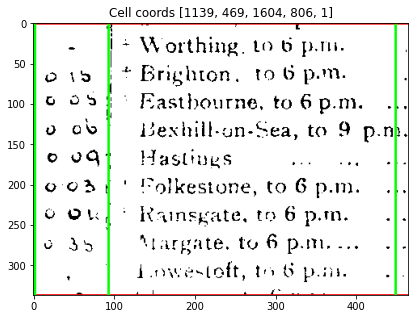

Row 806 - Cells: [276, 806, 690, 907, 1]


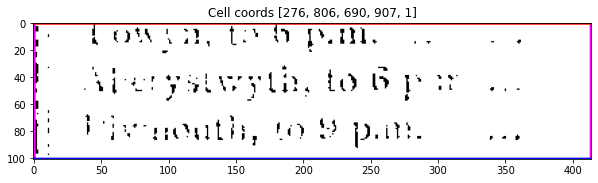

Row 806 - Cells: [1139, 806, 1604, 907, 1]


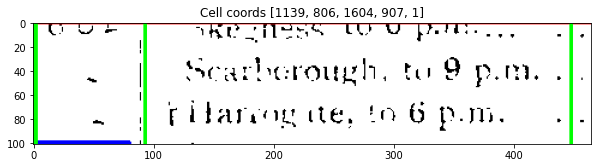

Row 806 - Cells: [1604, 806, 1791, 907, 1]


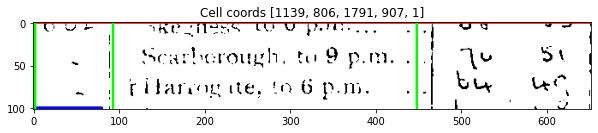

Row 806 - Cells: [1791, 806, 1935, 907, 1]


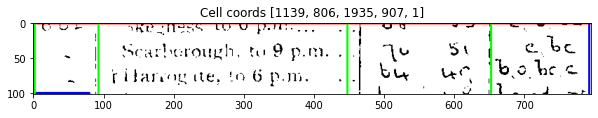

Row 806 - Cells: [1935, 806, 2159, 907, 1]


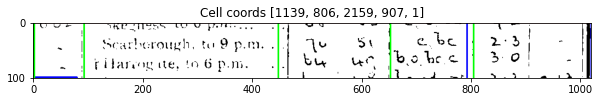

Row 907 - Cells: [1139, 907, 1604, 1016, 1]


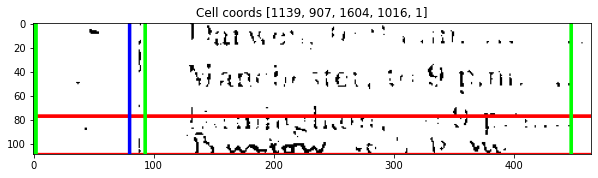

Row 907 - Cells: [1604, 907, 1791, 1016, 1]


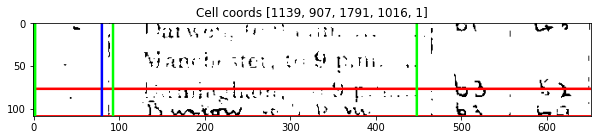

Row 907 - Cells: [1791, 907, 1935, 1016, 1]


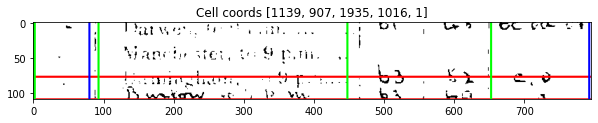

Row 907 - Cells: [1935, 907, 2159, 1016, 1]


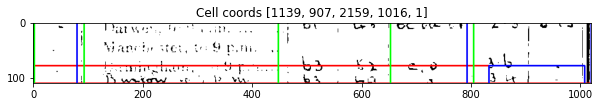

Row 984 - Cells: [274, 984, 529, 1169, 2]


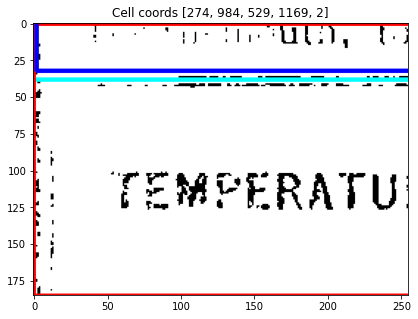

Row 984 - Cells: [529, 984, 843, 1169, 2]


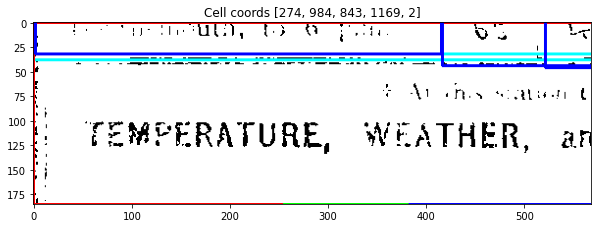

Row 984 - Cells: [843, 984, 1082, 1169, 2]


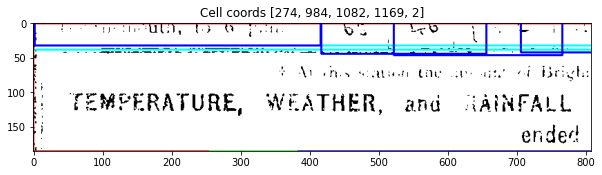

Row 984 - Cells: [1082, 984, 1574, 1169, 2]


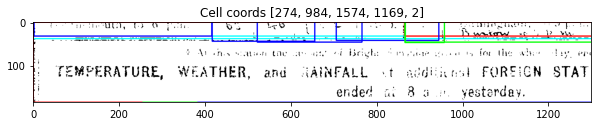

Row 984 - Cells: [1574, 984, 1754, 1169, 2]


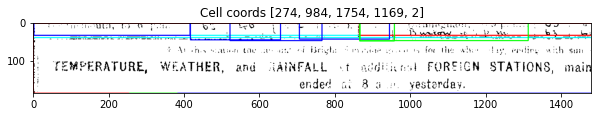

Row 984 - Cells: [1754, 984, 1972, 1169, 2]


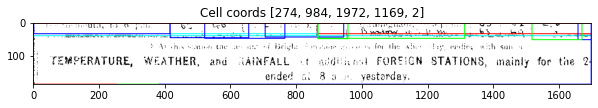

Row 1169 - Cells: [274, 1169, 529, 1233, 2]


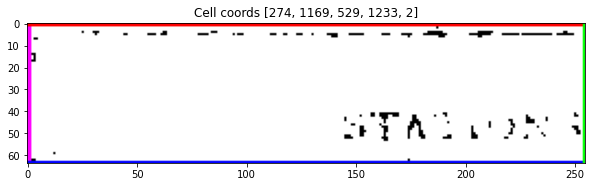

Row 1479 - Cells: [529, 1479, 843, 1542, 2]


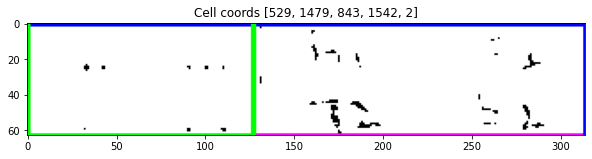

Row 1479 - Cells: [843, 1479, 1082, 1542, 2]


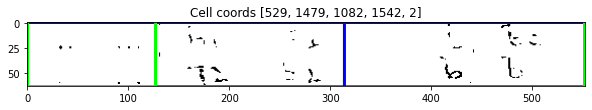

Row 1542 - Cells: [274, 1542, 529, 1663, 2]


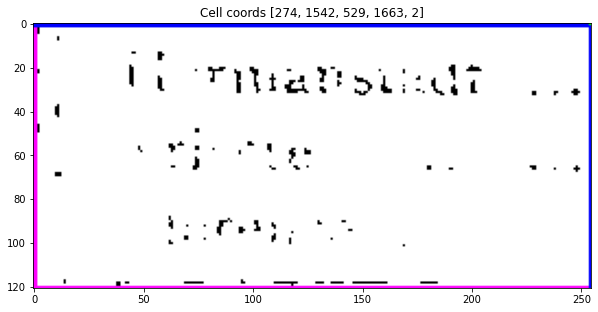

Row 1973 - Cells: [1440, 1973, 1783, 2179, 3]


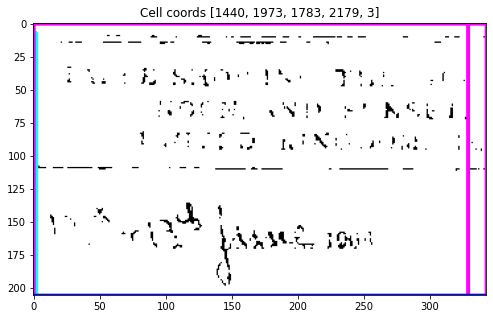

Row 1973 - Cells: [1783, 1973, 2043, 2179, 3]


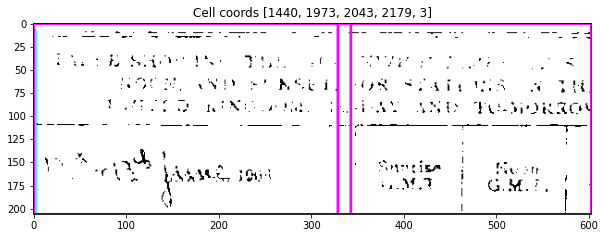

In [63]:
x_y_neighbouring_cells_dict = {}

for yid in neighbouring_cells:
    cells = neighbouring_cells[yid]

    x_neighbours = cells[1]

    tid =x_neighbours[0][4]

    avg_x, avg_y = average_cordinates[tid]

    # print(yid,y_neighbours,x_neighbours,tid, average_cordinates[tid])

    # find x_neighbours
    ncells = []
    imagedraw = []
    next_cell_begin = True
    starting_cell = []
    
    y_neighbours = []
    for y_nid in cells[0]:
        if abs(y_nid - yid) < (avg_y + avg_y * 0.2): #Filter column neighbour ids
            y_neighbours.append(y_nid)

    for xid, xcell in enumerate(x_neighbours):      #Filter row neighbour cells
        # Either split the cell or merge to begining cell
        if next_cell_begin:
            starting_cell = list(xcell)
        elif abs(starting_cell[2]-xcell[0])<avg_x*0.01:
            starting_cell[2] = xcell[2]
            
        print(f'Row {yid} - Cells: {xcell}')
        display_cells([starting_cell],image)

        # check next cell distance
        if (xid+1)<len(x_neighbours):
            next_cell = x_neighbours[xid+1]
            if abs(next_cell[0]-xcell[2])<avg_x*0.01:
                next_cell_begin = False
            else:
                ncells.append(starting_cell)
                starting_cell = []
                next_cell_begin = True
        elif len(x_neighbours)==1:
            ncells.append(starting_cell)
            starting_cell = []

    if len(starting_cell)>0:
        ncells.append(starting_cell)

#     print(x_neighbours,'---',ncells)   
    x_y_neighbouring_cells_dict[yid] = (y_neighbours, ncells)

In [64]:
x_y_neighbouring_cells_dict[685], avg_y

KeyError: 685

In [66]:
neighbours = []
if len(x_y_neighbouring_cells_dict)>0:
    for yid in x_y_neighbouring_cells_dict:
        ynid, xnid = x_y_neighbouring_cells_dict[yid]
        above_cells = []
        cur_cells = []
        below_cells = []
        for y_n in ynid:
            if y_n < yid:
                above_cells = x_y_neighbouring_cells_dict[y_n][1]
            else:
                cur_cells = xnid
                if y_n > yid:
                    below_cells = x_y_neighbouring_cells_dict[y_n][1]

        print(f'============{yid}================== \nAbove cells:{above_cells} \nCurrent cells: {xnid} \nBelow cells: {below_cells}')

        for cur_cell2 in xnid:
            xc0,yc0,xc1,yc1,tid = cur_cell2[0:5]
            avg_x, avg_y = average_cordinates[tid]
            cur_neigh = []
            for cur_cell_a in above_cells:
                xa0,ya0,xa1,ya1,tid_a = cur_cell_a[0:5]
                cell_a = [xa0,ya0,xa1,ya1]
                cell_b = [xc0,ya0,xc1,ya1]
                
                if tsa.how_much_contained(cell_a,cell_b)>0.5:
                    cur_neigh.append(cur_cell_a)  
                    print(f'1- {cell_a}, {cell_b}')
                elif tsa.how_much_contained(cell_b,cell_a)>0.5:
                    cur_neigh.append(cur_cell_a)
                    print(f'2- {cell_a}, {cell_b}')
                    
            cur_neigh.append(cur_cell2)
            for cur_cell_b in below_cells:
                xb0,yb0,xb1,yb1,tid_b = cur_cell_b[0:5]
                cell_a = [xc0,yc0,xc1,yc1]
                cell_b = [xb0,yc0,xb1,yc1]
                
                if tsa.how_much_contained(cell_a,cell_b)>0.5:
                    cur_neigh.append(cur_cell_b)  
                    print(f'3- {cell_a}, {cell_b}')
                elif tsa.how_much_contained(cell_b,cell_a)>0.5:
                    cur_neigh.append(cur_cell_b)
                    print(f'4- {cell_a}, {cell_b}')
                    
            neighbours.append(cur_neigh)

#         for cur_cell2 in above_cells:
#             tid = cur_cell2[4]
#             croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
#             plt.rcParams["figure.figsize"] = (10,5)
#             plt.imshow(croppedimage_full)
# #             plt.title(f'corrected cell of {cur_cell2} {average_cordinates[tid]}, x-dist: {abs(cur_cell2[0]-cur_cell2[2])}, y-dist: {abs(cur_cell2[1]-cur_cell2[3])}')
#             plt.show() 

#         for cur_cell2 in xnid:
#             tid = cur_cell2[4]
#             croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
#             plt.rcParams["figure.figsize"] = (10,5)
#             plt.imshow(croppedimage_full)
# #             plt.title(f'corrected cell of {cur_cell2} {average_cordinates[tid]}, x-dist: {abs(cur_cell2[0]-cur_cell2[2])}, y-dist: {abs(cur_cell2[1]-cur_cell2[3])}')
#             plt.show()       

#         for cur_cell2 in below_cells:
#             tid = cur_cell2[4]
#             croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
#             plt.rcParams["figure.figsize"] = (10,5)
#             plt.imshow(croppedimage_full)
# #             plt.title(f'corrected cell of {cur_cell2} {average_cordinates[tid]}, x-dist: {abs(cur_cell2[0]-cur_cell2[2])}, y-dist: {abs(cur_cell2[1]-cur_cell2[3])}')
#             plt.show() 

============259================== 
Above cells:[] 
Current cells: [[690, 259, 1935, 346, 1]] 
Below cells: [[1139, 346, 1791, 469, 1]]
3- [690, 259, 1935, 346], [1139, 259, 1791, 346]
============346================== 
Above cells:[[690, 259, 1935, 346, 1]] 
Current cells: [[1139, 346, 1791, 469, 1]] 
Below cells: [[276, 469, 690, 806, 1], [1139, 469, 1604, 806, 1]]
1- [690, 259, 1935, 346], [1139, 259, 1791, 346]
3- [1139, 346, 1791, 469], [1139, 346, 1604, 469]
============469================== 
Above cells:[[1139, 346, 1791, 469, 1]] 
Current cells: [[276, 469, 690, 806, 1], [1139, 469, 1604, 806, 1]] 
Below cells: []
1- [1139, 346, 1791, 469], [1139, 346, 1604, 469]
============806================== 
Above cells:[] 
Current cells: [[276, 806, 690, 907, 1], [1139, 806, 2159, 907, 1]] 
Below cells: [[1139, 907, 2159, 1016, 1]]
3- [1139, 806, 2159, 907], [1139, 806, 2159, 907]
============907================== 
Above cells:[[276, 806, 690, 907, 1], [1139, 806, 2159, 907, 1]] 
Current 

In [67]:
merged_cells = []
for neigh_cells in neighbours:
    if len(neigh_cells)>1:
        cell = neigh_cells[0]
        end_cell =  neigh_cells[-1]
        print(cell, end_cell)
        cur_cell2 = list(cell)
        cur_cell2[3] = end_cell[3]
        merged_cells.append(cur_cell2)
    else:
        merged_cells+=neigh_cells

[690, 259, 1935, 346, 1] [1139, 346, 1791, 469, 1]
[690, 259, 1935, 346, 1] [1139, 469, 1604, 806, 1]
[1139, 346, 1791, 469, 1] [1139, 469, 1604, 806, 1]
[1139, 806, 2159, 907, 1] [1139, 907, 2159, 1016, 1]
[1139, 806, 2159, 907, 1] [1139, 907, 2159, 1016, 1]


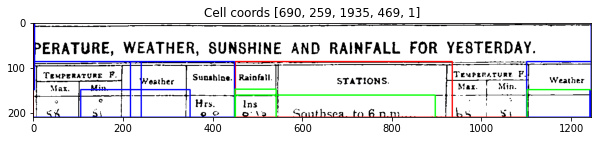

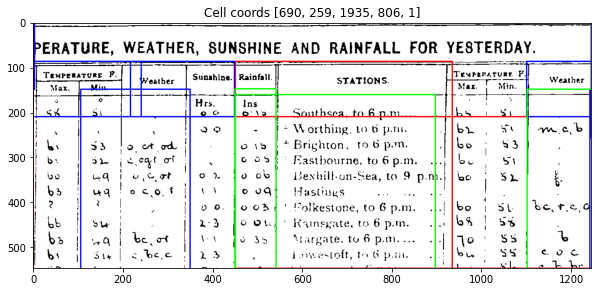

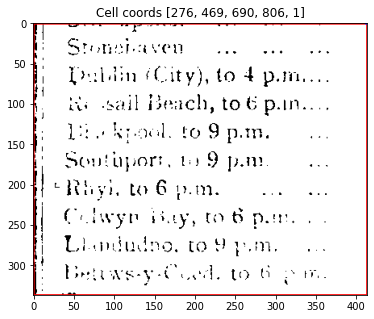

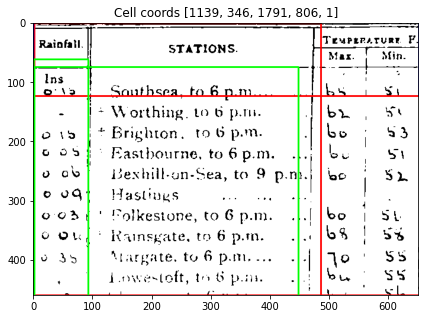

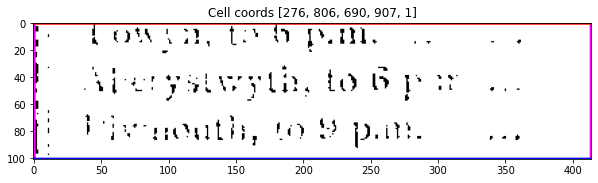

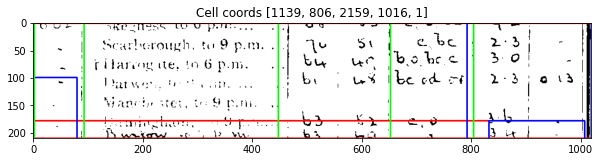

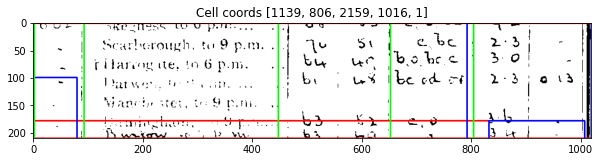

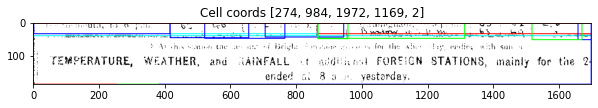

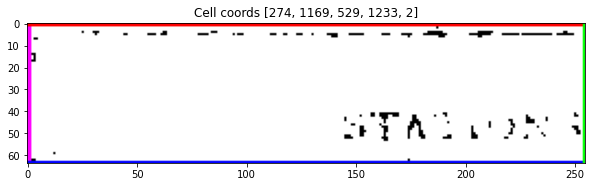

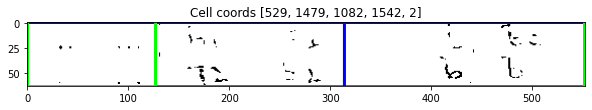

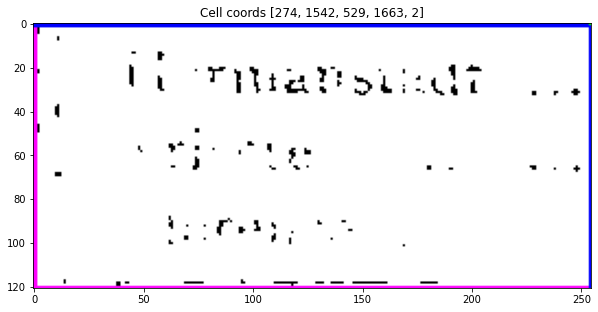

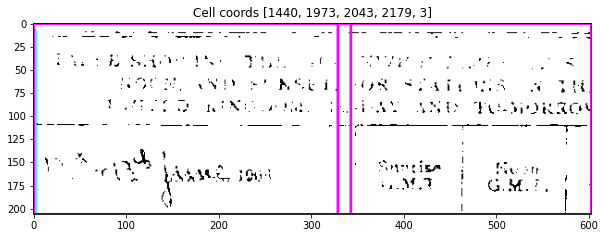

In [68]:
display_cells(merged_cells,image)

In [224]:
def get_neighbouring_coord(cells, tables, average_cordinates):
    new_excluded_cells_pred = []
    
    for cell in cells:
        new_excluded_cells_pred.append(cell[0:5])
    
    x = torch.IntTensor(new_excluded_cells_pred)
    value, index = x[:,1].sort()

    y_cords = {}
    for idx, i in zip(index,value):
        idx, i = (int(idx),int(i))

        if i not in y_cords:
            y_cords[i]=[]
        y_cords[i].append(idx)
        
    y_cords_new = {}
    for i in y_cords:
        mat = [new_excluded_cells_pred[idx] for idx in y_cords[i]]
        mat = torch.IntTensor(mat)
        _, index = mat[:,0].sort()

        mat_new = []

        for idx in index:
            cell =  mat[int(idx)].tolist()
            mat_new.append(cell)  #cells and its table index
        if len(mat_new)>0:
            y_cords_new[i]=mat_new
    
    new_excluded_cells_pred = []
    
    for cell in cells:
        new_excluded_cells_pred.append(cell[0:5])
    
    x = torch.IntTensor(new_excluded_cells_pred)
    value, index = x[:,0].sort()
    
    x_cords = {}
    for idx, i in zip(index,value):
        idx, i = (int(idx),int(i))

        if i not in x_cords:
            x_cords[i]=[]
        x_cords[i].append(idx)

    x_cords_new = {}
    for i in x_cords:
        mat = [new_excluded_cells_pred[idx] for idx in x_cords[i]]
        mat = torch.IntTensor(mat)
        _, index = mat[:,0].sort()

        mat_new = []

        for idx in index:
            cell =  mat[int(idx)].tolist()
            mat_new.append(cell)  #cells and its table index
        if len(mat_new)>0:
            x_cords_new[i]=mat_new

    return y_cords_new, x_cords_new

In [75]:
x_y_neighbouring_cells_dict = {}

for yid in neighbouring_cells:
    cells = neighbouring_cells[yid]

    y_neighbours = cells[0]
    x_neighbours = cells[1]

    tid =x_neighbours[0][4]

    avg_x, avg_y = average_cordinates[tid]

    # print(yid,y_neighbours,x_neighbours,tid, average_cordinates[tid])

    # find x_neighbours
    ncells = []
    imagedraw = []
    next_cell_begin = True
    starting_cell = []

    for xid, xcell in enumerate(x_neighbours):    

        # Either split the cell or merge to begining cell
        if next_cell_begin:
            starting_cell = list(xcell)
        else:
            starting_cell[2] = xcell[2]

        # check next cell distance
        if (xid+1)<len(x_neighbours):
            next_cell = x_neighbours[xid+1]
            if abs(next_cell[0]-xcell[2])<(avg_x/3):
                next_cell_begin = False
            else:
                ncells.append(starting_cell)
                starting_cell = []
                next_cell_begin = True
        elif len(x_neighbours)==1:
            ncells.append(starting_cell)
            starting_cell = []

    if len(starting_cell)>0:
        ncells.append(starting_cell)

#     print(x_neighbours,'---',ncells)   
    x_y_neighbouring_cells_dict[yid] = (y_neighbours, ncells)


y_neighbours_new = {}
if len(x_y_neighbouring_cells_dict)>2:
    yids = list(x_y_neighbouring_cells_dict.keys())
count = 0
y_neighbours = {}
cur_list = []

for i, j in zip(yids[:-1],yids[1:]):
    if count == 0:  # First index
        cur_list.append(i)        
    if (j-i) < avg_y:
        cur_list.append(j)
    else:
        y_neighbours[cur_list[0]] = cur_list
        cur_list = [j]
    count+=1

if cur_list[0] not in y_neighbours:
    y_neighbours[cur_list[0]] = cur_list

for yid in y_neighbours:
    for yidn in y_neighbours[yid]:
        y_neighbours_new[yidn] = y_neighbours[yid]
#         if yidn not in y_neighbours:
#             print(y_neighbours[yid])

# combine x and y neighbours v2
error_merged_cells = []
neighbours = []
if len(x_y_neighbouring_cells_dict)>0:
for yid in x_y_neighbouring_cells_dict:
    ynid, xnid = x_y_neighbouring_cells_dict[yid]
    above_cells = []
    cur_cells = []
    below_cells = []
    for y_n in ynid:
        if y_n < yid:
            above_cells = x_y_neighbouring_cells_dict[y_n][1]
        else:
            cur_cells = xnid
            if y_n > yid:
                below_cells = x_y_neighbouring_cells_dict[y_n][1]

    print(f'============{yid}================== \nAbove cells:{above_cells} \nCurrent cells: {xnid} \nBelow cells: {below_cells}')

    for cur_cell2 in xnid:
        xc0,yc0,xc1,yc1,tid = cur_cell2[0:5]
        avg_x, avg_y = average_cordinates[tid]
        cur_neigh = []
        for cur_cell_a in above_cells:
            xa0,ya0,xa1,ya1,tid_a = cur_cell_a[0:5]
            if abs(ya1-yc0)<avg_y*0.1 and abs(xa0-xc0)<avg_x*0.1 : #10% of average size
                cur_neigh.append(cur_cell_a)
        cur_neigh.append(cur_cell2)
        for cur_cell_b in below_cells:
            xb0,yb0,xb1,yb1,tid_b = cur_cell_b[0:5]
            if abs(yb0-yc1)<avg_y*0.1 and abs(xb0-xc0)<avg_x*0.1 : #10% of average size
                cur_neigh.append(cur_cell_b)
        neighbours.append(cur_neigh)

    for cur_cell2 in above_cells:
        tid = cur_cell2[4]
        croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
        plt.rcParams["figure.figsize"] = (10,5)
        plt.imshow(croppedimage_full)
        plt.title(f'above cell {cur_cell2}')
        plt.show() 

    for cur_cell2 in xnid:
        tid = cur_cell2[4]
        croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
        plt.rcParams["figure.figsize"] = (10,5)
        plt.imshow(croppedimage_full)
        plt.title(f'current cell {cur_cell2}')
        plt.show()       

    for cur_cell2 in below_cells:
        tid = cur_cell2[4]
        croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
        plt.rcParams["figure.figsize"] = (10,5)
        plt.imshow(croppedimage_full)
        plt.title(f'below cell {cur_cell2}')
        plt.show() 


merged_cells = []
for neigh_cells in neighbours:
if len(neigh_cells)>1:
    cell = neigh_cells[0]
    end_cell =  neigh_cells[-1]
    print(cell, end_cell)
    cur_cell2 = list(cell)
    cur_cell2[3] = end_cell[3]
    merged_cells.append(cur_cell2)
else:
    merged_cells+=neigh_cells

return merged_cells

IndentationError: expected an indented block (3650106351.py, line 51)

[[614, 685, 749, 857, 920, 985, 1046, 1108, 1499, 1589],
 [[1349, 685, 1526, 749, 1]]]

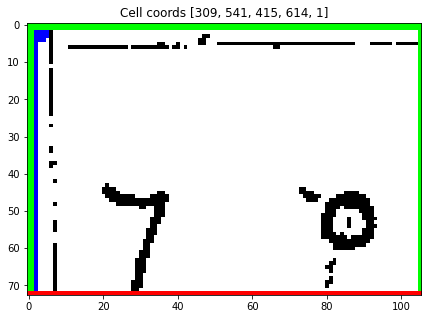

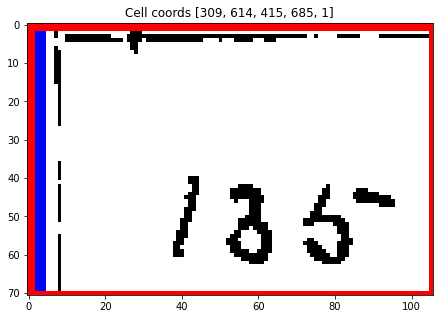

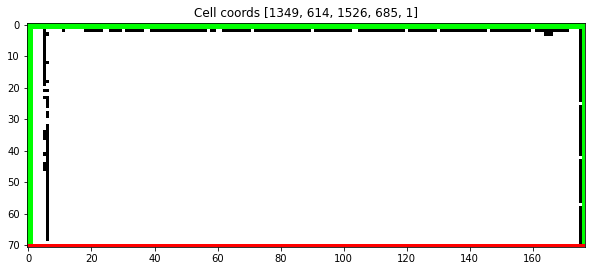

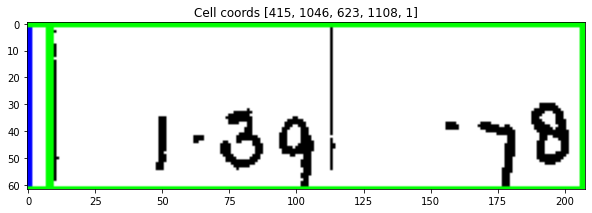

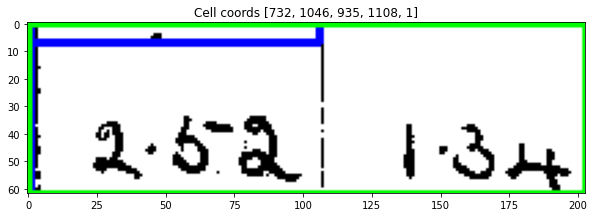

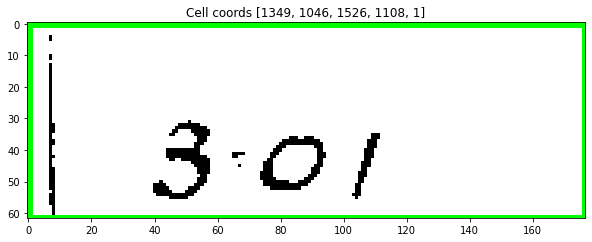

In [292]:
display_cells([[309, 541, 415, 614, 1],[309, 614, 415, 685, 1], [1349, 614, 1526, 685, 1],[415, 1046, 623, 1108, 1], [732, 1046, 935, 1108, 1], [1349, 1046, 1526, 1108, 1]])

In [74]:
filter_merged_cells =filter_overlapped_cell(merged_cells, average_cordinates)

In [276]:
def find_overlapped_cell_final(corrected_cells, cells_pred, average_cordinates):
    new_cells_pred = []
    for i, box in enumerate(cells_pred):
        count=0       
        xi = abs(box[2]-box[0])
        yi = abs(box[3]-box[1])
        
        for j, cells in enumerate(corrected_cells): 
            xj = abs(cells[2]-cells[0])
            yj = abs(cells[3]-cells[1])
            
            if tsa.how_much_contained(cells,box)>0.5:
#                     if (max(yj,yi)/min(yj,yi))<3 and (max(xj,xi)/min(xj,xi))<3:
                count+=1
                if xj < xi:
                    cells[0] = box[0]  
                    cells[2] = box[2]
                if yj < yi:
                    cells[1] = box[1]  
                    cells[3] = box[3]
                corrected_cells[j] = cells
                break
                
            elif tsa.how_much_contained(box, cells)>0.5:
#                     if (max(yj,yi)/min(yj,yi))<3 and (max(xj,xi)/min(xj,xi))<3:
                count+=1
                if xj < xi:
                    cells[0] = box[0]  
                    cells[2] = box[2]
                if yj < yi:
                    cells[1] = box[1]  
                    cells[3] = box[3]
                corrected_cells[j] = cells
                break
                    
        if count==0:
            new_cells_pred.append(box)
    return new_cells_pred, corrected_cells

In [72]:
not_overlapped_seg_cells, all_valid_cells_new = find_overlapped_cell_final(all_valid_cells, seg_cells, average_cordinates)

In [73]:
not_overlapped_exclude_cells, all_valid_cells_new = find_overlapped_cell_final(all_valid_cells_new+not_overlapped_seg_cells, not_corrected_excluded_cells, average_cordinates)

NameError: name 'not_corrected_excluded_cells' is not defined

[[125, 457, 313, 544, 1],
 [623, 458, 733, 543, 1],
 [518, 457, 625, 541, 1],
 [732, 459, 835, 544, 1],
 [1247, 541, 1352, 614, 1],
 [517, 542, 624, 617, 1],
 [1140, 542, 1248, 615, 1],
 [1349, 541, 1526, 614, 1],
 [1036, 542, 1143, 616, 1],
 [131, 541, 310, 614, 1],
 [937, 542, 1036, 616, 1],
 [415, 542, 517, 615, 1],
 [623, 543, 733, 616, 1],
 [829, 541, 935, 614, 1],
 [733, 541, 837, 614, 1],
 [125, 614, 312, 685, 1],
 [623, 686, 733, 753, 1],
 [128, 686, 315, 753, 1],
 [128, 748, 315, 856, 1],
 [1140, 752, 1248, 862, 1],
 [127, 857, 313, 920, 1],
 [127, 920, 314, 986, 1],
 [1140, 920, 1248, 986, 1],
 [131, 984, 310, 1052, 1],
 [1247, 985, 1349, 1051, 1],
 [1141, 985, 1249, 1051, 1],
 [733, 992, 838, 1053, 1],
 [131, 1045, 310, 1109, 1],
 [1247, 1046, 1349, 1108, 1],
 [623, 1046, 733, 1108, 1],
 [1140, 1046, 1248, 1108, 1],
 [1247, 1108, 1349, 1176, 1],
 [1140, 1108, 1248, 1176, 1],
 [623, 1108, 733, 1176, 1],
 [1034, 1108, 1141, 1176, 1],
 [1034, 1175, 1141, 1242, 1],
 [732, 1175, 

In [71]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(all_valid_cells):
    put_box(image,box,(0,0,color)) # Blue
    
for box in list(not_overlapped_seg_cells):
    put_box(image,box,(0,color,0)) # Green
    
# # for box in list(blank_cells):
# #     put_box(image,box,(color,color,0)) # Green
    
for box in list(not_overlapped_exclude_cells):
    put_box(image,box,(color,0,0)) # Green

im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/10.table_cell_generation_valid_added.jpg")
im_pil  

NameError: name 'not_overlapped_seg_cells' is not defined

In [183]:
y_cords

{541: [[309, 541, 415, 614, 1]],
 614: [[309, 614, 415, 685, 1], [1349, 614, 1526, 685, 1]],
 685: [[1349, 685, 1526, 749, 1]],
 749: [[309, 749, 415, 857, 1],
  [415, 749, 517, 857, 1],
  [517, 749, 623, 857, 1],
  [623, 749, 732, 857, 1],
  [732, 749, 831, 857, 1],
  [1248, 749, 1349, 857, 1],
  [1349, 749, 1526, 857, 1]],
 857: [[309, 857, 415, 920, 1],
  [415, 857, 517, 920, 1],
  [517, 857, 623, 920, 1],
  [623, 857, 732, 920, 1],
  [732, 857, 831, 920, 1],
  [1248, 857, 1349, 920, 1],
  [1349, 857, 1526, 920, 1]],
 920: [[415, 920, 517, 985, 1],
  [517, 920, 623, 985, 1],
  [623, 920, 732, 985, 1],
  [732, 920, 831, 985, 1],
  [831, 920, 935, 985, 1],
  [935, 920, 1034, 985, 1],
  [1349, 920, 1526, 985, 1]],
 985: [[309, 985, 415, 1046, 1],
  [415, 985, 517, 1046, 1],
  [517, 985, 623, 1046, 1],
  [623, 985, 732, 1046, 1],
  [831, 985, 935, 1046, 1],
  [1349, 985, 1526, 1046, 1]],
 1046: [[415, 1046, 517, 1108, 1],
  [517, 1046, 623, 1108, 1],
  [732, 1046, 831, 1108, 1],
  [831,

In [180]:
x_y_neighbouring_cells_dict = {}
if len(not_corrected_excluded_cells)>2:
    neighbouring_cells, y_cords, x_cords = get_x_y_neighbour_cells(not_corrected_excluded_cells, tables, average_cordinates)

    for yid in neighbouring_cells:
        cells = neighbouring_cells[yid]

        y_neighbours = cells[0]
        x_neighbours = cells[1]

        tid =x_neighbours[0][4]

        avg_x, avg_y = average_cordinates[tid]

        # print(yid,y_neighbours,x_neighbours,tid, average_cordinates[tid])

        ncells = []
        imagedraw = []
        next_cell_begin = True
        starting_cell = []

        for xid, xcell in enumerate(x_neighbours):    

            # Either split the cell or merge to begining cell
            if next_cell_begin:
                starting_cell = list(xcell)
            else:
                starting_cell[2] = xcell[2]

            # check next cell distance
            if (xid+1)<len(x_neighbours):
                next_cell = x_neighbours[xid+1]
                if abs(next_cell[0]-xcell[2])<(avg_x/3):
                    next_cell_begin = False
                else:
                    ncells.append(starting_cell)
                    starting_cell = []
                    next_cell_begin = True
            elif len(x_neighbours)==1:
                ncells.append(starting_cell)
                starting_cell = []

        if len(starting_cell)>0:
            ncells.append(starting_cell)

    #     print(x_neighbours,'---',ncells)   
        x_y_neighbouring_cells_dict[yid] = (y_neighbours, ncells)
x_y_neighbouring_cells_dict

{541: ([541, 614, 749], [[309, 541, 415, 614, 1]]),
 614: ([541, 614, 749, 685],
  [[309, 614, 415, 685, 1], [1349, 614, 1526, 685, 1]]),
 685: ([614, 685, 749, 857], [[1349, 685, 1526, 749, 1]]),
 749: ([541, 614, 749, 857, 920, 685],
  [[309, 749, 831, 857, 1], [1248, 749, 1526, 857, 1]]),
 857: ([749, 857, 985, 920, 1046, 685],
  [[309, 857, 831, 920, 1], [1248, 857, 1526, 920, 1]]),
 920: ([749, 857, 920, 985, 1046, 1108],
  [[415, 920, 1034, 985, 1], [1349, 920, 1526, 985, 1]]),
 985: ([857, 985, 1108, 1175, 920, 1046],
  [[309, 985, 732, 1046, 1],
   [831, 985, 935, 1046, 1],
   [1349, 985, 1526, 1046, 1]]),
 1046: ([857, 920, 985, 1046, 1108, 1175, 1242],
  [[415, 1046, 623, 1108, 1],
   [732, 1046, 935, 1108, 1],
   [1349, 1046, 1526, 1108, 1]]),
 1108: ([1108, 985, 1175, 1242, 1308, 920, 1046],
  [[131, 1108, 623, 1175, 1],
   [732, 1108, 935, 1175, 1],
   [1349, 1108, 1526, 1175, 1]]),
 1175: ([985, 1108, 1175, 1242, 1308, 1369, 1046],
  [[309, 1175, 732, 1242, 1], [831, 1175

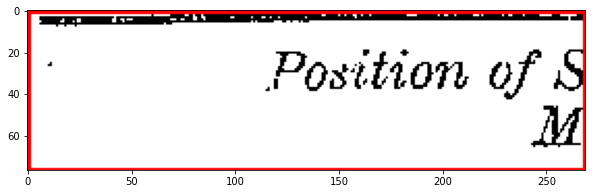

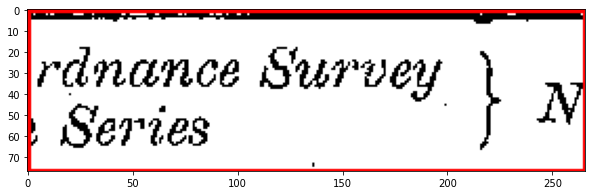

In [185]:
display_cells(y_cords[2088])

In [173]:
y_neighbours_new = {}
if len(x_y_neighbouring_cells_dict)>2:
    yids = list(x_y_neighbouring_cells_dict.keys())
    count = 0
    y_neighbours = {}
    cur_list = []

    for i, j in zip(yids[:-1],yids[1:]):
        if count == 0:  # First index
            cur_list.append(i)        
        if (j-i) < avg_y:
            cur_list.append(j)
        else:
            y_neighbours[cur_list[0]] = cur_list
            cur_list = [j]
        count+=1

    if cur_list[0] not in y_neighbours:
        y_neighbours[cur_list[0]] = cur_list

    for yid in y_neighbours:
        for yidn in y_neighbours[yid]:
            y_neighbours_new[yidn] = y_neighbours[yid]
    #         if yidn not in y_neighbours:
    #             print(y_neighbours[yid])

y_neighbours_new

{541: [541],
 614: [614, 685, 749],
 685: [614, 685, 749],
 749: [614, 685, 749],
 857: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 920: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 985: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 1046: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 1108: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 1175: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 1242: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 1308: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 1369: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 1438: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 1499: [857, 920, 985, 1046, 1108, 1175, 1242, 1308, 1369, 1438, 1499],
 1589: [1589],
 2088: [2088],
 2372: [2372]}

============541================== 
Above cells:[] 
Current cells: [[309, 541, 415, 614, 1]] 
Below cells: [[309, 749, 831, 857, 1], [1248, 749, 1526, 857, 1]]
2--541 before segmentation: [309, 541, 831, 857, 1] cur_corrected: []
-----Below-----

============614================== 
Above cells:[[309, 541, 415, 614, 1]] 
Current cells: [[309, 614, 415, 685, 1], [1349, 614, 1526, 685, 1]] 
Below cells: [[1349, 685, 1526, 749, 1]]
1 overlap score: 1.0 1.0
1--614 just above cell: [309, 541, 415, 614, 1], Current cell: [309, 614, 415, 685, 1], [309, 614, 415, 685, 1], 1.0
-----Above-----

1 overlap score: 0.0 0.0
2--614 before segmentation: [1349, 614, 1526, 749, 1] cur_corrected: []
-----Below-----

============685================== 
Above cells:[[309, 614, 415, 685, 1], [1349, 614, 1526, 685, 1]] 
Current cells: [[1349, 685, 1526, 749, 1]] 
Below cells: [[309, 857, 831, 920, 1], [1248, 857, 1526, 920, 1]]
1 overlap score: 0.0 0.0
1 overlap score: 1.0 1.0
1--685 just above cell: [1349, 614, 

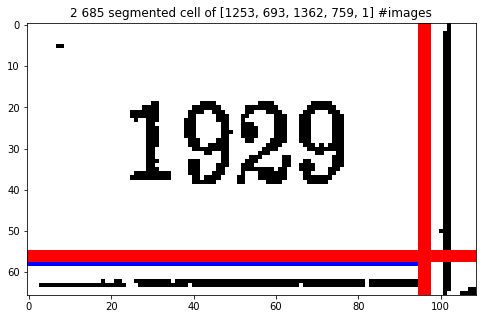

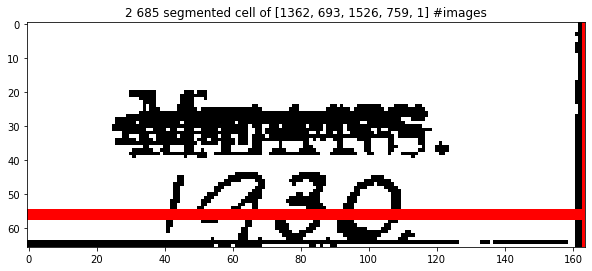

y:1.2093775262732418, x:2.3828571428571426


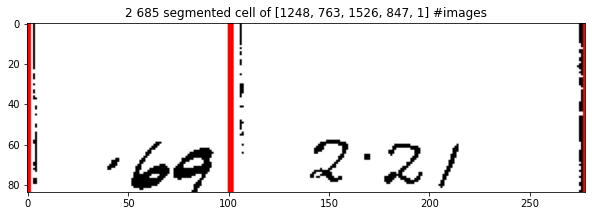

y:0.824575586095392, x:2.3828571428571426


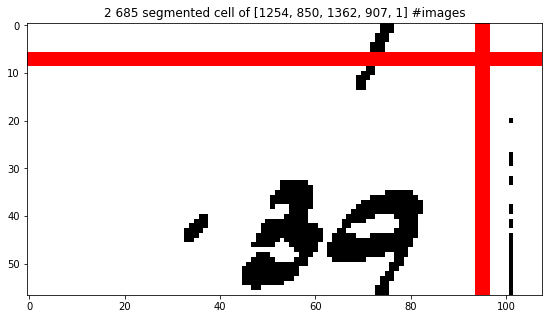

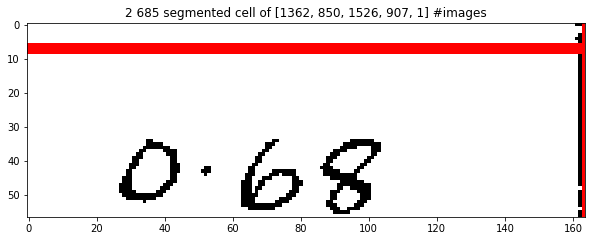

-----Below-----

============749================== 
Above cells:[[1349, 685, 1526, 749, 1]] 
Current cells: [[309, 749, 831, 857, 1], [1248, 749, 1526, 857, 1]] 
Below cells: [[415, 920, 1034, 985, 1], [1349, 920, 1526, 985, 1]]
1 overlap score: 0.0 0.0
2--749 before segmentation: [415, 749, 1034, 985, 1] cur_corrected: []
-----Below-----

1 overlap score: 1.0 0.6366906474820144
1--749 just above cell: [1349, 685, 1526, 749, 1], Current cell: [1248, 749, 1526, 857, 1], [1349, 749, 1526, 857, 1], 1.0
-----Above-----

2--749 before segmentation: [1349, 749, 1526, 985, 1] cur_corrected: []
-----Below-----

============857================== 
Above cells:[[1349, 685, 1526, 749, 1]] 
Current cells: [[309, 857, 831, 920, 1], [1248, 857, 1526, 920, 1]] 
Below cells: [[415, 1046, 623, 1108, 1], [732, 1046, 935, 1108, 1], [1349, 1046, 1526, 1108, 1]]
1 overlap score: 0.0 0.0
1 overlap score: 1.0 0.6366906474820144
1--857 just above cell: [1349, 685, 1526, 749, 1], Current cell: [1248, 857, 1526,

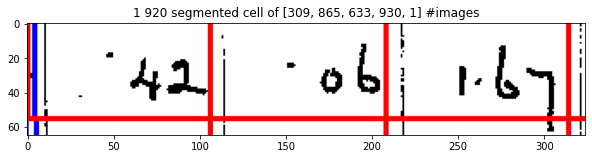

y:0.755860953920776, x:2.777142857142857


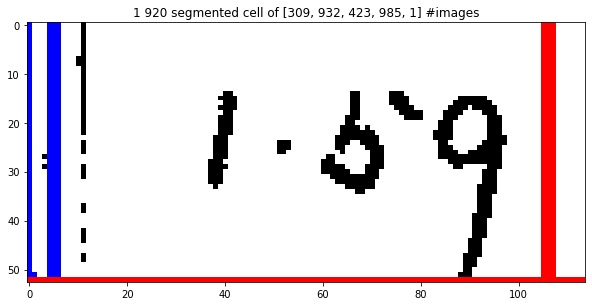

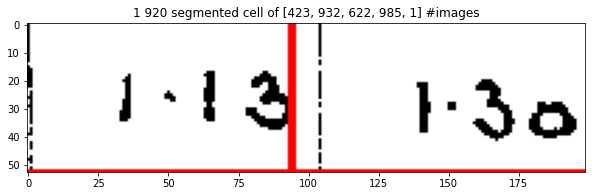

-----Above-----

1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
1 overlap score: 0.6366906474820144 1.0
1--920 just above cell: [1248, 857, 1526, 920, 1], Current cell: [1349, 920, 1526, 985, 1], [1248, 920, 1526, 985, 1], 0.6366906474820144
-----Above-----

2--920 before segmentation: [1349, 920, 1526, 1175, 1] cur_corrected: []
-----Below-----

============985================== 
Above cells:[[415, 920, 1034, 985, 1], [1349, 920, 1526, 985, 1]] 
Current cells: [[309, 985, 732, 1046, 1], [831, 985, 935, 1046, 1], [1349, 985, 1526, 1046, 1]] 
Below cells: [[415, 1046, 623, 1108, 1], [732, 1046, 935, 1108, 1], [1349, 1046, 1526, 1108, 1]]
1 overlap score: 0.5121163166397416 0.7494089834515366
1--985 just above cell: [415, 920, 1034, 985, 1], Current cell: [309, 985, 732, 1046, 1], [415, 985, 1034, 1046, 1], 0.5121163166397416
-----Above-----

1 overlap score: 0.0 0.0
1 overlap score: 0.1680129240710824 1.0
1 overlap score: 0.0 0.0
2--985 before segmentation: [732, 985, 935, 1108, 1] c

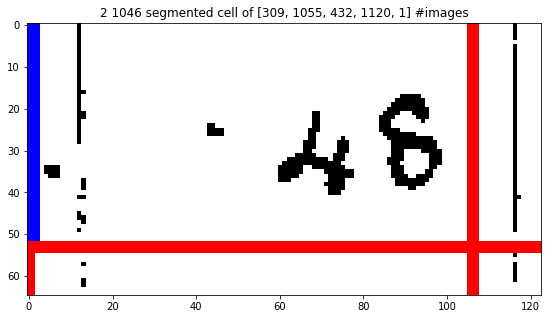

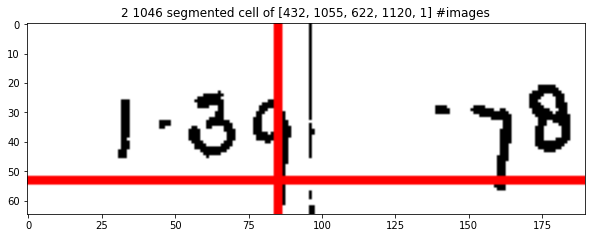

y:1.0719482619240097, x:2.8114285714285714


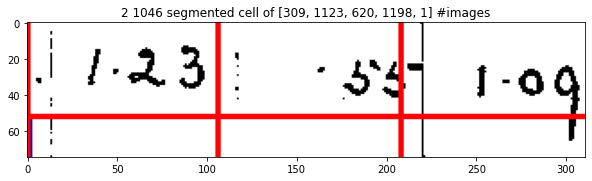

y:1.3742926434923202, x:2.8114285714285714


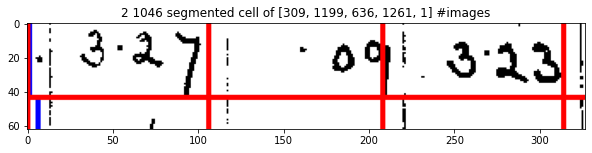

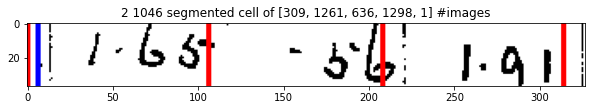

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 1.0 0.5123152709359606
1--1046 just above cell: [831, 985, 935, 1046, 1], Current cell: [732, 1046, 935, 1108, 1], [831, 1046, 935, 1108, 1], 1.0
-----Above-----

1 overlap score: 0.0 0.0
2--1046 before segmentation: [309, 1046, 1349, 1308, 1] cur_corrected: []
y:0.9345189975747776, x:2.8114285714285714


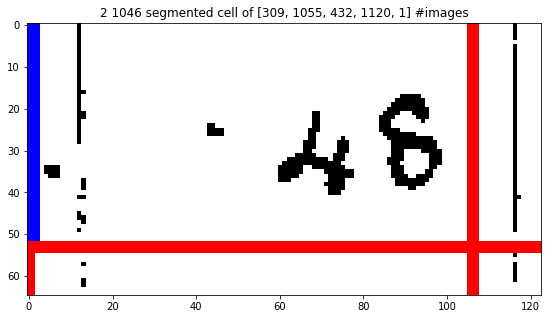

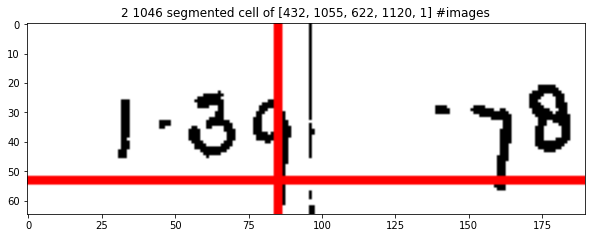

y:1.0719482619240097, x:2.8114285714285714


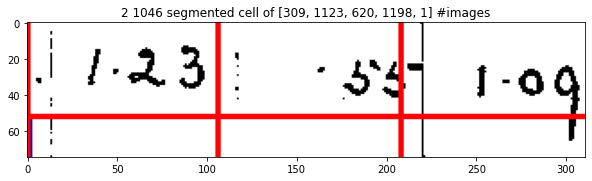

y:1.3742926434923202, x:2.8114285714285714


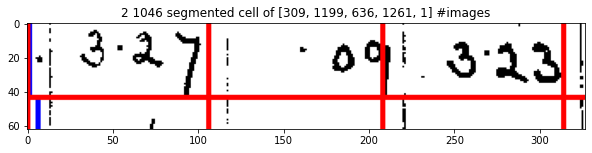

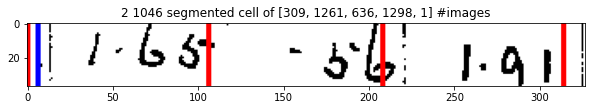

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
1 overlap score: 1.0 1.0
1--1046 just above cell: [1349, 985, 1526, 1046, 1], Current cell: [1349, 1046, 1526, 1108, 1], [1349, 1046, 1526, 1108, 1], 1.0
-----Above-----

============1108================== 
Above cells:[[415, 1046, 623, 1108, 1], [732, 1046, 935, 1108, 1], [1349, 1046, 1526, 1108, 1]] 
Current cells: [[131, 1108, 623, 1175, 1], [732, 1108, 935, 1175, 1], [1349, 1108, 1526, 1175, 1]] 
Below cells: [[309, 1308, 1349, 1369, 1]]
1 overlap score: 1.0 0.42276422764227645
1--1108 just above cell: [415, 1046, 623, 1108, 1], Current cell: [131, 1108, 623, 1175, 1], [415, 1108, 623, 1175, 1], 1.0
-----Above-----

1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
2--1108 before segmentation: [309, 1108, 1349, 1369, 1] cur_corrected: []
y:0.755860953920776, x:2.837142857142857


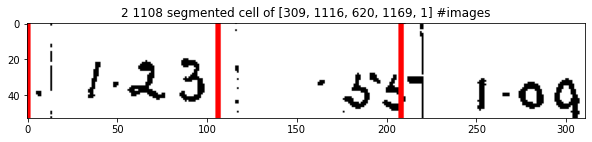

y:1.0582053354890866, x:2.837142857142857


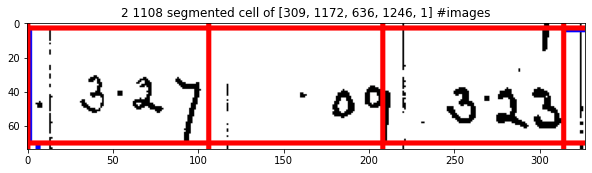

y:0.9070331447049312, x:2.837142857142857


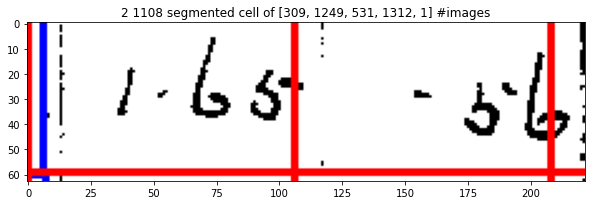

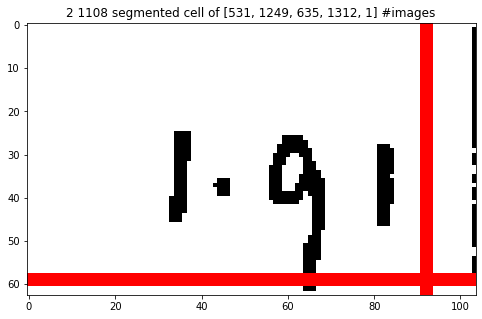

y:0.7283751010509296, x:2.837142857142857


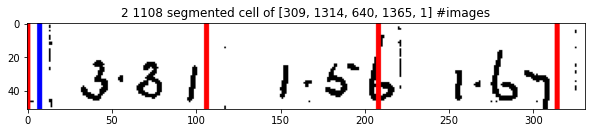

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 1.0 1.0
1--1108 just above cell: [732, 1046, 935, 1108, 1], Current cell: [732, 1108, 935, 1175, 1], [732, 1108, 935, 1175, 1], 1.0
-----Above-----

1 overlap score: 0.0 0.0
2--1108 before segmentation: [309, 1108, 1349, 1369, 1] cur_corrected: []
y:0.755860953920776, x:2.837142857142857


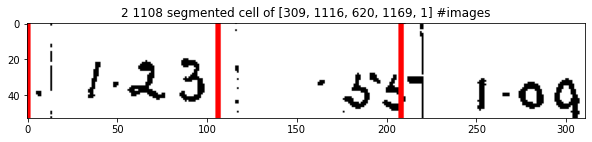

y:1.0582053354890866, x:2.837142857142857


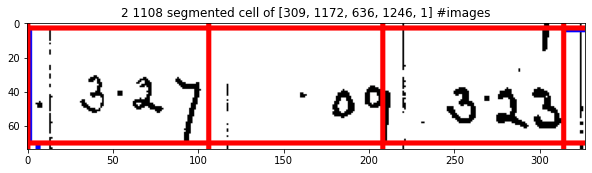

y:0.9070331447049312, x:2.837142857142857


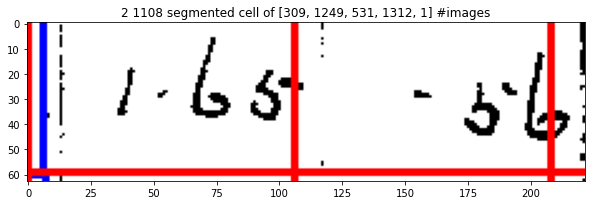

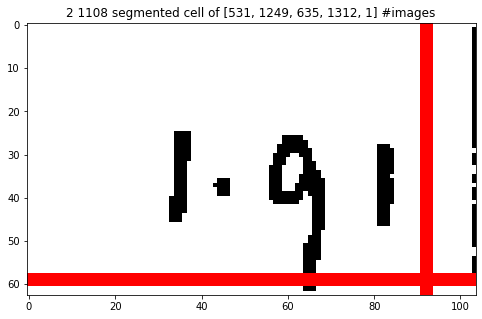

y:0.7283751010509296, x:2.837142857142857


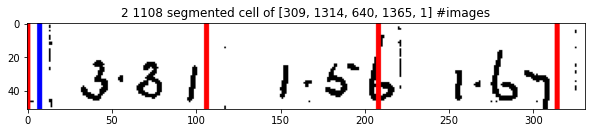

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
1 overlap score: 1.0 1.0
1--1108 just above cell: [1349, 1046, 1526, 1108, 1], Current cell: [1349, 1108, 1526, 1175, 1], [1349, 1108, 1526, 1175, 1], 1.0
-----Above-----

============1175================== 
Above cells:[[415, 1046, 623, 1108, 1], [732, 1046, 935, 1108, 1], [1349, 1046, 1526, 1108, 1]] 
Current cells: [[309, 1175, 732, 1242, 1], [831, 1175, 1034, 1242, 1]] 
Below cells: [[309, 1369, 732, 1438, 1], [1034, 1369, 1349, 1438, 1]]
1 overlap score: 1.0 0.491725768321513
1--1175 just above cell: [415, 1046, 623, 1108, 1], Current cell: [309, 1175, 732, 1242, 1], [415, 1175, 623, 1242, 1], 1.0
-----Above-----

1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
2--1175 before segmentation: [309, 1175, 732, 1438, 1] cur_corrected: []
y:0.7421180274858529, x:2.837142857142857


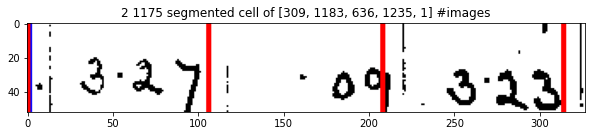

y:0.8658043654001617, x:2.837142857142857


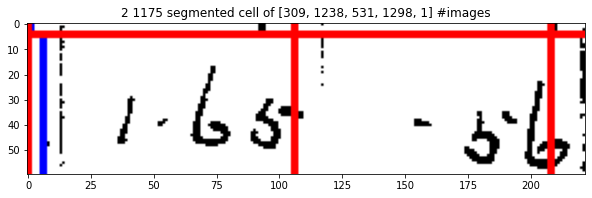

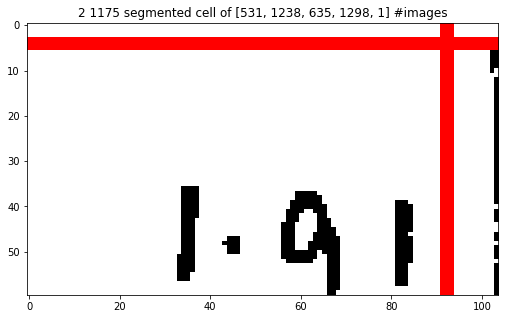

y:0.9207760711398545, x:2.837142857142857


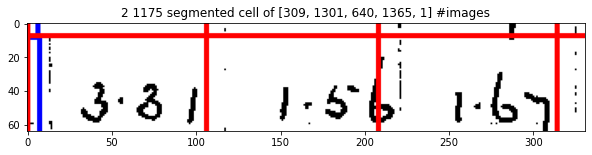

y:0.9345189975747776, x:2.837142857142857


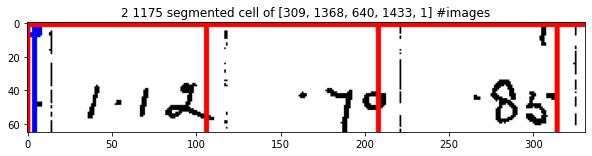

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 0.5123152709359606 0.5123152709359606
1--1175 just above cell: [732, 1046, 935, 1108, 1], Current cell: [831, 1175, 1034, 1242, 1], [732, 1175, 935, 1242, 1], 0.5123152709359606
-----Above-----

1 overlap score: 0.0 0.0
============1242================== 
Above cells:[[415, 1046, 623, 1108, 1], [732, 1046, 935, 1108, 1], [1349, 1046, 1526, 1108, 1]] 
Current cells: [[309, 1242, 1349, 1308, 1]] 
Below cells: [[131, 1438, 831, 1499, 1], [1034, 1438, 1349, 1499, 1]]
1 overlap score: 1.0 0.2
1--1242 just above cell: [415, 1046, 623, 1108, 1], Current cell: [309, 1242, 1349, 1308, 1], [415, 1242, 623, 1308, 1], 1.0
-----Above-----

1 overlap score: 1.0 0.1951923076923077
1--1242 just above cell: [732, 1046, 935, 1108, 1], Current cell: [309, 1242, 1349, 1308, 1], [732, 1242, 935, 1308, 1], 1.0
-----Above-----

1 overlap score: 0.0 0.0
2--1242 before segmentation: [131, 1242, 831, 1499, 1] cur_corrected: []
y:0.755860953920776, x:2.6

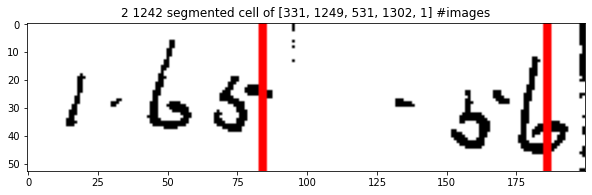

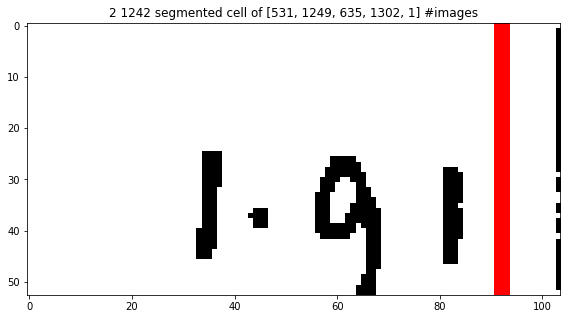

y:0.8658043654001617, x:2.6399999999999997


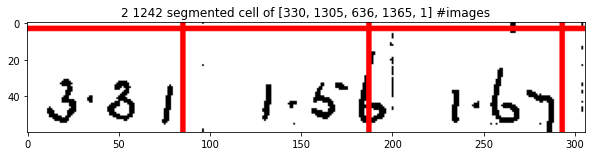

y:1.1131770412287794, x:2.6399999999999997


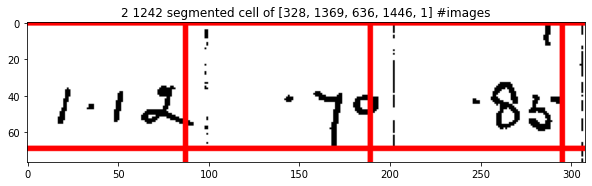

y:0.7146321746160065, x:2.6399999999999997


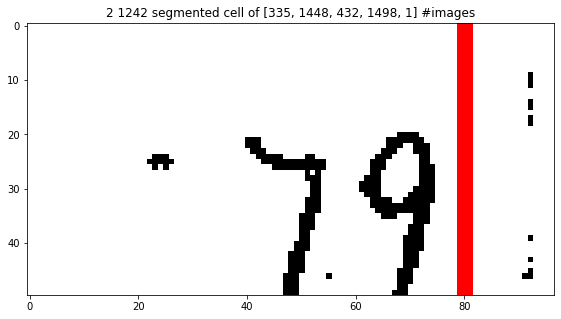

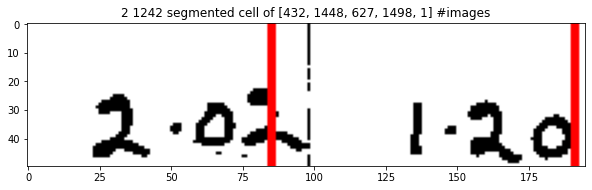

-----Below-----

============1308================== 
Above cells:[[309, 1242, 1349, 1308, 1]] 
Current cells: [[309, 1308, 1349, 1369, 1]] 
Below cells: [[131, 1499, 1141, 1589, 1], [1349, 1499, 1526, 1589, 1]]
1 overlap score: 1.0 1.0
1--1308 just above cell: [309, 1242, 1349, 1308, 1], Current cell: [309, 1308, 1349, 1369, 1], [309, 1308, 1349, 1369, 1], 1.0
y:0.7696038803556993, x:2.8457142857142856


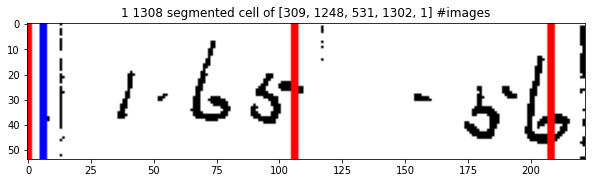

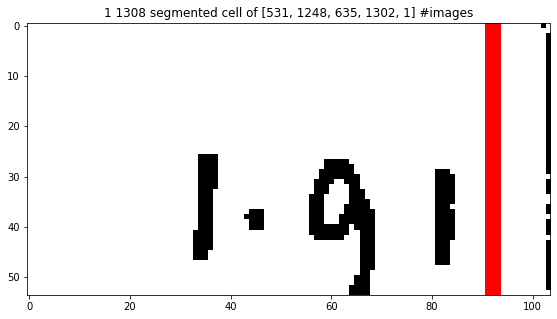

y:0.8658043654001617, x:2.8457142857142856


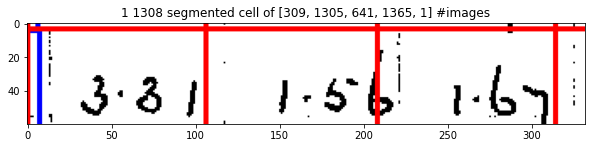

-----Above-----

2--1308 before segmentation: [131, 1308, 1141, 1589, 1] cur_corrected: []
y:0.755860953920776, x:2.6399999999999997


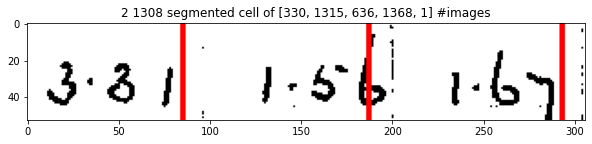

y:0.8795472918350848, x:2.6399999999999997


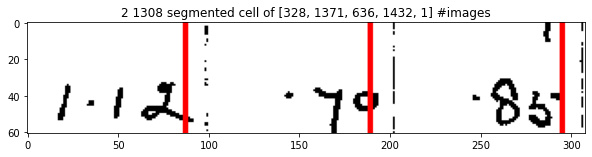

y:1.0719482619240097, x:2.6399999999999997


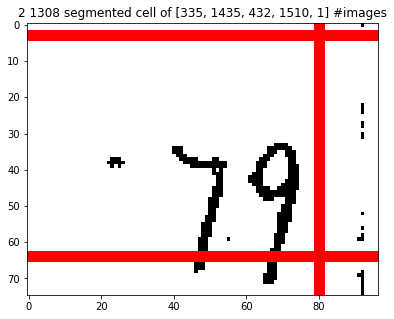

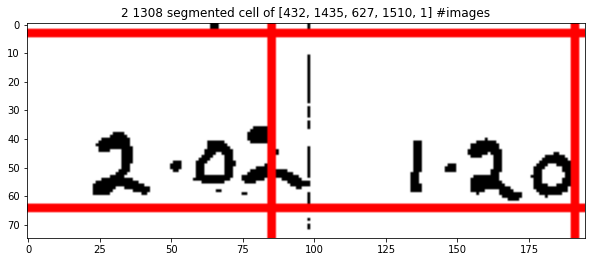

y:0.7421180274858529, x:2.6399999999999997


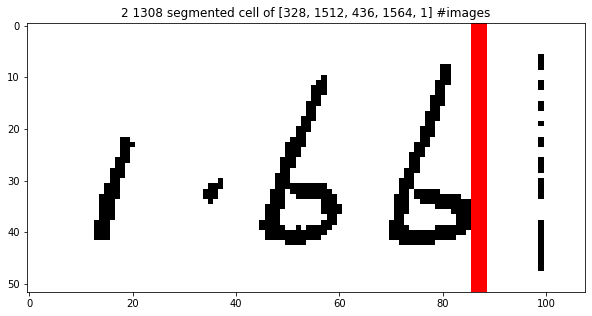

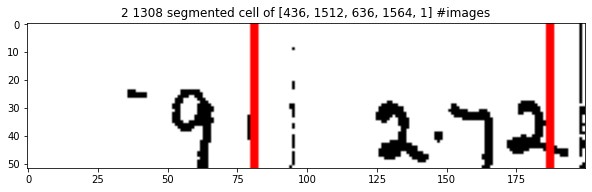

-----Below-----

============1369================== 
Above cells:[[309, 1308, 1349, 1369, 1]] 
Current cells: [[309, 1369, 732, 1438, 1], [1034, 1369, 1349, 1438, 1]] 
Below cells: [[131, 1499, 1141, 1589, 1], [1349, 1499, 1526, 1589, 1]]
1 overlap score: 0.40673076923076923 1.0
2--1369 before segmentation: [131, 1369, 1141, 1589, 1] cur_corrected: []
y:0.7833468067906225, x:2.6142857142857143


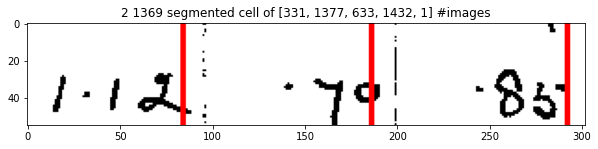

y:0.8932902182700081, x:2.6142857142857143


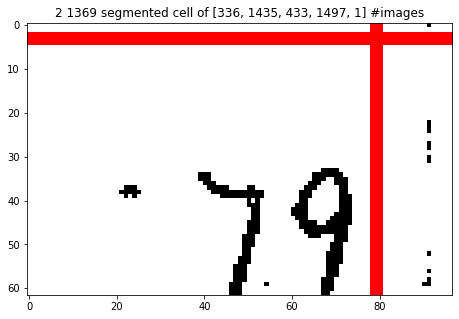

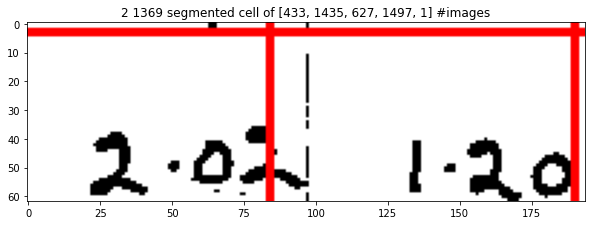

y:0.9207760711398545, x:2.6142857142857143


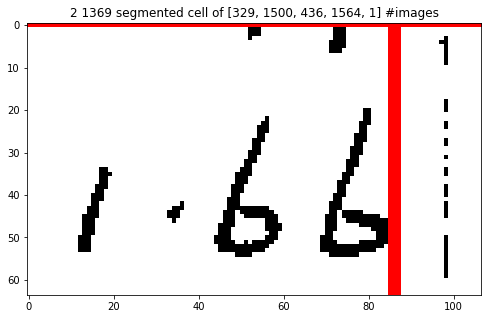

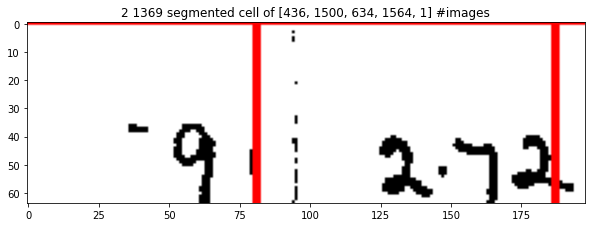

-----Below-----

1 overlap score: 0.30288461538461536 1.0
============1438================== 
Above cells:[[309, 1369, 732, 1438, 1], [1034, 1369, 1349, 1438, 1]] 
Current cells: [[131, 1438, 831, 1499, 1], [1034, 1438, 1349, 1499, 1]] 
Below cells: [[131, 1589, 935, 1694, 1], [1141, 1589, 1526, 1694, 1]]
1 overlap score: 1.0 0.6042857142857143
1--1438 just above cell: [309, 1369, 732, 1438, 1], Current cell: [131, 1438, 831, 1499, 1], [309, 1438, 732, 1499, 1], 1.0
y:0.7833468067906225, x:3.6257142857142854


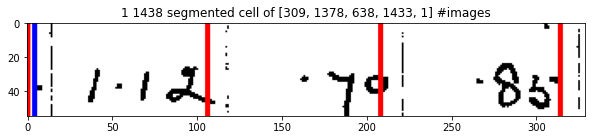

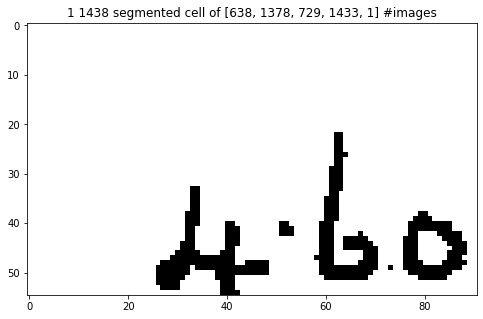

y:0.8932902182700081, x:3.6257142857142854


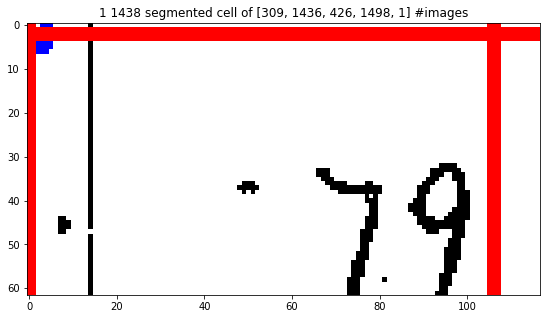

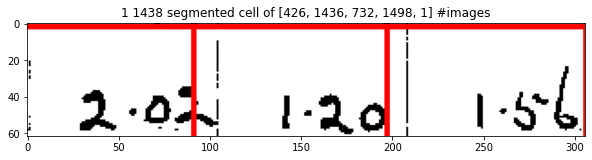

-----Above-----

1 overlap score: 0.0 0.0
2--1438 before segmentation: [131, 1438, 935, 1694, 1] cur_corrected: []
y:0.7421180274858529, x:2.494285714285714


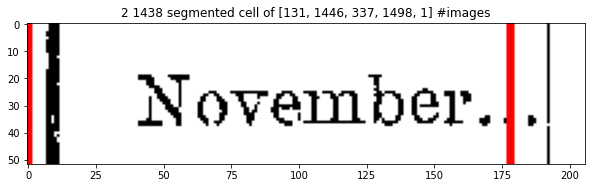

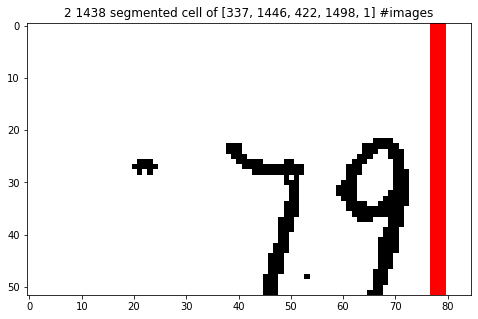

y:0.9070331447049312, x:2.494285714285714


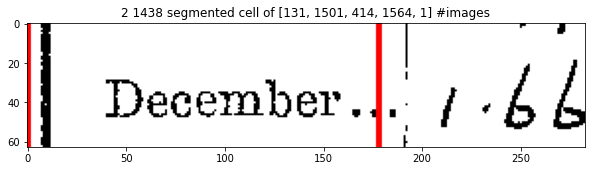

y:0.7970897332255457, x:2.494285714285714


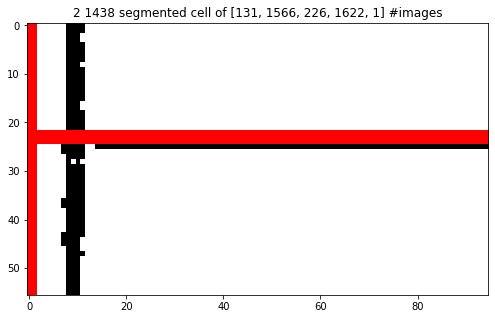

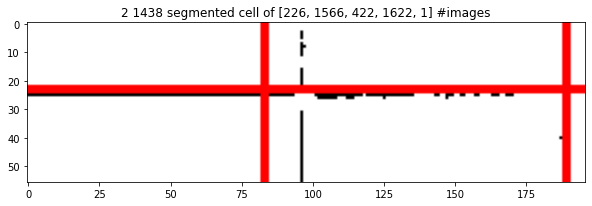

y:0.9894907033144705, x:2.494285714285714


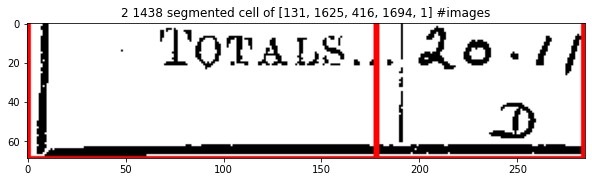

y:0.7421180274858529, x:4.38


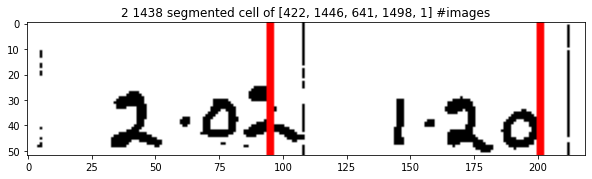

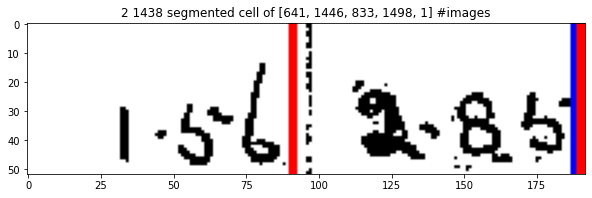

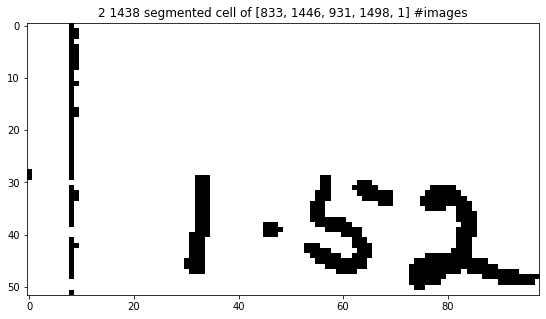

y:0.9070331447049312, x:4.38


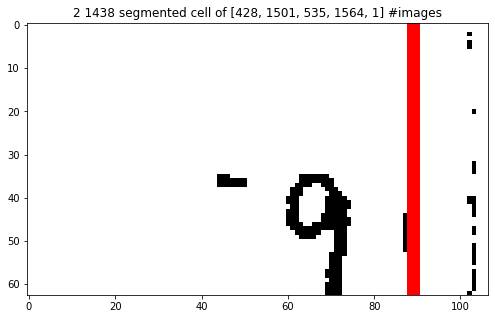

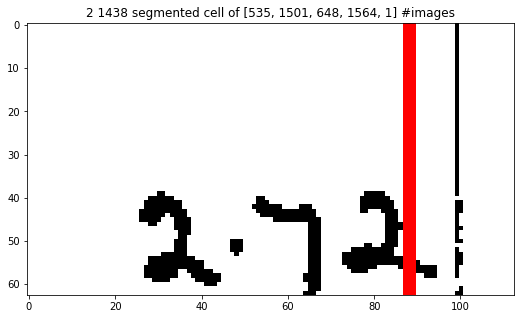

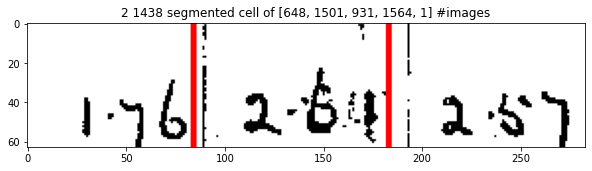

y:0.7970897332255457, x:4.38


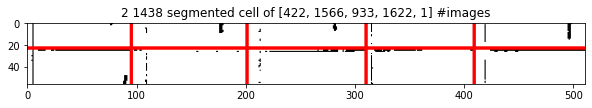

y:0.9894907033144705, x:4.38


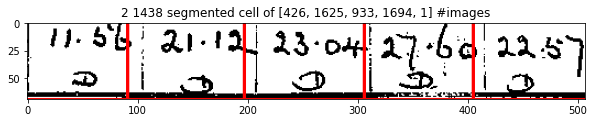

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 1.0 1.0
1--1438 just above cell: [1034, 1369, 1349, 1438, 1], Current cell: [1034, 1438, 1349, 1499, 1], [1034, 1438, 1349, 1499, 1], 1.0
-----Above-----

2--1438 before segmentation: [1141, 1438, 1526, 1694, 1] cur_corrected: []
y:0.9345189975747776, x:3.3


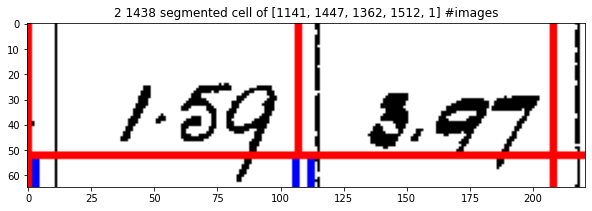

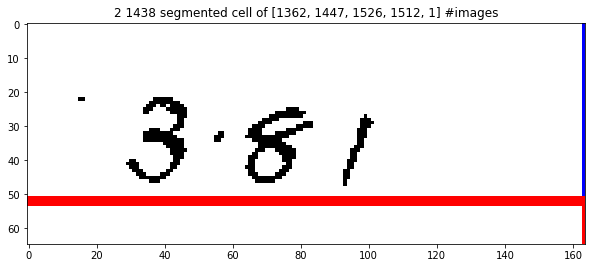

y:1.4704931285367826, x:3.3


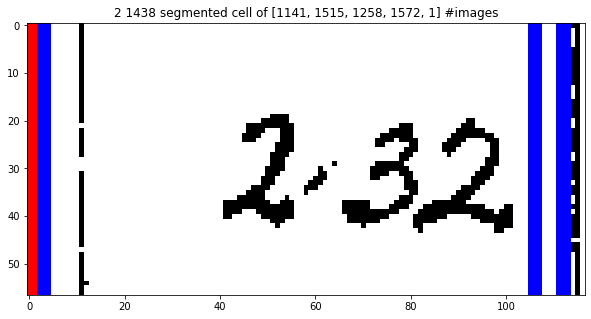

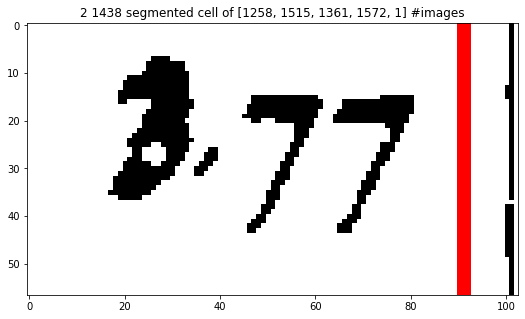

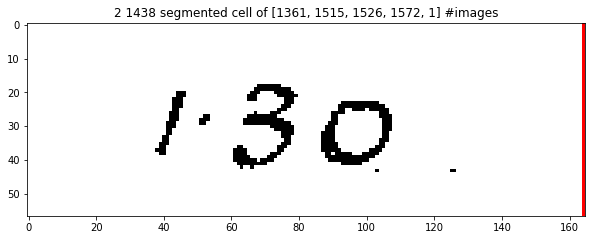

y:1.03071948261924, x:3.3


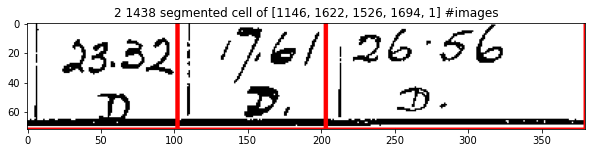

-----Below-----

============1499================== 
Above cells:[[309, 1369, 732, 1438, 1], [1034, 1369, 1349, 1438, 1]] 
Current cells: [[131, 1499, 1141, 1589, 1], [1349, 1499, 1526, 1589, 1]] 
Below cells: [[131, 1589, 935, 1694, 1], [1141, 1589, 1526, 1694, 1]]
1 overlap score: 1.0 0.4188118811881188
1--1499 just above cell: [309, 1369, 732, 1438, 1], Current cell: [131, 1499, 1141, 1589, 1], [309, 1499, 732, 1589, 1], 1.0
y:0.7833468067906225, x:3.6257142857142854


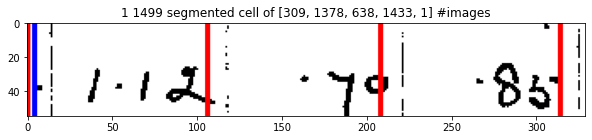

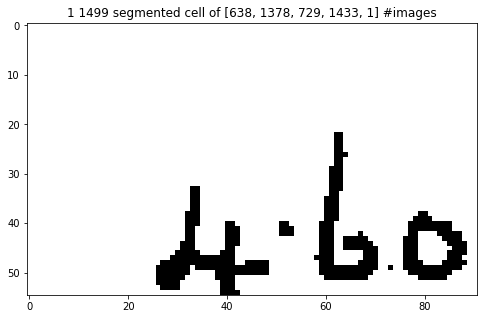

y:0.8932902182700081, x:3.6257142857142854


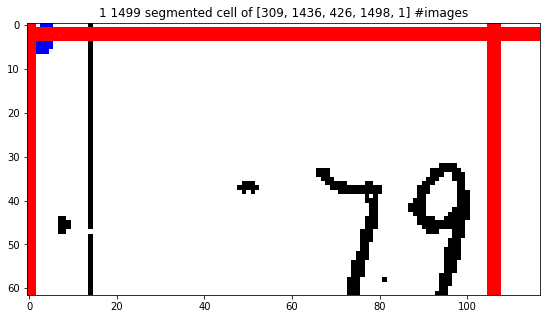

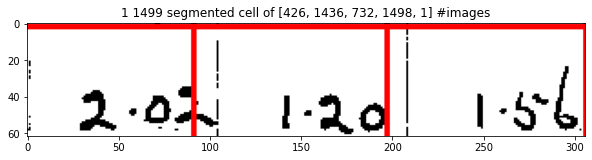

y:0.9070331447049312, x:3.6257142857142854


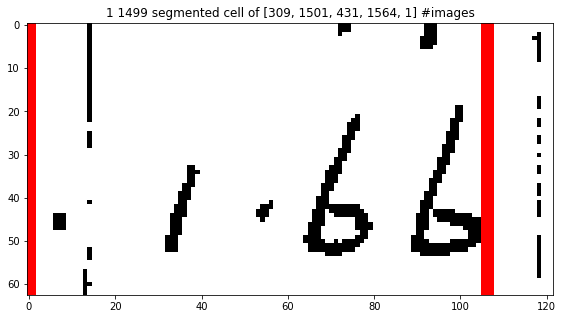

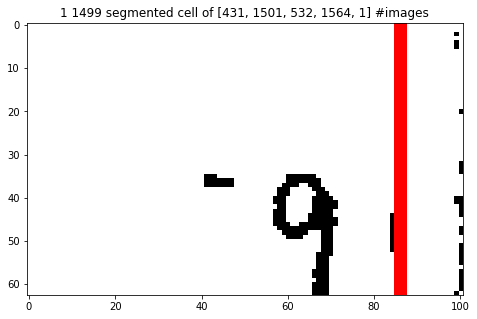

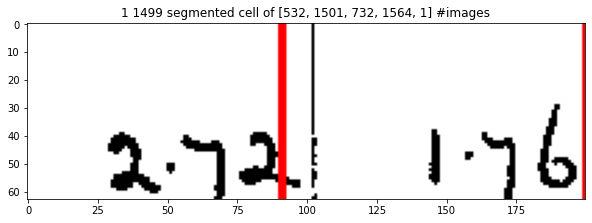

-----Above-----

1 overlap score: 0.3396825396825397 0.10594059405940594
2--1499 before segmentation: [131, 1499, 935, 1694, 1] cur_corrected: []
y:0.7970897332255457, x:2.494285714285714


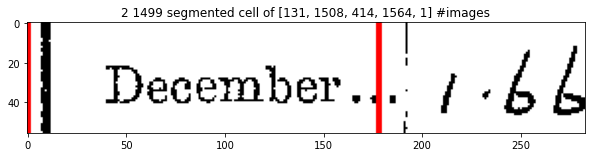

y:0.8383185125303153, x:2.494285714285714


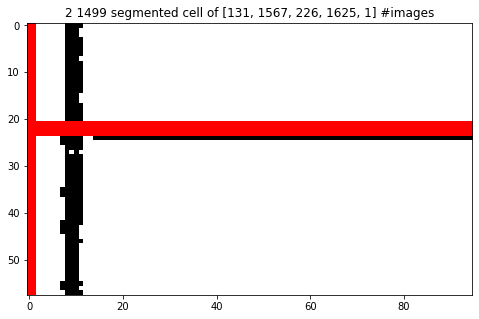

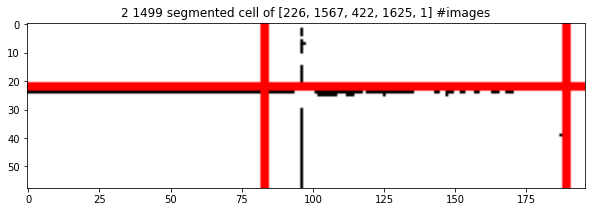

y:0.9482619240097009, x:2.494285714285714


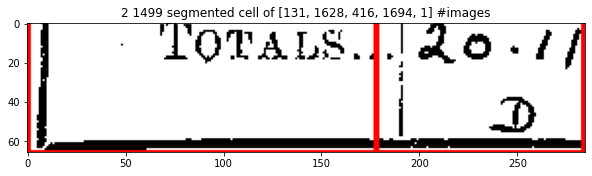

y:0.7970897332255457, x:4.38


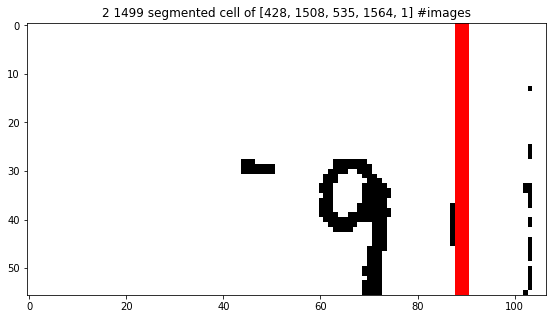

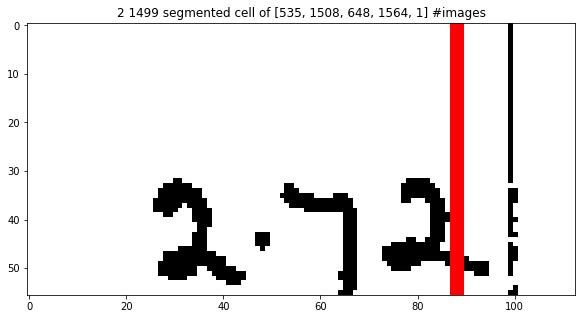

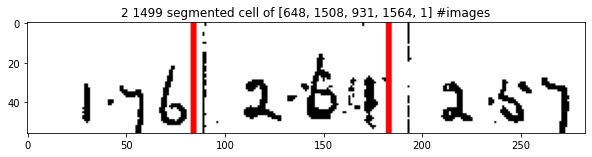

y:0.8383185125303153, x:4.38


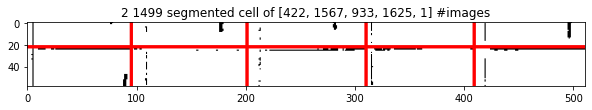

y:0.9482619240097009, x:4.38


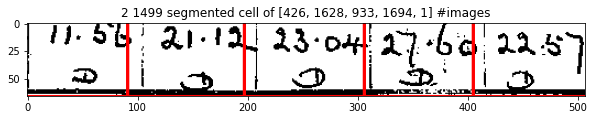

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
2--1499 before segmentation: [1141, 1499, 1526, 1694, 1] cur_corrected: []
y:0.7421180274858529, x:3.3


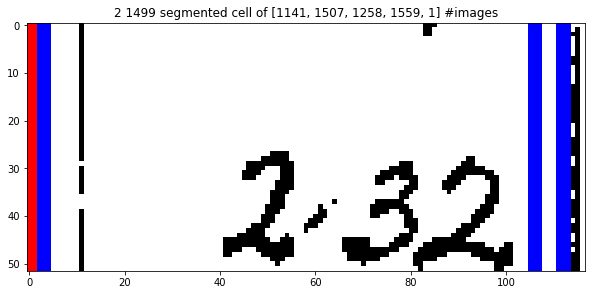

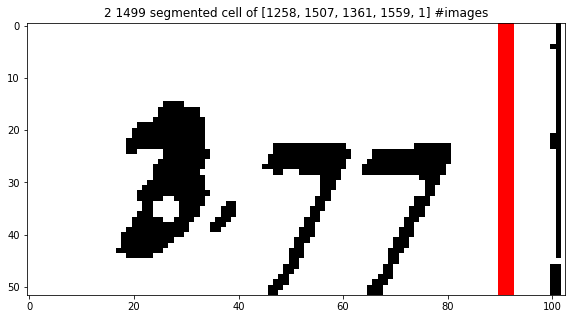

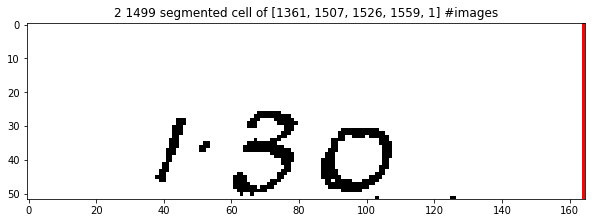

y:0.8795472918350848, x:3.3


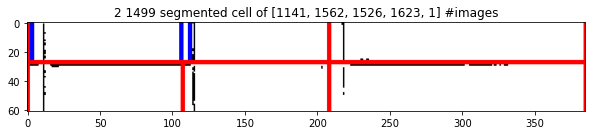

y:0.9757477768795473, x:3.3


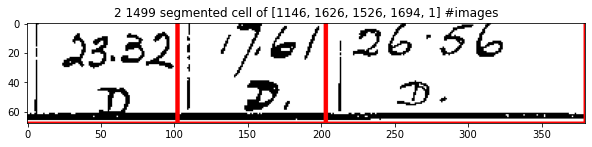

-----Below-----

============1589================== 
Above cells:[[131, 1499, 1141, 1589, 1], [1349, 1499, 1526, 1589, 1]] 
Current cells: [[131, 1589, 935, 1694, 1], [1141, 1589, 1526, 1694, 1]] 
Below cells: [[131, 1589, 935, 1694, 1], [1141, 1589, 1526, 1694, 1]]
1 overlap score: 0.7960396039603961 1.0
1--1589 just above cell: [131, 1499, 1141, 1589, 1], Current cell: [131, 1589, 935, 1694, 1], [131, 1589, 1141, 1694, 1], 0.7960396039603961
y:0.8108326596604689, x:2.494285714285714


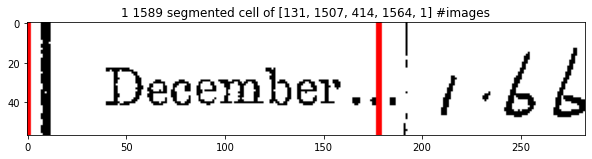

y:0.8383185125303153, x:2.494285714285714


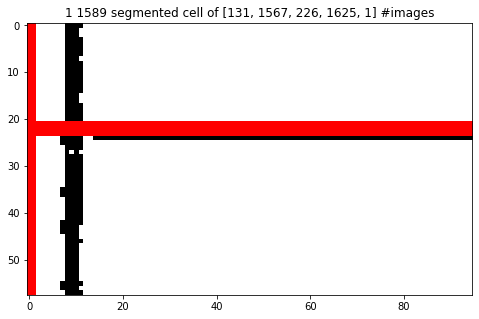

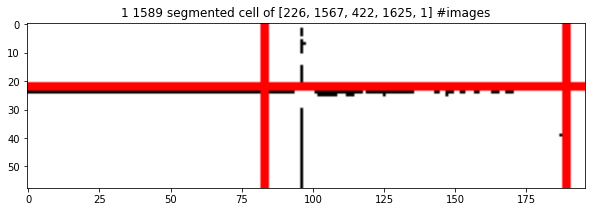

y:0.9482619240097009, x:2.494285714285714


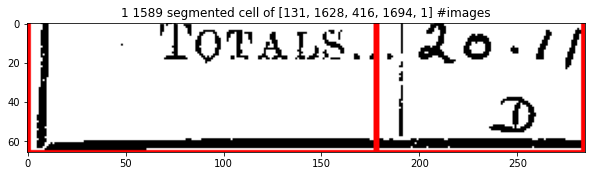

y:0.8108326596604689, x:4.311428571428571


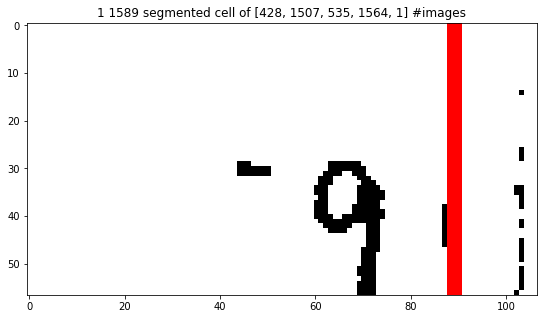

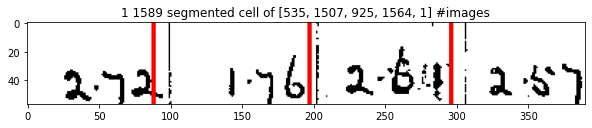

y:0.8383185125303153, x:4.311428571428571


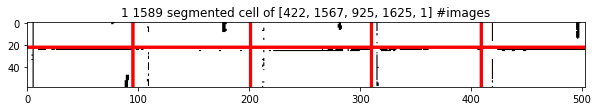

y:0.9482619240097009, x:4.311428571428571


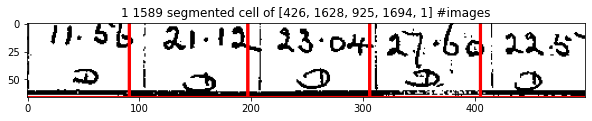

-----Above-----

1 overlap score: 0.0 0.0
2--1589 before segmentation: [131, 1589, 935, 1694, 1] cur_corrected: []
y:1.443007275666936, x:2.5028571428571427


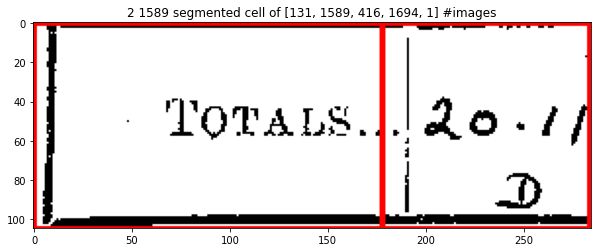

y:1.443007275666936, x:4.38


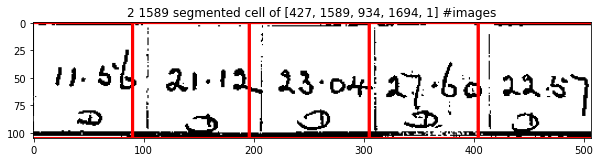

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 1.0 0.4597402597402597
1--1589 just above cell: [1349, 1499, 1526, 1589, 1], Current cell: [1141, 1589, 1526, 1694, 1], [1349, 1589, 1526, 1694, 1], 1.0
-----Above-----

2--1589 before segmentation: [1141, 1589, 1526, 1694, 1] cur_corrected: []
y:0.8658043654001617, x:3.257142857142857


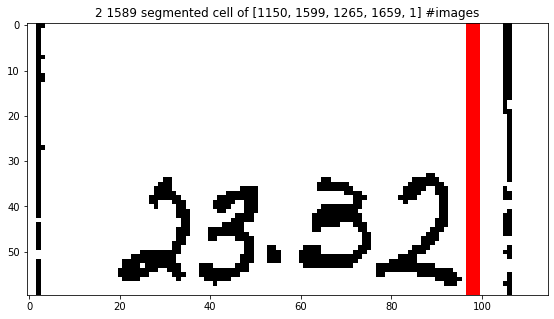

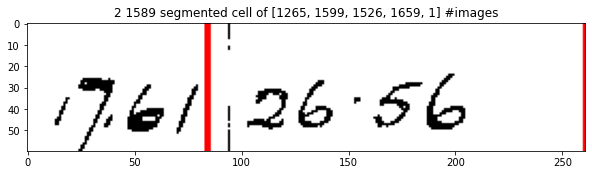

-----Below-----

============2088================== 
Above cells:[] 
Current cells: [[68, 2088, 337, 2165, 0], [577, 2088, 843, 2165, 0]] 
Below cells: [[68, 2088, 337, 2165, 0], [577, 2088, 843, 2165, 0]]
2--2088 before segmentation: [68, 2088, 337, 2165, 0] cur_corrected: []
-----Below-----

2--2088 before segmentation: [577, 2088, 843, 2165, 0] cur_corrected: []
-----Below-----

============2372================== 
Above cells:[] 
Current cells: [[1090, 2372, 1362, 2445, 0]] 
Below cells: [[1090, 2372, 1362, 2445, 0]]
2--2372 before segmentation: [1090, 2372, 1362, 2445, 0] cur_corrected: []
-----Below-----



In [164]:
# combine x and y neighbours v2
error_corrected_cells = []
not_corrected_cells = []

if len(x_y_neighbouring_cells_dict)>2:
    for yid in x_y_neighbouring_cells_dict:
    #     print(yid)
        ynid, xnid = x_y_neighbouring_cells_dict[yid]

        if len(ynid) == 0:
            for cell in xnid:                        
                cur_corrected = segment_image(cell, masks[1], average_cordinates,tables,segmenter=0.05)
                error_corrected = []
                for cur_cell in cur_corrected:
                    if abs(cur_cell[1]-cur_cell[3])/avg_y>2 or abs(cur_cell[0]-cur_cell[2])/avg_x>2:
                        print(f'y:{abs(cur_cell[1]-cur_cell[3])/avg_y}, x:{abs(cur_cell[0]-cur_cell[2])/avg_x}')
                        cur_corrected_new = segment_image(cur_cell, masks[1], average_cordinates,tables,segmenter=0.03)
                        for cur_cell2 in cur_corrected_new:
                            croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
                            plt.rcParams["figure.figsize"] = (10,5)
                            plt.imshow(croppedimage_full)
                            plt.title(f'1 {yid} segmented cell of {cur_cell2} #images')
                            plt.show() 
                            if check_cell(cur_cell2,average_cordinates):
                                error_corrected.append(cur_cell2)
                    else:
                        if check_cell(cur_cell,average_cordinates):
                            error_corrected.append(cur_cell)

                if len(error_corrected_cells)>0:
                    cur_correct_final, error_corrected_cells = find_overlapped_cell(error_corrected_cells, error_corrected, average_cordinates)
                    error_corrected_cells += cur_correct_final
                else:
                    error_corrected_cells += error_corrected
                        
#                     print(cell, imagedraw[idx],tab_boundary[idx], avg_y/3, abs(cell[idx]-tab_boundary[idx]))

        elif len(xnid)>0: #multiple neighbours
    #         print(ynid, yid)
            above_cells = []
            cur_cells = []
            below_cells = []
            for y_n in ynid:
                if y_n < yid:
    #                 print(y_n, yid)
                    above_cells = x_y_neighbouring_cells_dict[y_n][1]
                else:
                    cur_cells = xnid

                    below_cells = x_y_neighbouring_cells_dict[y_n][1]
            print(f'============{yid}================== \nAbove cells:{above_cells} \nCurrent cells: {xnid} \nBelow cells: {below_cells}')

            for cell in xnid:
                anchor = list(cell)  

                tid = cell[4]
                avg_x, avg_y = average_cordinates[tid]

                step_x = int(avg_x*0.025)
                step_y = int(avg_y*0.025)

                tab_boundary = list(map(int, tables[tid]))

                #check above first:
                for a_cell in above_cells:
                    anchor_a = list(a_cell)
                    anchor_a[1] = anchor[1] # change the y-coordinates to see overlapping or not and if overlapped the cell is immediate neighbour
                    anchor_a[3] = anchor[3]
                    score1 = tsa.how_much_contained(anchor_a, cell)
                    score2 = tsa.how_much_contained(cell,anchor_a)

                    print('1 overlap score:',score1,score2)

                    if score1>0.5:
                        merged_cell = list(a_cell)
                        merged_cell[3] = cell[3]

                        print(f'1--{yid} just above cell: {a_cell}, Current cell: {cell}, {anchor_a}, {score1}')
                        above = True  
                        cur_corrected = segment_image(merged_cell, masks[1], average_cordinates,tables,segmenter=0.05)
                        
                        
                        error_corrected = []
                        for cur_cell in cur_corrected:
                            if abs(cur_cell[1]-cur_cell[3])/avg_y>2 or abs(cur_cell[0]-cur_cell[2])/avg_x>2:
                                print(f'y:{abs(cur_cell[1]-cur_cell[3])/avg_y}, x:{abs(cur_cell[0]-cur_cell[2])/avg_x}')
                                cur_corrected_new = segment_image(cur_cell, masks[1], average_cordinates,tables,segmenter=0.03)
                                for cur_cell2 in cur_corrected_new:
                                    croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
                                    plt.rcParams["figure.figsize"] = (10,5)
                                    plt.imshow(croppedimage_full)
                                    plt.title(f'1 {yid} segmented cell of {cur_cell2} #images')
                                    plt.show() 
                                    if check_cell(cur_cell2,average_cordinates):
                                        error_corrected.append(cur_cell2)
                            else:
                                if check_cell(cur_cell,average_cordinates):
                                    error_corrected.append(cur_cell)

                        if len(error_corrected_cells)>0:
                            cur_correct_final, error_corrected_cells = find_overlapped_cell(error_corrected_cells, error_corrected, average_cordinates)
                            error_corrected_cells += cur_correct_final
                        else:
                            error_corrected_cells += error_corrected

                        print('-----Above-----\n')

                #check below cell:
                for b_cell in below_cells:
                    anchor_b = list(b_cell)
                    anchor_b[1] = anchor[1] # change the y-coordinates to see overlapping or not and if overlapped the cell is immediate neighbour
                    anchor_b[3] = anchor[3]
                    score1 = tsa.how_much_contained(cell,anchor_b)
                    score2 = tsa.how_much_contained(anchor_b, cell)

                    if score1>0.5:

                        merged_cell = list(b_cell)
                        merged_cell[1] = cell[1]
                        cur_correct_final =[]
                        cur_corrected = []
                        error_corrected = []
                        print(f'2--{yid} before segmentation: {merged_cell} cur_corrected: {cur_corrected}')   

                        cur_corrected = segment_image(merged_cell, masks[1], average_cordinates,tables,segmenter=0.05)
                        error_corrected = []
                        for cur_cell in cur_corrected:
                            if abs(cur_cell[1]-cur_cell[3])/avg_y>2 or abs(cur_cell[0]-cur_cell[2])/avg_x>2:
                                print(f'y:{abs(cur_cell[1]-cur_cell[3])/avg_y}, x:{abs(cur_cell[0]-cur_cell[2])/avg_x}')
                                cur_corrected_new = segment_image(cur_cell, masks[1], average_cordinates,tables,segmenter=0.03)
                                for cur_cell2 in cur_corrected_new:
                                    croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
                                    plt.rcParams["figure.figsize"] = (10,5)
                                    plt.imshow(croppedimage_full)
                                    plt.title(f'2 {yid} segmented cell of {cur_cell2} #images')
                                    plt.show() 
                                    if check_cell(cur_cell2,average_cordinates):
                                        error_corrected.append(cur_cell2)
                            else:
                                if check_cell(cur_cell,average_cordinates):
                                    error_corrected.append(cur_cell)

                        if len(error_corrected_cells)>0:
                            cur_correct_final, error_corrected_cells = find_overlapped_cell(error_corrected_cells, error_corrected, average_cordinates)
                            error_corrected_cells += cur_correct_final
                        else:
                            error_corrected_cells += error_corrected

                        print('-----Below-----\n')



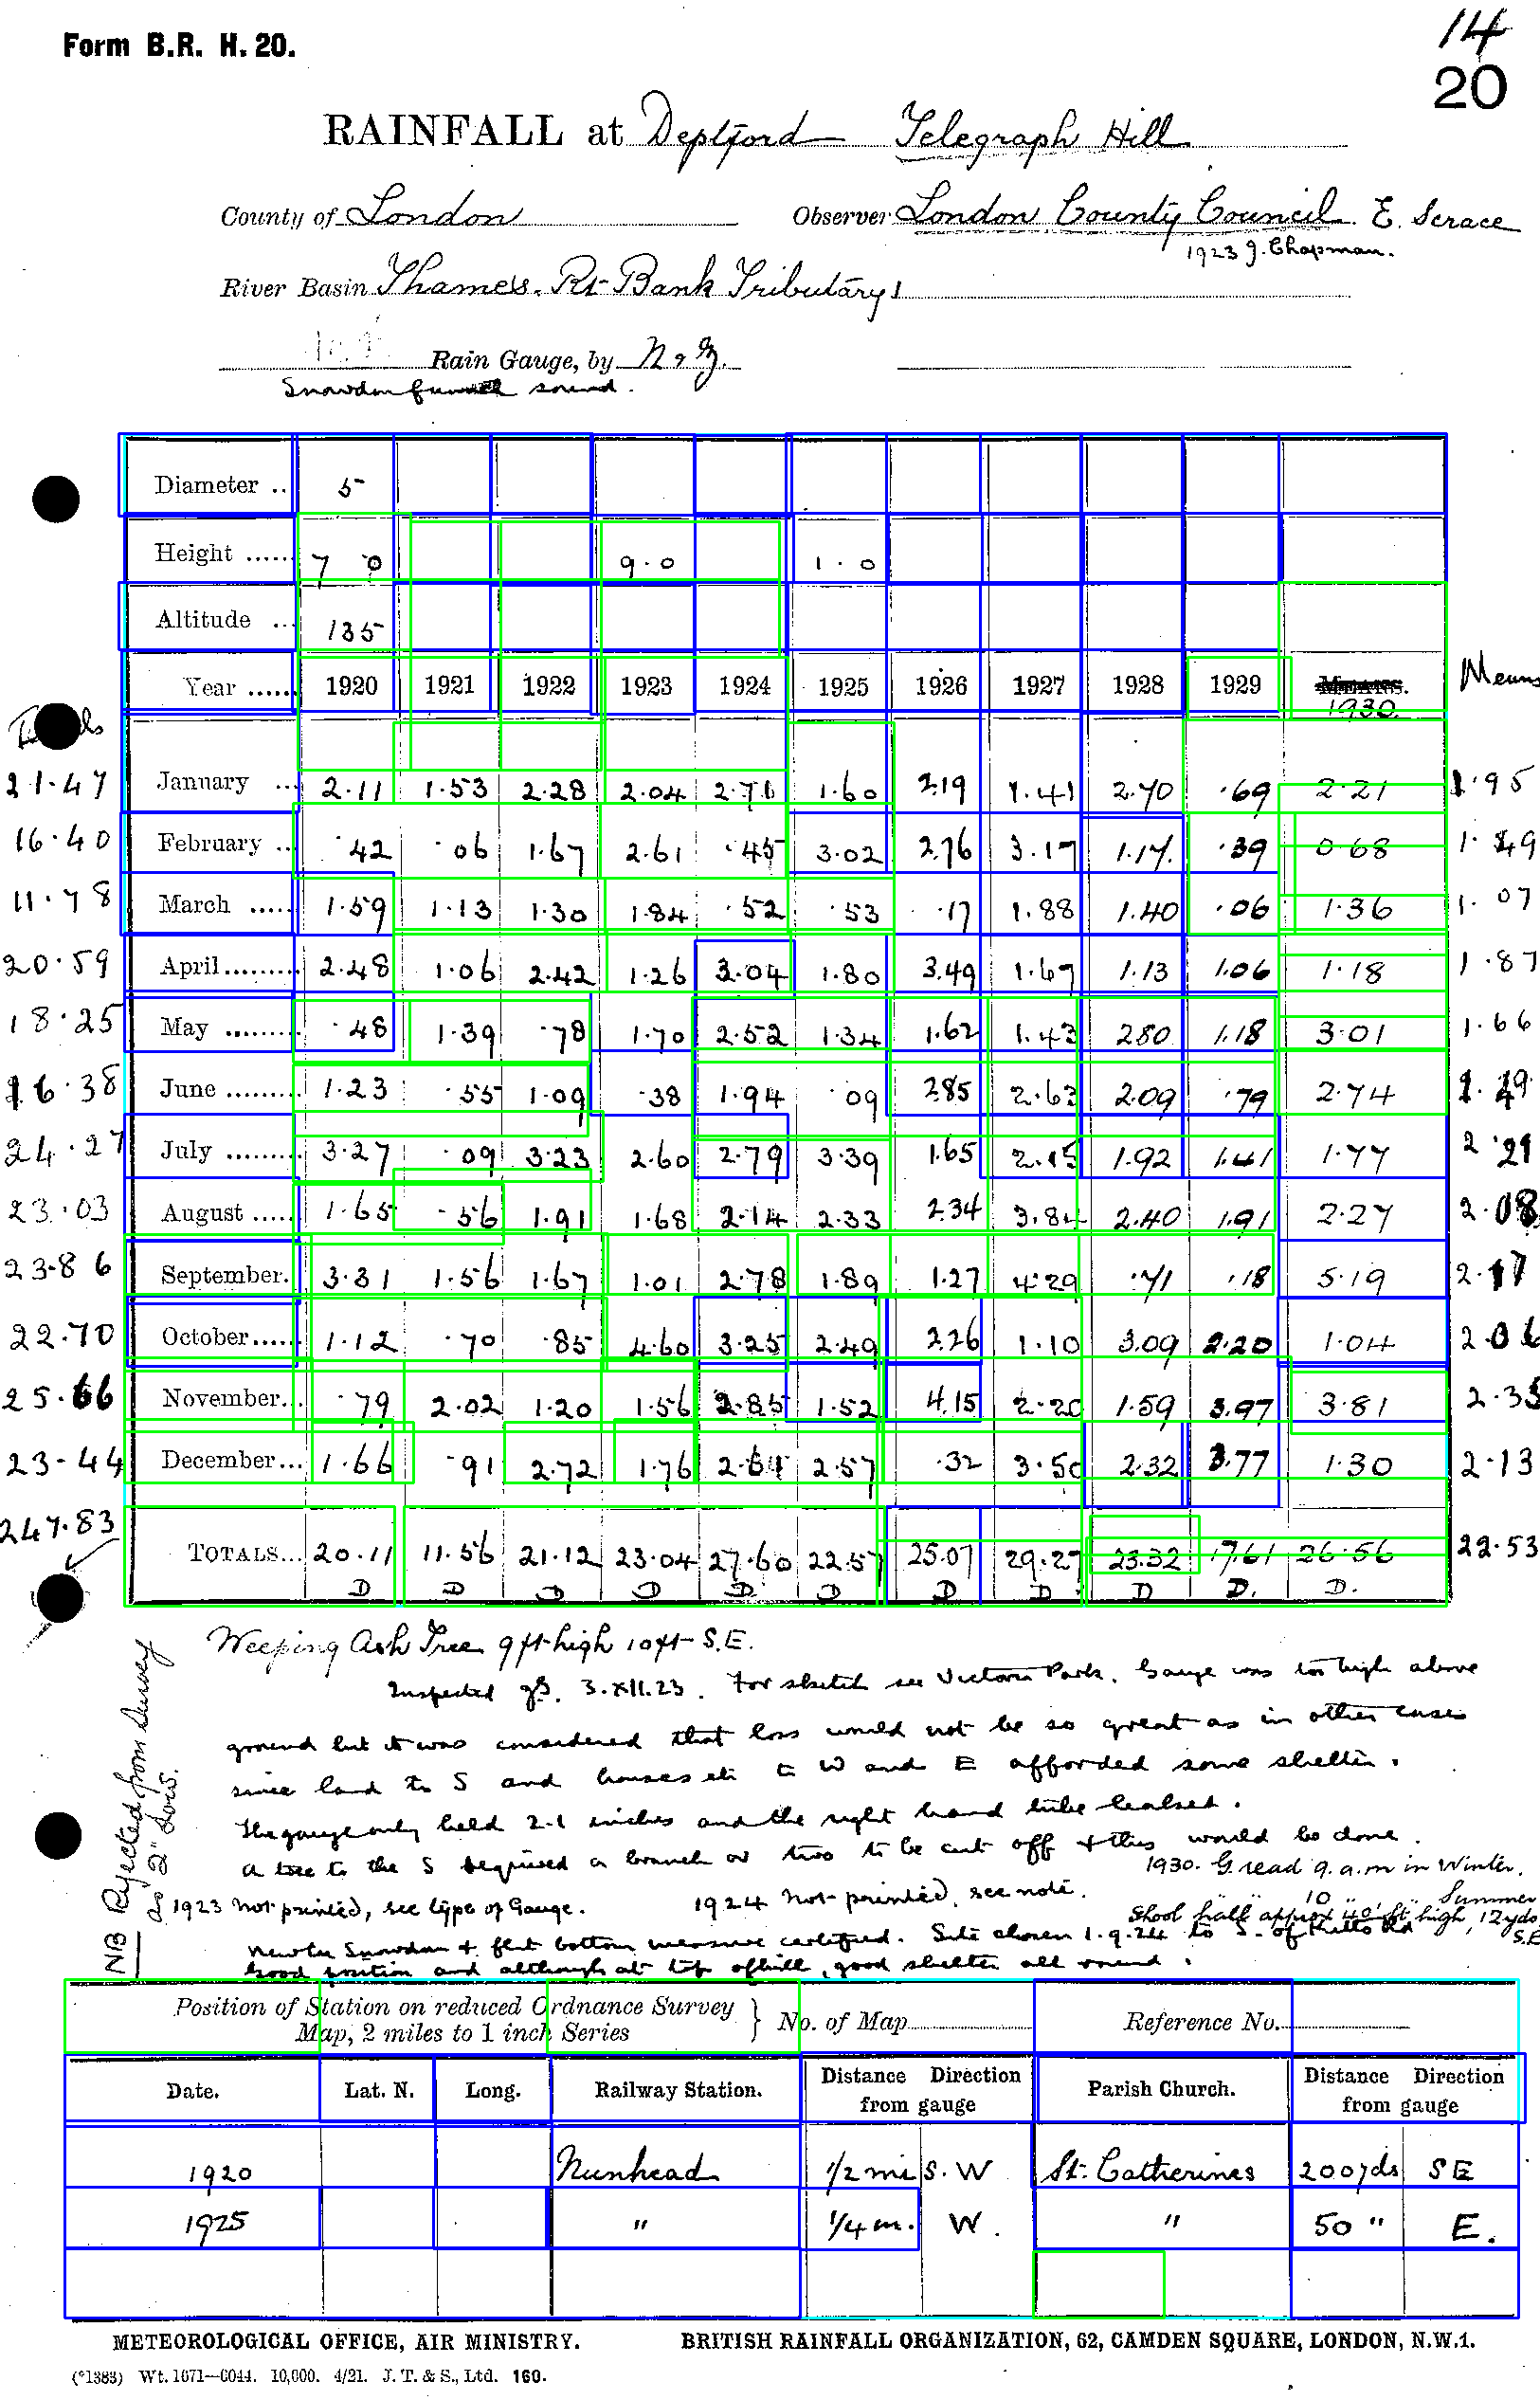

In [165]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(all_valid_cells):
    put_box(image,box,(0,0,color)) # Blue
    
for box in list(error_corrected_cells):
    put_box(image,box,(0,color,0)) # Green
    
# for box in list(blank_cells):
#     put_box(image,box,(color,color,0)) # Green
    
# for box in list(not_corrected_excluded_cells):
#     put_box(image,box,(color,0,0)) # Green

im_pil = Image.fromarray(image)
# im_pil.save(f"{outdirectory}/{filename}/9.table_cell_generation_valid_added.jpg")
im_pil  

In [40]:
filtered_error_corrected_cells =filter_overlapped_cell(error_corrected_cells, average_cordinates)

In [41]:
correct_cells, blank_cells_new, exclude_cells_new = classify_cells(filtered_error_corrected_cells, masks[1], average_cordinates)

In [42]:
filtered_error_corrected_cells, filter_all_valid_cells =  find_overlapped_cell(filter_all_valid_cells, correct_cells+blank_cells_new, average_cordinates)

not_corrected_excluded_cells, _ =  find_overlapped_cell(filter_all_valid_cells+filtered_error_corrected_cells, not_corrected_excluded_cells+exclude_cells_new, average_cordinates)
not_corrected_excluded_cells = filter_overlapped_cell(not_corrected_excluded_cells, average_cordinates)

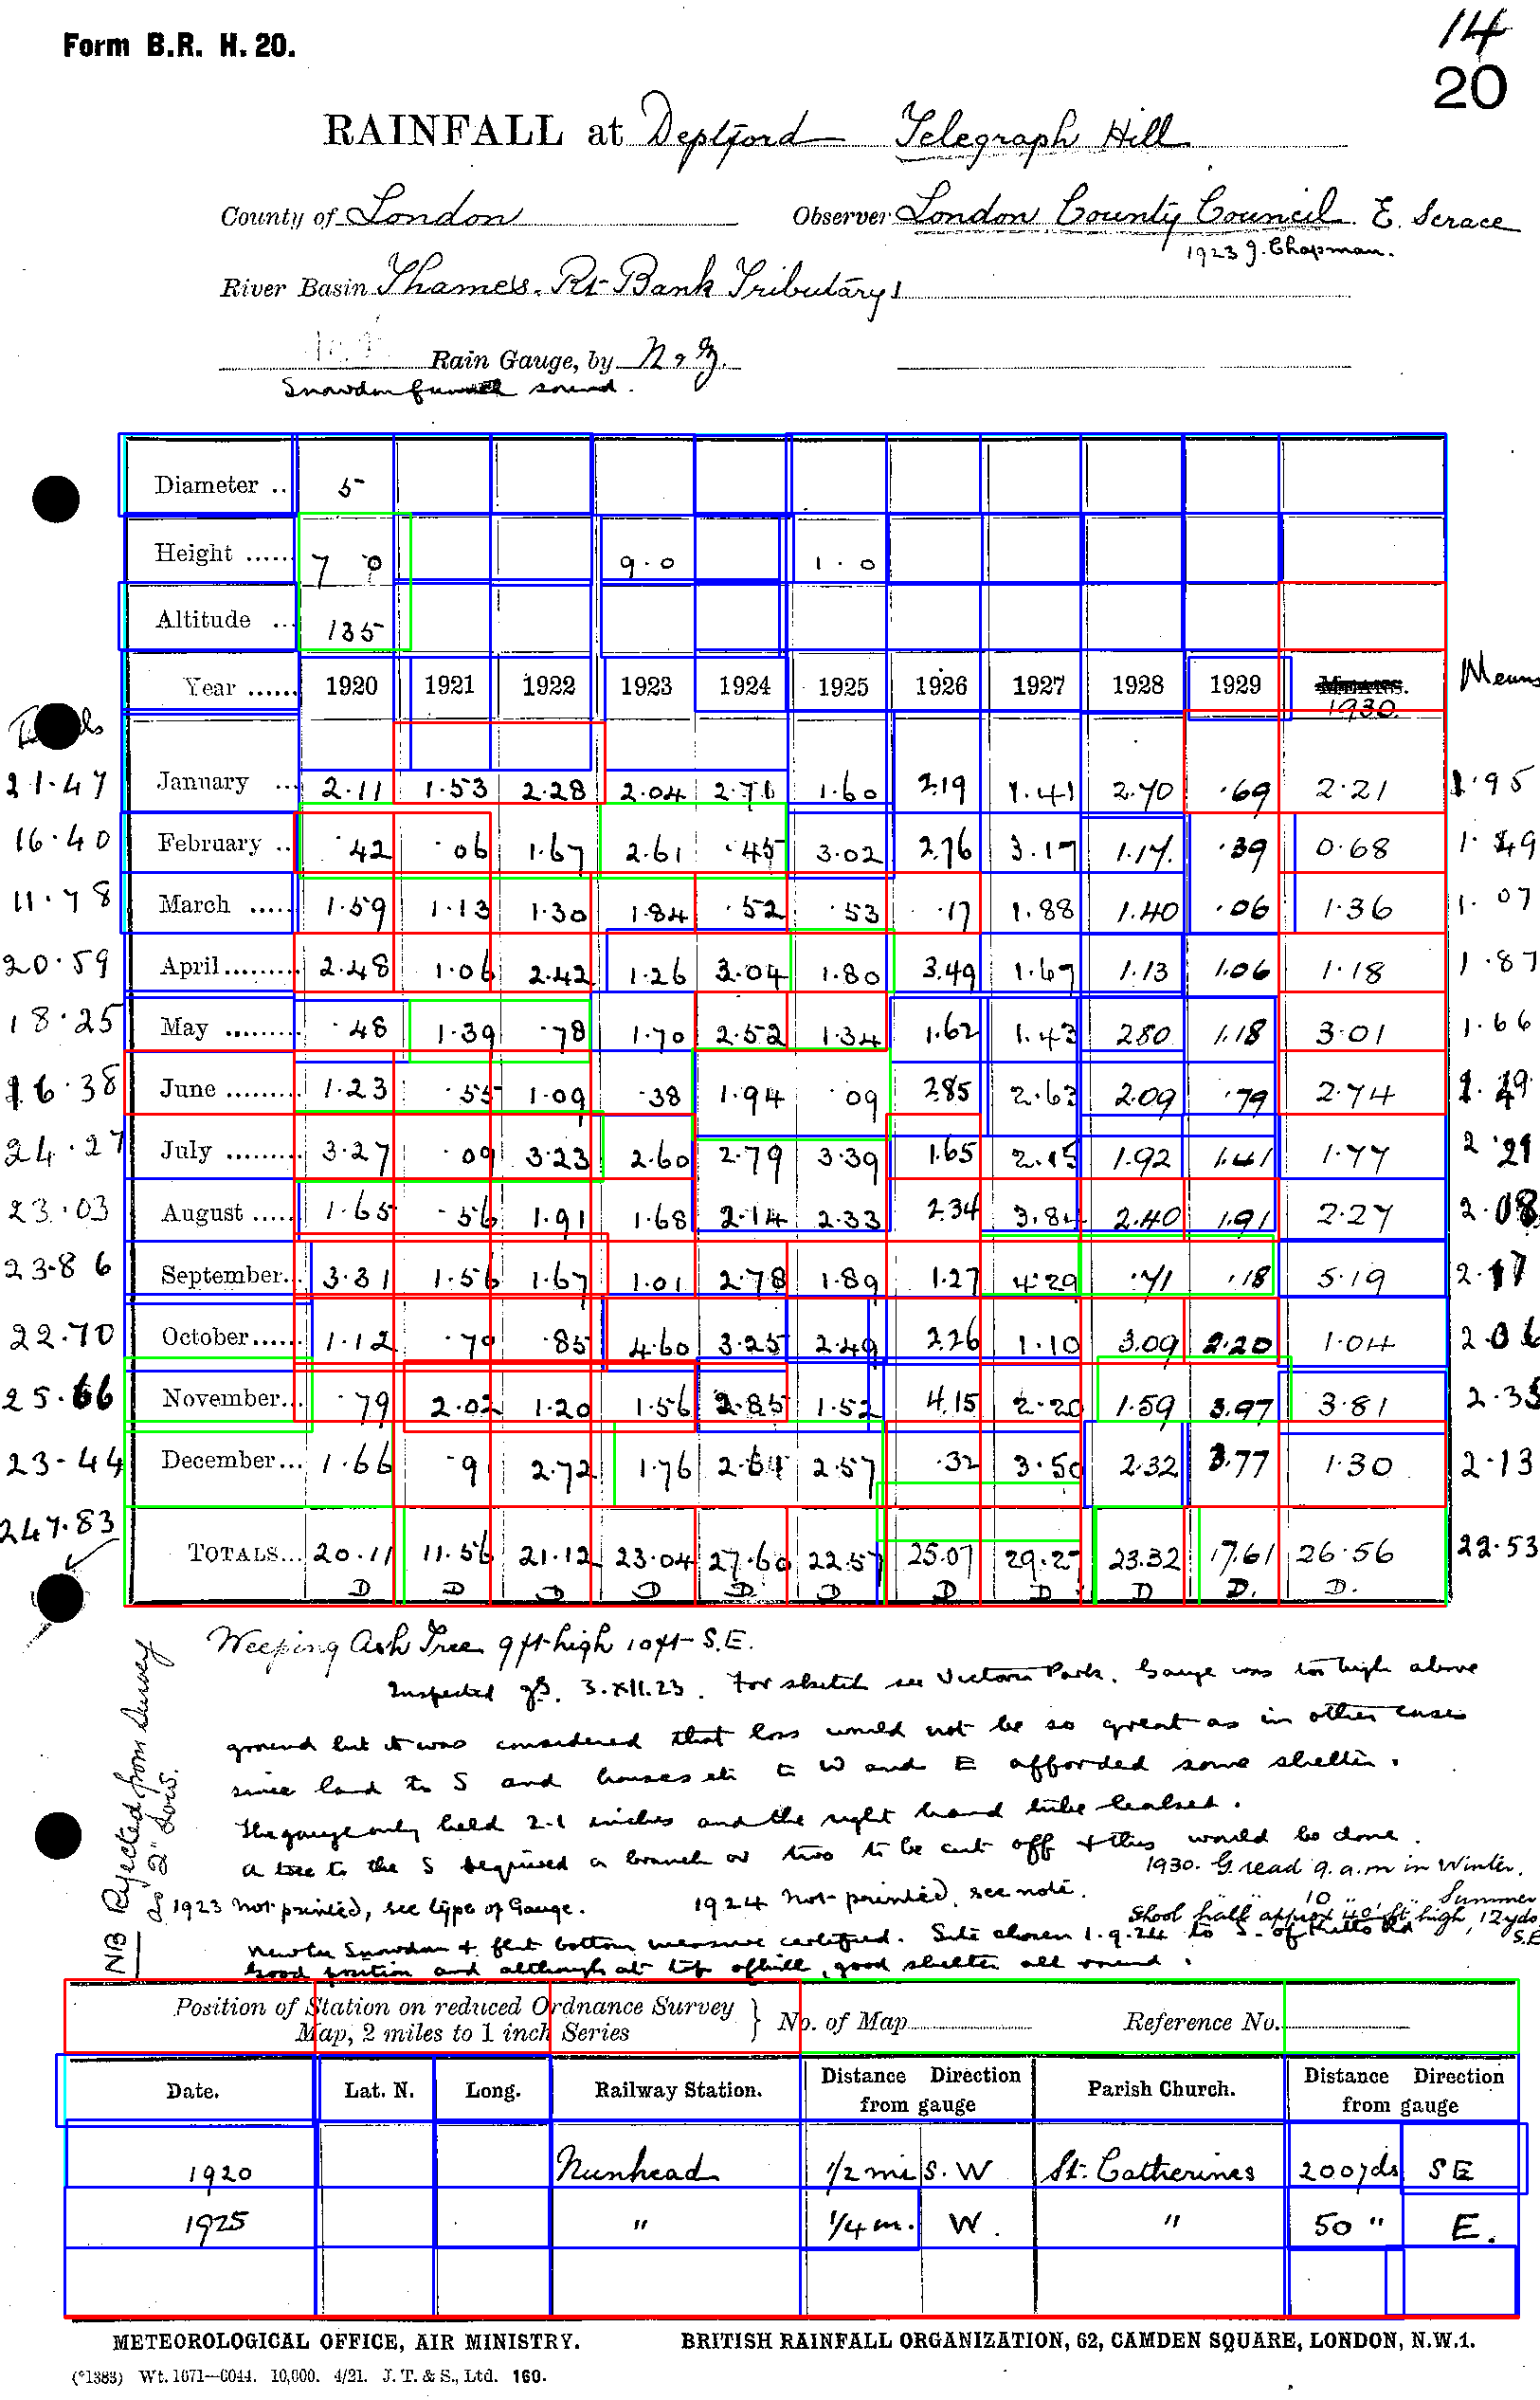

In [43]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(filter_all_valid_cells):
    put_box(image,box,(0,0,color)) # Blue
    
for box in list(filtered_error_corrected_cells):
    put_box(image,box,(0,color,0)) # Red
    
for box in list(not_corrected_excluded_cells):
    put_box(image,box,(color,0,0)) # Green
    
# for box in list(blank_cells):
#     put_box(image,box,(color,color,0)) # Green
    

im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/11.error_merged_segmented.jpg")
im_pil  


In [44]:
new_corrected_excluded_cells, not_corrected_cells = classify_error_cells(not_corrected_excluded_cells, tables, masks[1], average_cordinates,0.7)
error_corrected_cells, all_valid_cells =  find_overlapped_cell(filter_all_valid_cells, filtered_error_corrected_cells+new_corrected_excluded_cells, average_cordinates)

In [45]:
filtered_all_valid_cells =filter_overlapped_cell(all_valid_cells+new_corrected_excluded_cells+error_corrected_cells, average_cordinates)

In [46]:
not_corrected_cells, filter_all_valid_cells =  find_overlapped_cell_final(filter_all_valid_cells, not_corrected_cells, average_cordinates)

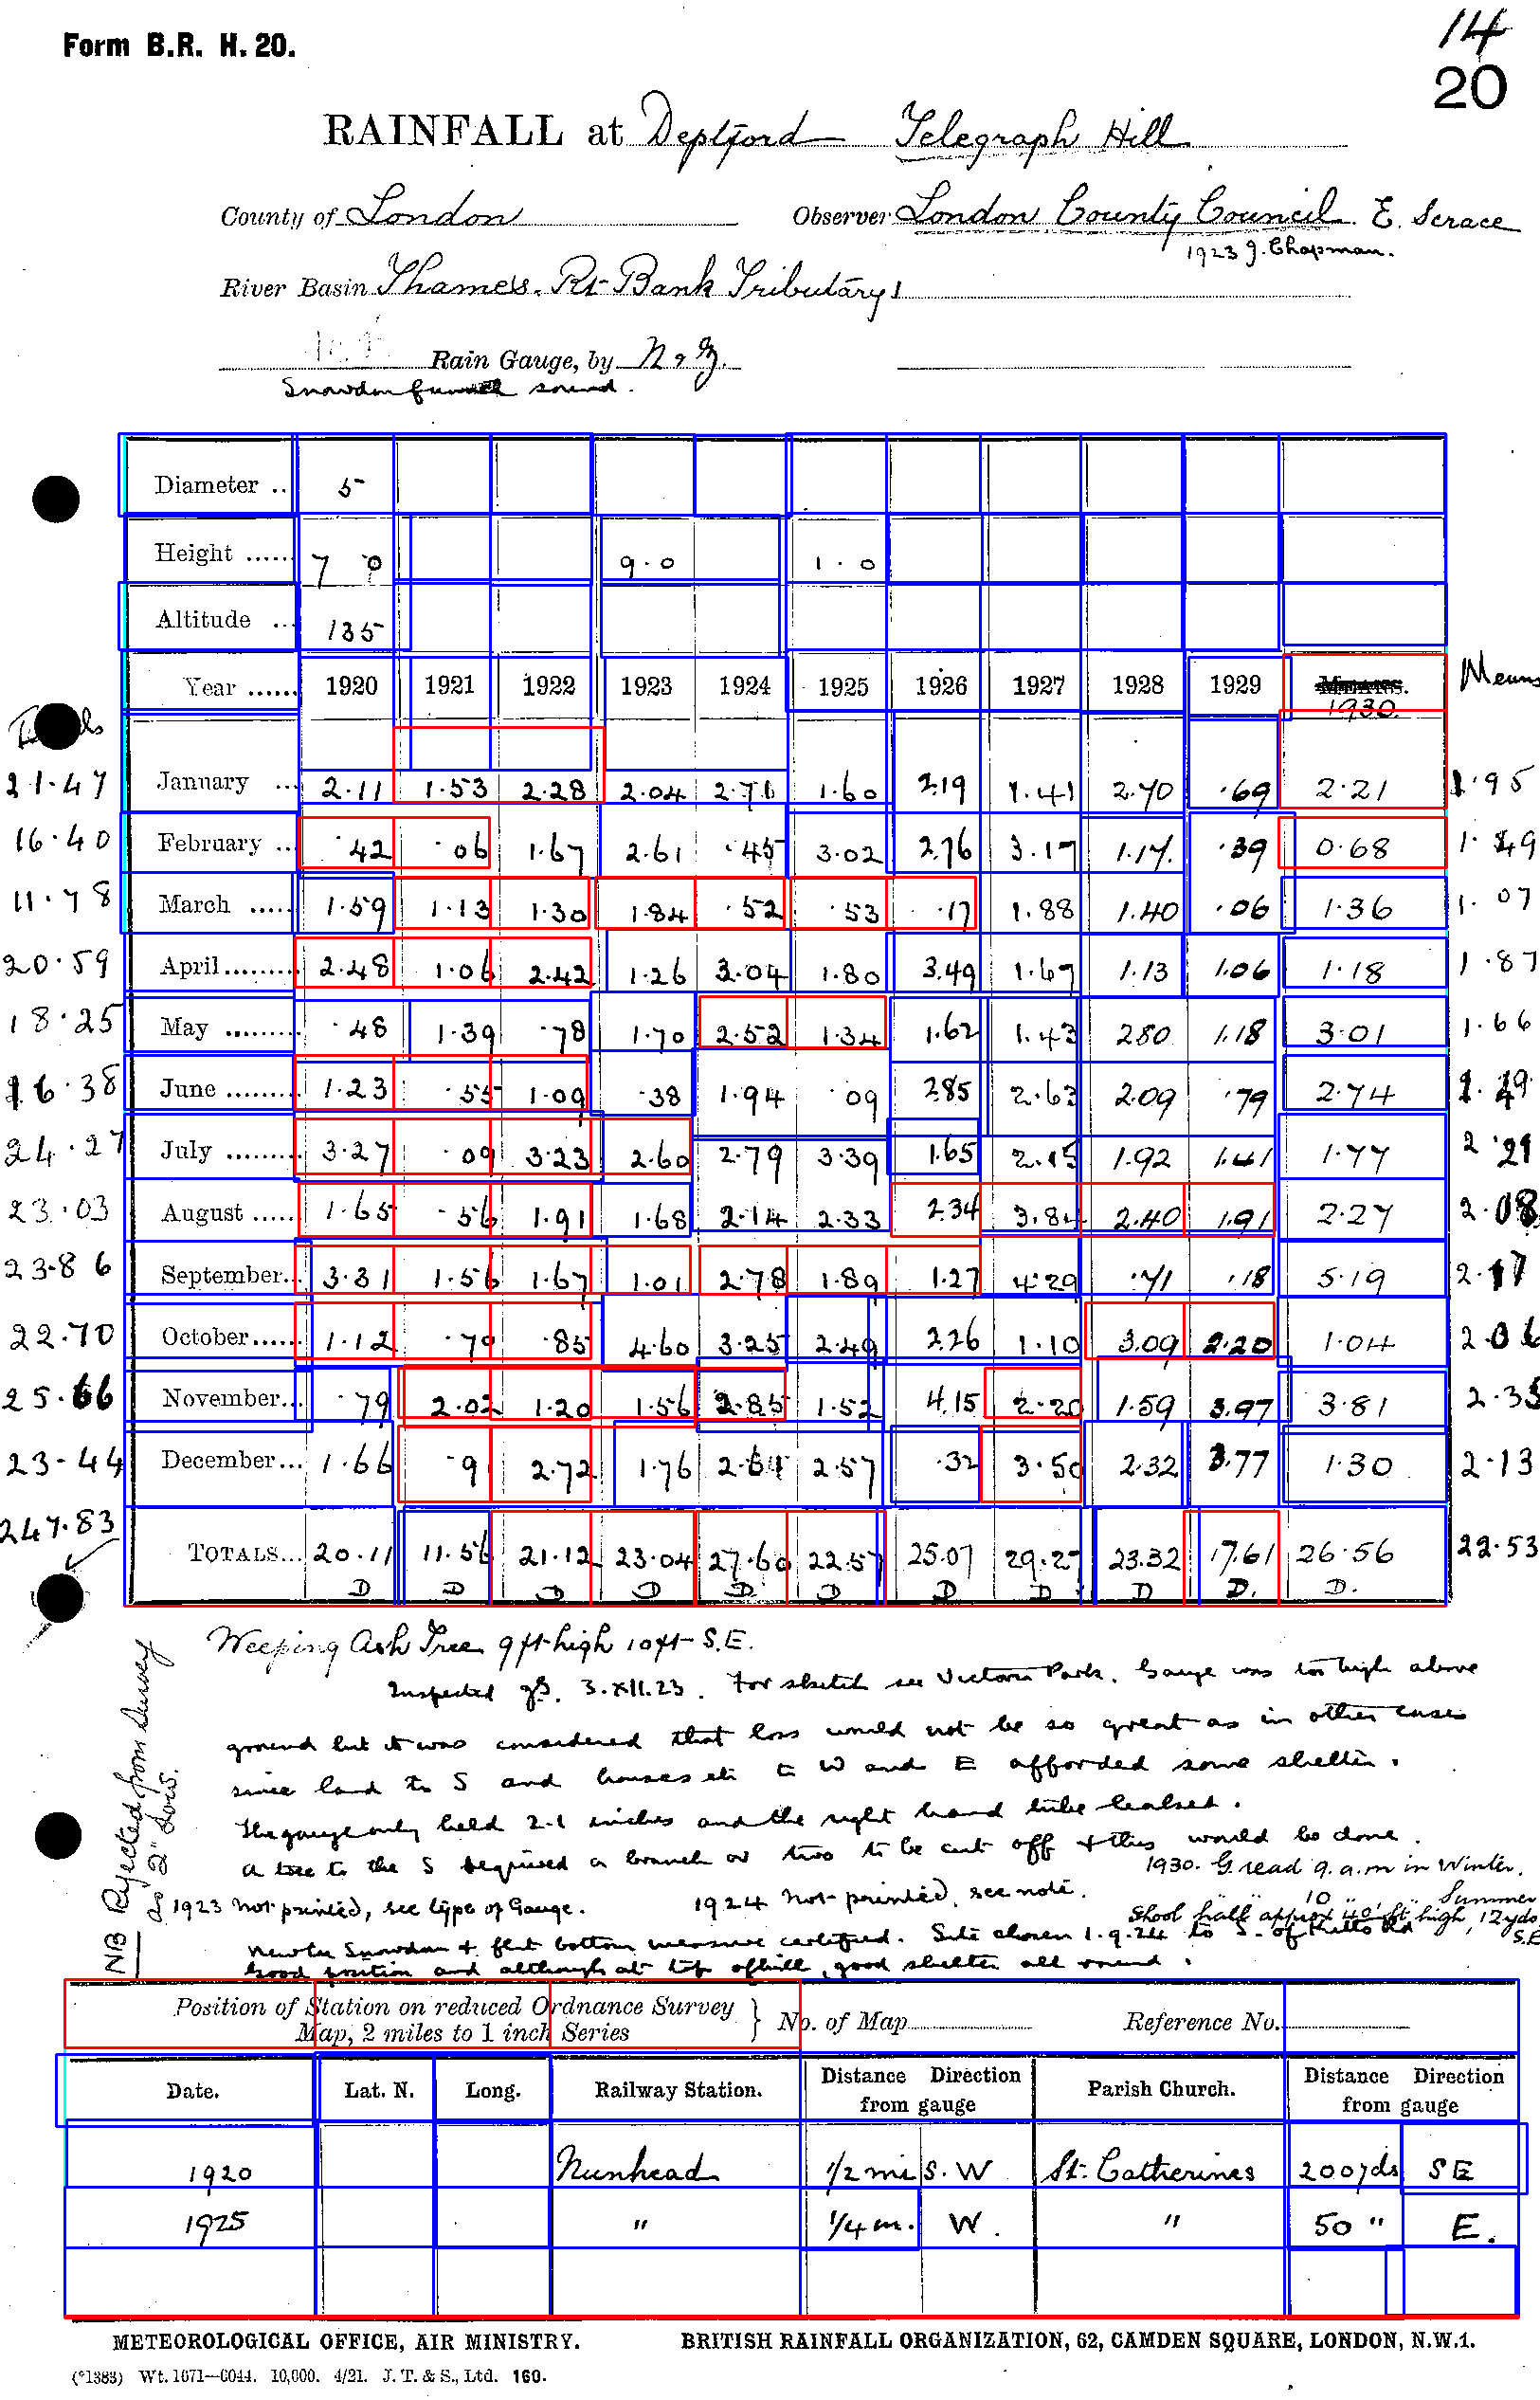

In [47]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in list(filtered_all_valid_cells):
    put_box(image,box,(0,0,color)) # Blue
    
# for box in list(error_corrected_cells):
#     put_box(image,box,(0,color,0)) # Green
    
for box in list(not_corrected_cells):
    put_box(image,box,(color,0,0)) # Green

im_pil = Image.fromarray(image)
# im_pil.save(f"{outdirectory}/{filename}/table_cell_generation_valid_new.jpg")
im_pil  

In [48]:
# blank_cells_new, all_valid_cells =  find_overlapped_cell(all_valid_cells, blank_cells_new, average_cordinates)
# exclude_cells_new, all_valid_cells =  find_overlapped_cell(all_valid_cells+error_corrected_cells+blank_cells_new, exclude_cells_new+not_corrected_excluded_cells, average_cordinates)

In [49]:
considered_cells = filtered_all_valid_cells

In [50]:
correct_cells, blank_cells_new, exclude_cells_new = classify_cells(considered_cells, masks[1], average_cordinates)

In [51]:
new_corrected_excluded_cells, not_corrected_excluded_cells = classify_error_cells(not_corrected_cells+exclude_cells_new, tables, masks[1], average_cordinates,0.7)

In [52]:
not_corrected_excluded_cells, new_corrected_excluded_cells =  find_overlapped_cell(new_corrected_excluded_cells, not_corrected_cells+exclude_cells_new, average_cordinates)

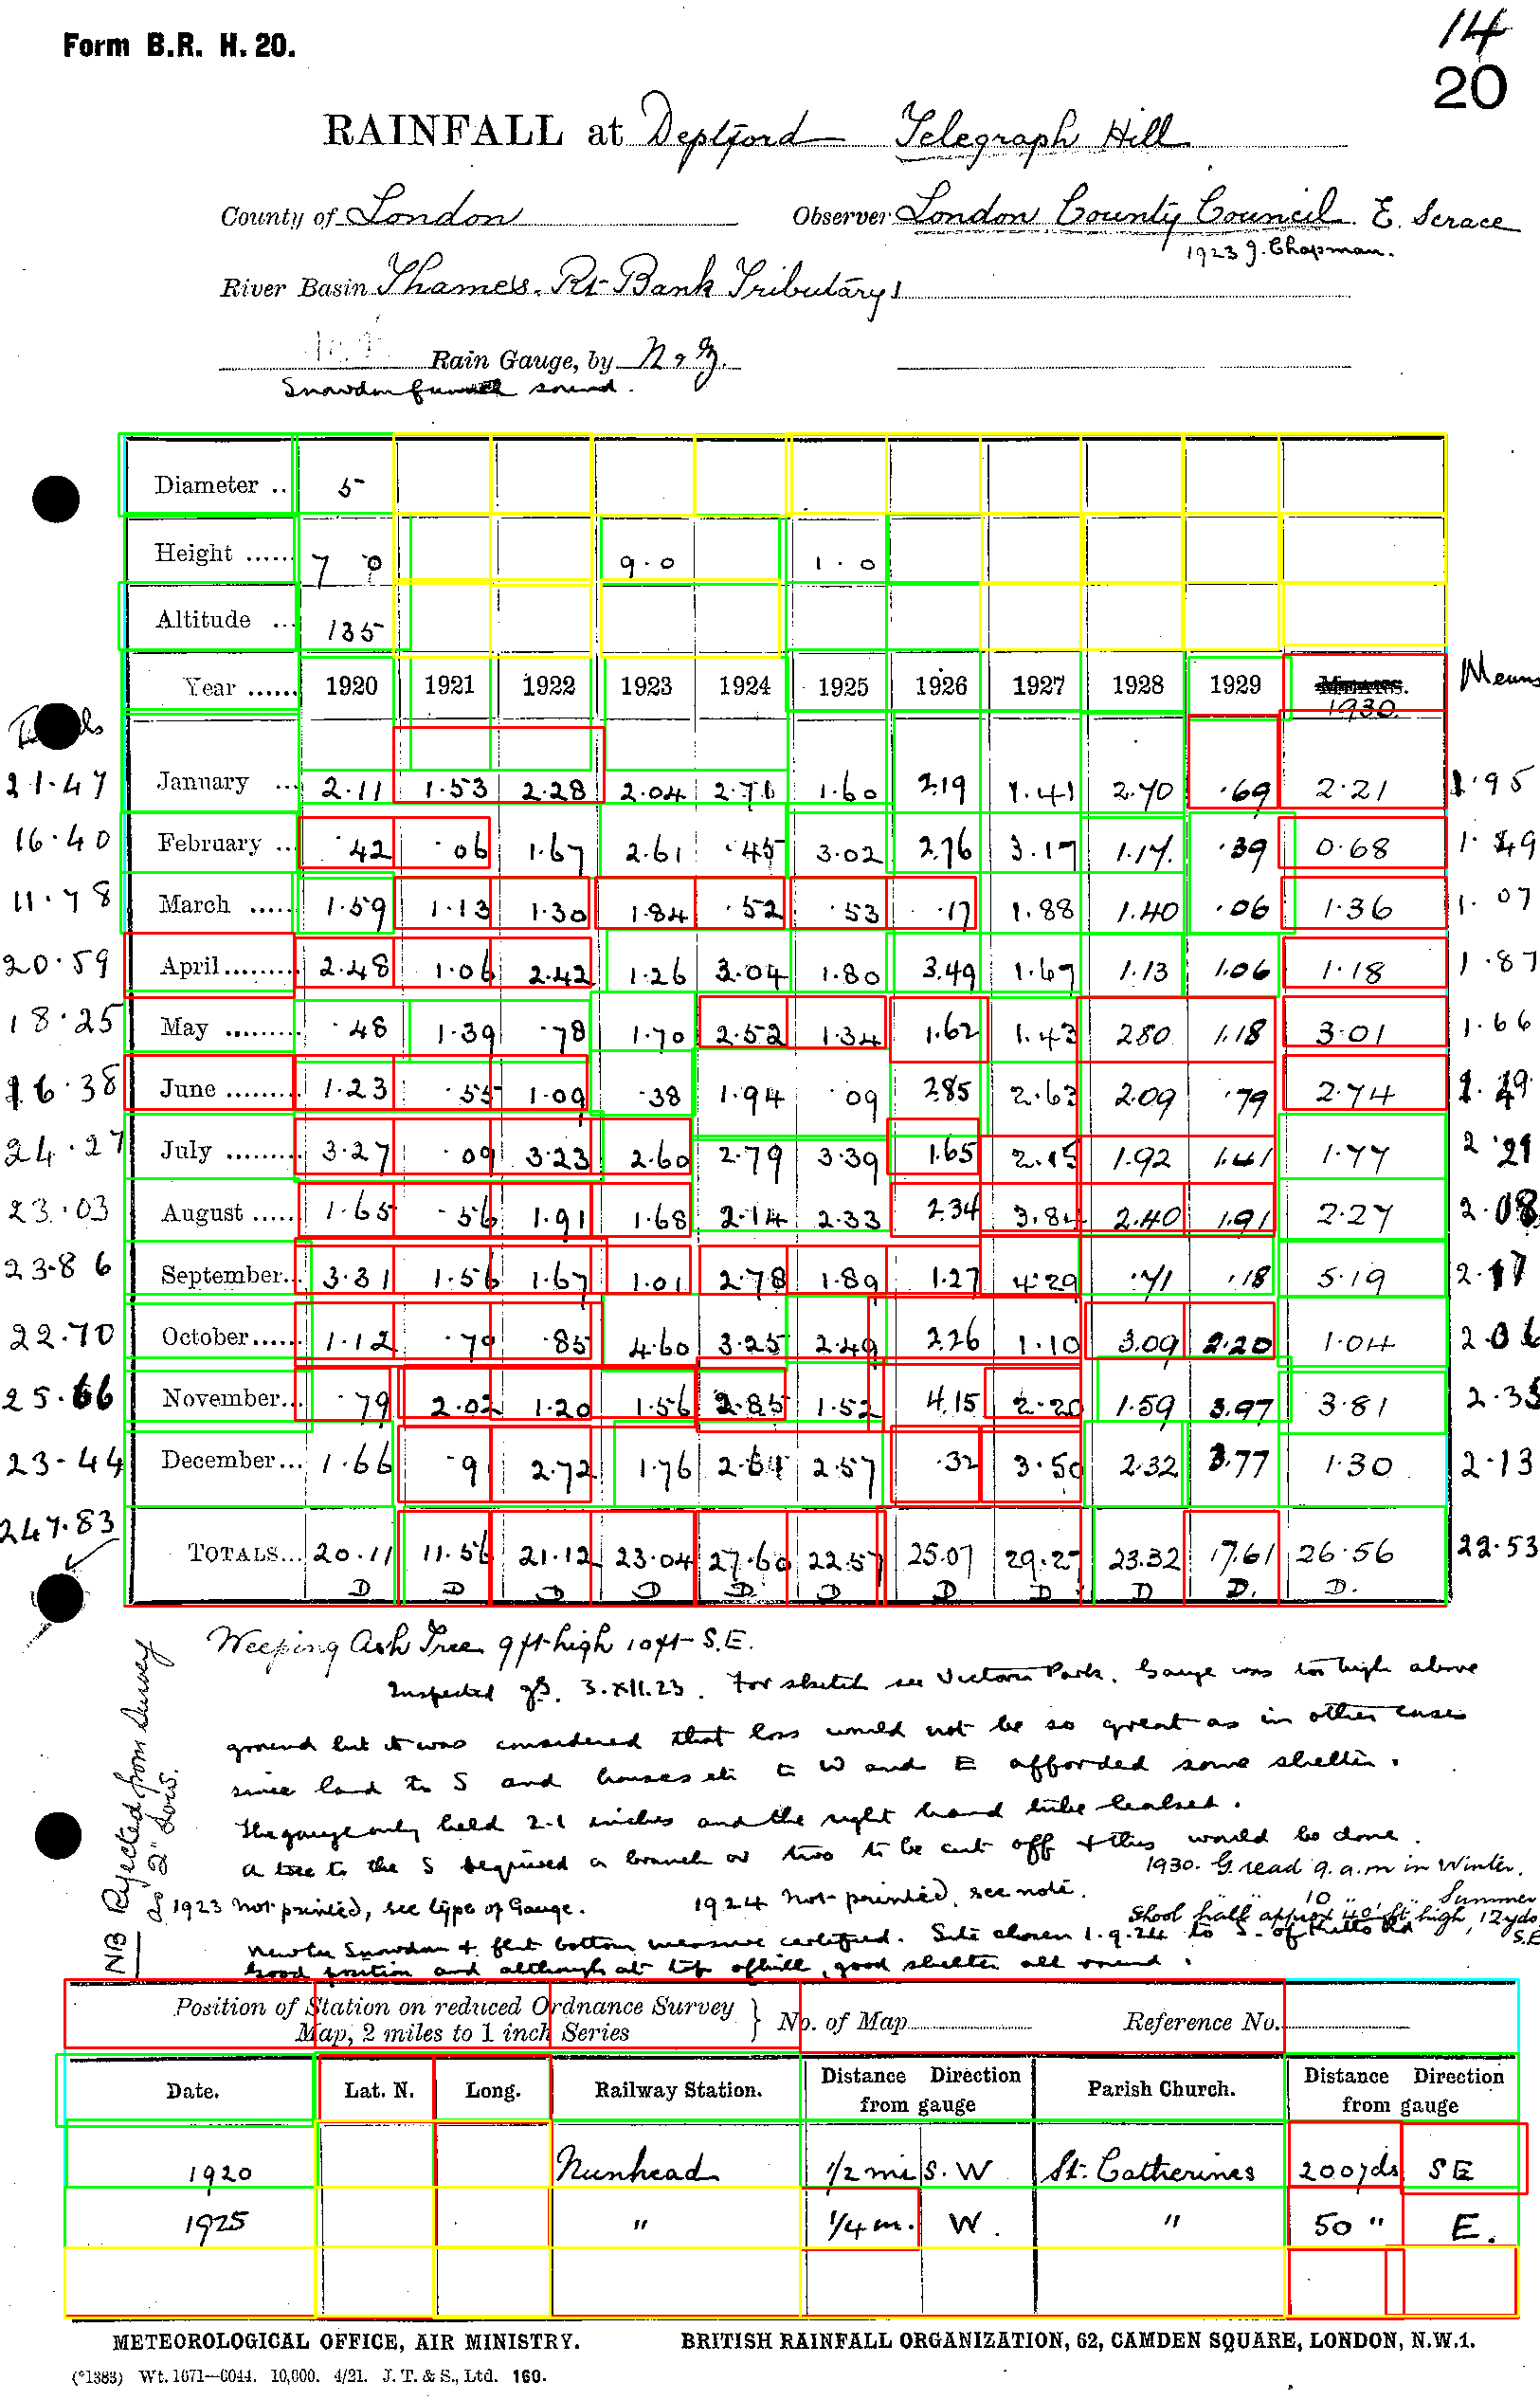

In [53]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 

# for box in considered_cells:
#     put_box(image,box,(0,0,color)) # Blue

for box in correct_cells:
    put_box(image,box,(0,color,0)) # Green

for box in not_corrected_excluded_cells:
    put_box(image,box,(color,0,0)) # Red
    
# for box in new_corrected_excluded_cells:
#     put_box(image,box,(color,0,color))  # pink
    
for box in blank_cells_new:   
    put_box(image,box,(color,color,0)) # Yellow
    


im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/12.final.jpg")
im_pil

In [54]:
considered_cells = correct_cells+blank_cells_new

In [55]:
def filter_overlapped_cell_final(corrected_cells, average_cordinates):
    new_cells_pred = []
    large_cells = []
    for i, box in enumerate(corrected_cells):
        count=0       
        tid = box[4]
        avg_x, avg_y = average_cordinates[tid]
        xi = abs(box[2]-box[0])
        yi = abs(box[3]-box[1])
                
        if xi/avg_x<3 and yi/avg_y<3:
            if len(new_cells_pred)==0:
                new_cells_pred.append(box)
            else:
                for j, cells in enumerate(new_cells_pred): 
                    xj = abs(cells[2]-cells[0])
                    yj = abs(cells[3]-cells[1])

                    if check_cell(cells, average_cordinates) and check_cell(box, average_cordinates) :
                        if tsa.how_much_contained(cells,box)>0.5:
    #                         if (max(yj,yi)/min(yj,yi))<3 and (max(xj,xi)/min(xj,xi))<3:
                            count+=1
                            break

                        elif tsa.how_much_contained(box, cells)>0.5:
    #                         if (max(yj,yi)/min(yj,yi))<3 and (max(xj,xi)/min(xj,xi))<3:
                            count+=1
                            break

        else:
            large_cells.append(box)
            count+=1
            
        if count==0:
            new_cells_pred.append(box)
            
    return new_cells_pred,large_cells

In [56]:
filter_considered_cells,large_cells =filter_overlapped_cell_final(considered_cells, average_cordinates)
large_cells, filter_considered_cells =  find_overlapped_cell_final(filter_considered_cells, large_cells, average_cordinates)

In [57]:
large_cells

[[426, 1589, 933, 1694, 1], [1154, 1589, 1525, 1694, 1]]

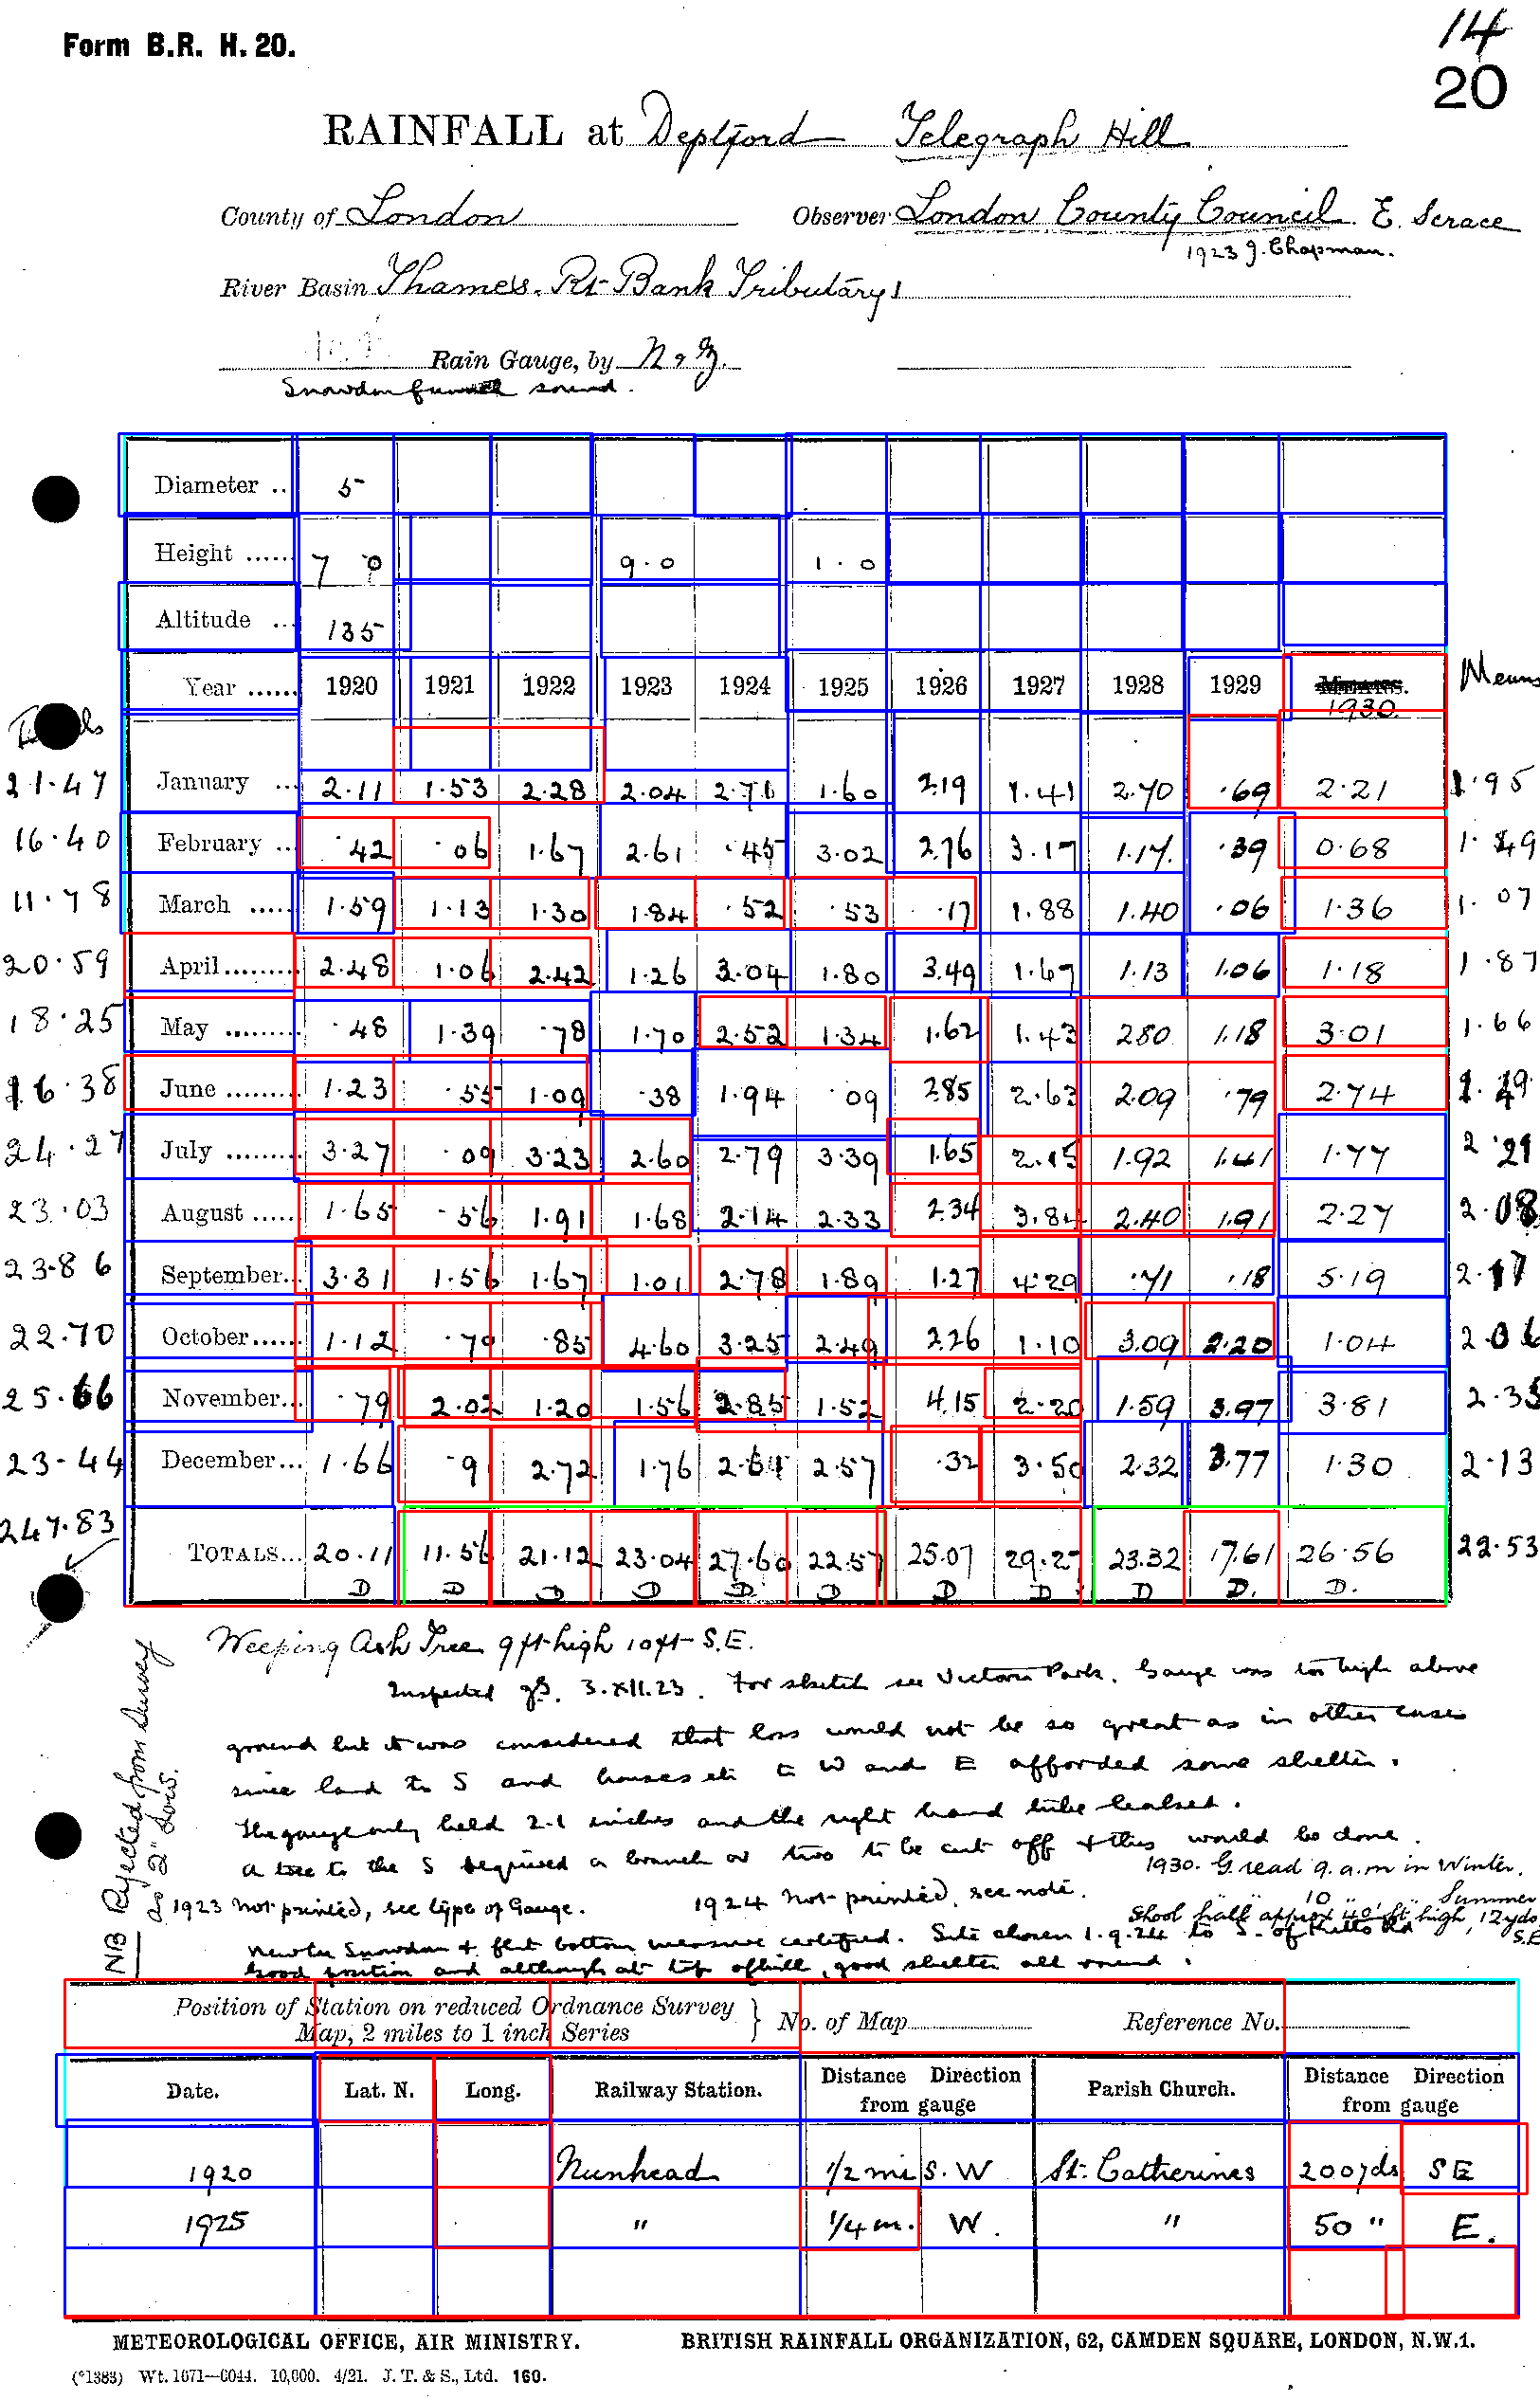

In [58]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 

# for box in considered_cells:
#     put_box(image,box,(0,0,color)) # Blue
    
for box in filter_considered_cells:
    put_box(image,box,(0,0,color)) # Blue

for box in large_cells:   
    put_box(image,box,(0,color,0)) # Yellow
    
for box in not_corrected_excluded_cells:
    put_box(image,box,(color,0,0))  # pink


im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/13.final_considered.jpg")
im_pil

In [59]:
table_cells = get_x_y(tables, filter_considered_cells) 
cell_cordinates, average_cordinates = get_coordinates(table_cells,0.7)

possible_cells, exclude_cells_pred = generate_cells(masks[1], tables, cell_cordinates, average_cordinates)
exclude_cells_pred, considered_cells = find_overlapped_cell_final(filter_considered_cells, exclude_cells_pred, average_cordinates)

In [60]:
new_corrected_excluded_cells, exclude_cells_pred = classify_error_cells(exclude_cells_pred, tables, masks[1], average_cordinates,0.7)

In [61]:
possible_cells, considered_cells = find_overlapped_cell_final(filter_considered_cells, possible_cells, average_cordinates)
exclude_cells_pred, all_valid_cells = find_overlapped_cell_final(filter_considered_cells+possible_cells+new_corrected_excluded_cells, exclude_cells_pred, average_cordinates)

In [67]:
def classify_cells(cells, mask, average_coordinates):

    cells = [x[0:5] for x in cells]
    x = torch.IntTensor(cells)
    x = x[:,0:4]
    value, index = x[:,1].sort()

    corrected_cells_new = []
    exclude_cells_new = []
    blank_cells_new = []

    for idx in index:
        imagedraw = cells[idx][0:4]
        tid = cells[idx][4]
        imagedraw = list(map(int, imagedraw))

        x_avg,y_avg = average_coordinates[tid]
        
        if check_cell(imagedraw+[tid],average_cordinates):

            boolean, scores = check_bounding_box(imagedraw,mask)

            objects = has_object(imagedraw, mask)

            if all(boolean) and objects:
                corrected_cells_new.append(cells[idx])

            elif not objects:
                blank_cells_new.append(cells[idx])

            else:
                exclude_cells_new.append(cells[idx])

    return corrected_cells_new, blank_cells_new, exclude_cells_new

In [62]:
correct_cells, blank_cells_new, exclude_cells_new = classify_cells(exclude_cells_pred, masks[1], average_cordinates)

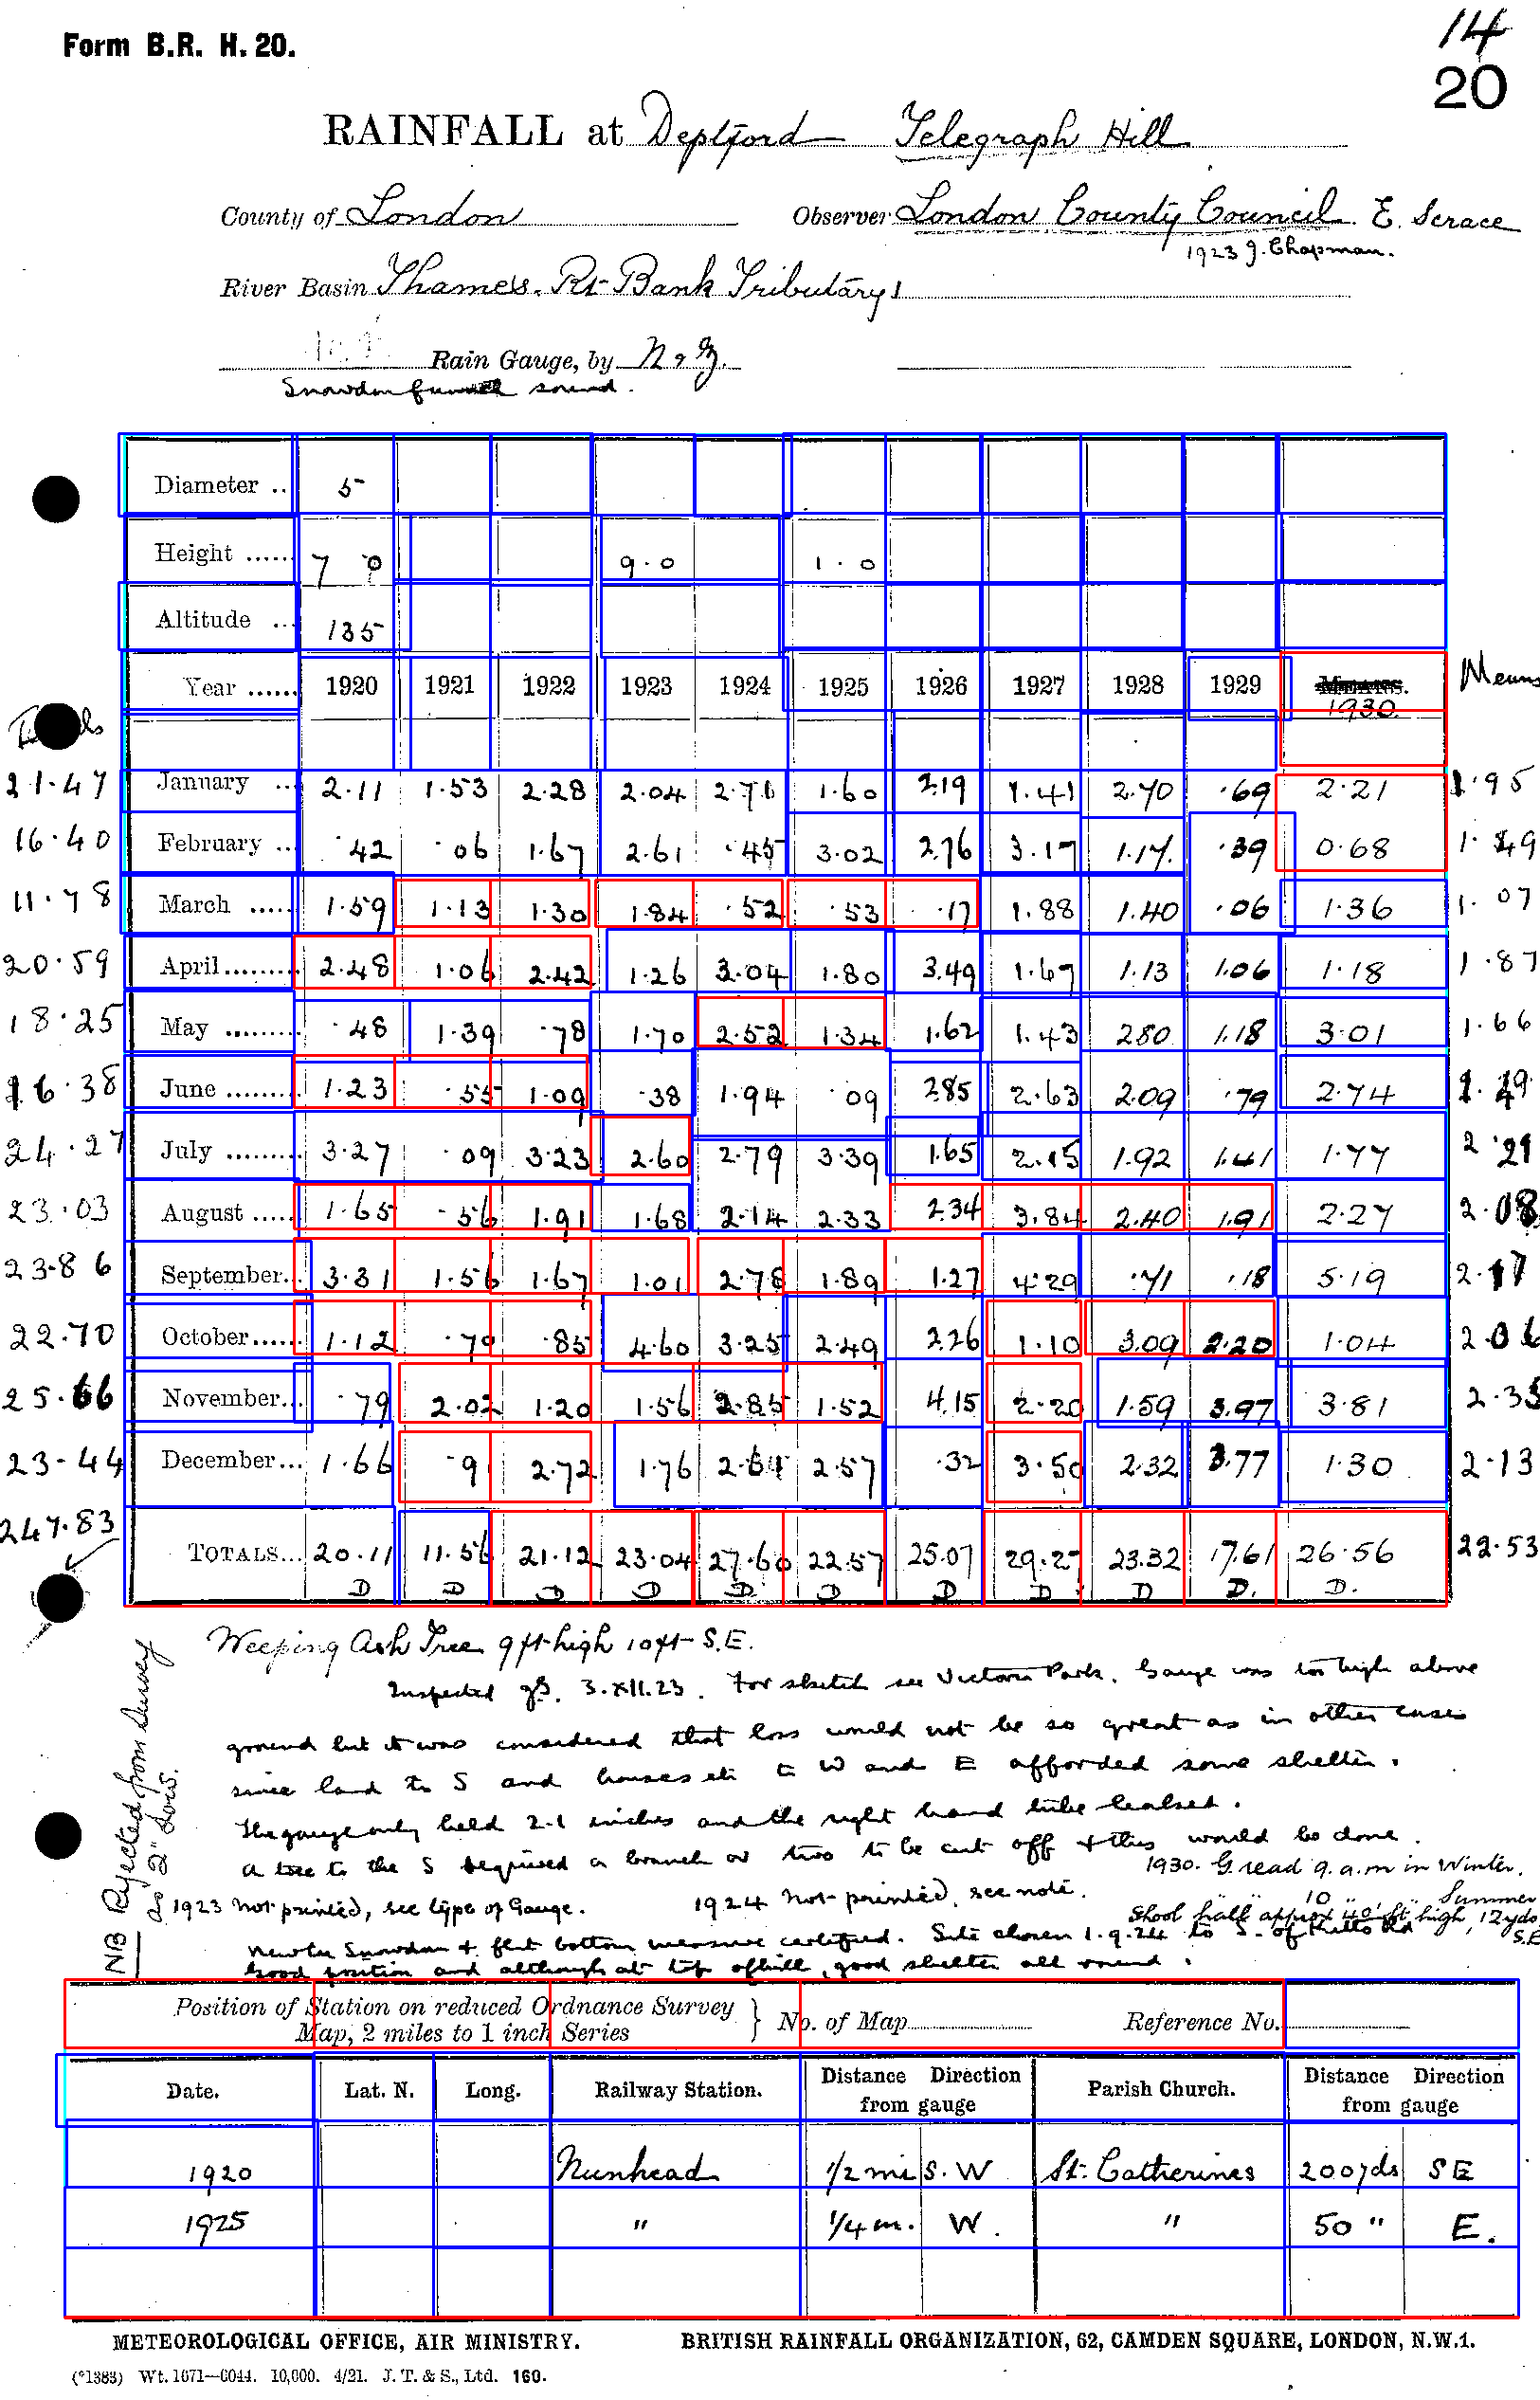

In [63]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 

for box in all_valid_cells:
    put_box(image,box,(0,0,color)) # Blue
    
for box in correct_cells:
    put_box(image,box,(0,color,0)) # Blue
    
for box in blank_cells_new:
    put_box(image,box,(color,color,0)) # Blue
    
for box in exclude_cells_new:
    put_box(image,box,(color,0,0)) # Blue
        
# for box in exclude_cells_pred:
#     put_box(image,box,(color,0,0))  # pink


im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/13.final_considered.jpg")
im_pil

In [64]:
neighbouring_cells, y_cords, x_cords = get_x_y_neighbour_cells(exclude_cells_new, tables, average_cordinates)#

In [65]:
x_y_neighbouring_cells_dict = {}
if len(exclude_cells_new)>0:
    neighbouring_cells, y_cords, x_cords = get_x_y_neighbour_cells(exclude_cells_new, tables, average_cordinates)

    for yid in neighbouring_cells:
        cells = neighbouring_cells[yid]

        y_neighbours = cells[0]
        x_neighbours = cells[1]

        tid =x_neighbours[0][4]

        avg_x, avg_y = average_cordinates[tid]

        # print(yid,y_neighbours,x_neighbours,tid, average_cordinates[tid])

        # find x_neighbours
        ncells = []
        imagedraw = []
        next_cell_begin = True
        starting_cell = []

        for xid, xcell in enumerate(x_neighbours):    

            # Either split the cell or merge to begining cell
            if next_cell_begin:
                starting_cell = list(xcell)
            else:
                starting_cell[2] = xcell[2]

            # check next cell distance
            if (xid+1)<len(x_neighbours):
                next_cell = x_neighbours[xid+1]
                if abs(next_cell[0]-xcell[2])<(avg_x/3):
                    next_cell_begin = False
                else:
                    ncells.append(starting_cell)
                    starting_cell = []
                    next_cell_begin = True
            elif len(x_neighbours)==1:
                ncells.append(starting_cell)
                starting_cell = []

        if len(starting_cell)>0:
            ncells.append(starting_cell)

    #     print(x_neighbours,'---',ncells)   
        x_y_neighbouring_cells_dict[yid] = (y_neighbours, ncells)


y_neighbours_new = {}
if len(x_y_neighbouring_cells_dict)>0:
    yids = list(x_y_neighbouring_cells_dict.keys())
    count = 0
    y_neighbours = {}
    cur_list = []

    for i, j in zip(yids[:-1],yids[1:]):
        if count == 0:  # First index
            cur_list.append(i)        
        if (j-i) < avg_y:
            cur_list.append(j)
        else:
            y_neighbours[cur_list[0]] = cur_list
            cur_list = [j]
        count+=1

    if cur_list[0] not in y_neighbours:
        y_neighbours[cur_list[0]] = cur_list

    for yid in y_neighbours:
        for yidn in y_neighbours[yid]:
            y_neighbours_new[yidn] = y_neighbours[yid]
    #         if yidn not in y_neighbours:
    #             print(y_neighbours[yid])



============688================== 
Above cells:[] 
Current cells: [[1351, 688, 1526, 749, 1]] 
Below cells: [[1351, 749, 1526, 807, 1]]


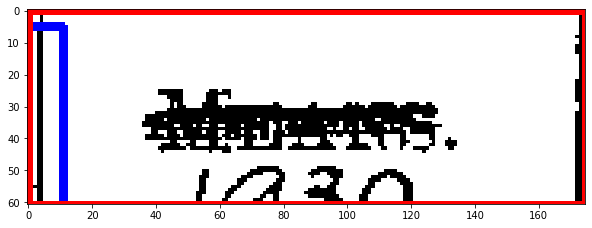

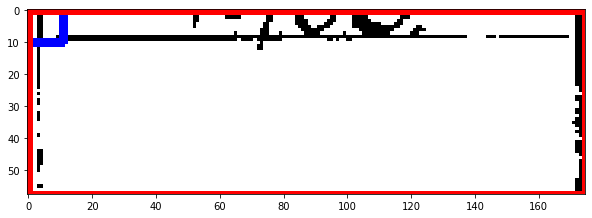

============749================== 
Above cells:[[1351, 688, 1526, 749, 1]] 
Current cells: [[1351, 749, 1526, 807, 1]] 
Below cells: []


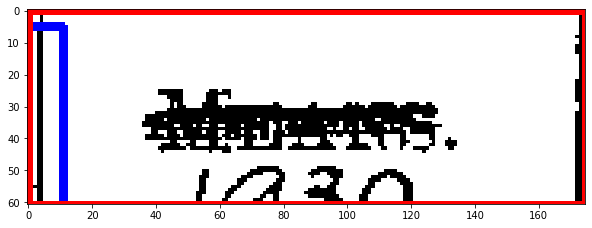

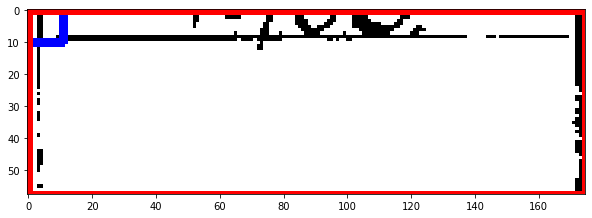

============817================== 
Above cells:[] 
Current cells: [[1346, 817, 1526, 918, 1]] 
Below cells: []


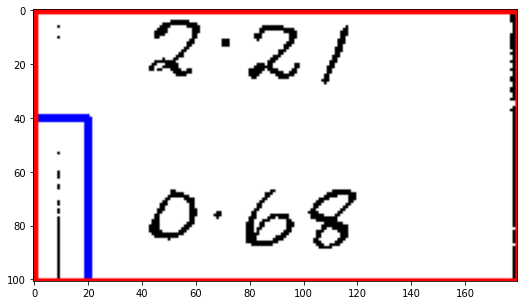

============987================== 
Above cells:[] 
Current cells: [[310, 987, 623, 1042, 1]] 
Below cells: [[310, 1113, 619, 1168, 1]]


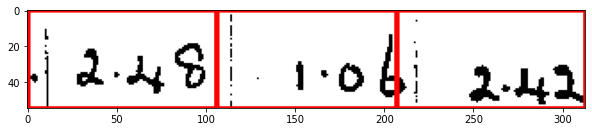

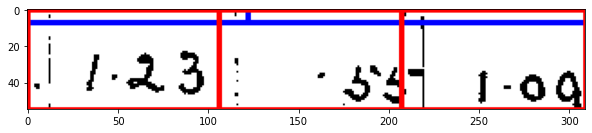

============1052================== 
Above cells:[] 
Current cells: [[826, 1052, 933, 1105, 1]] 
Below cells: []


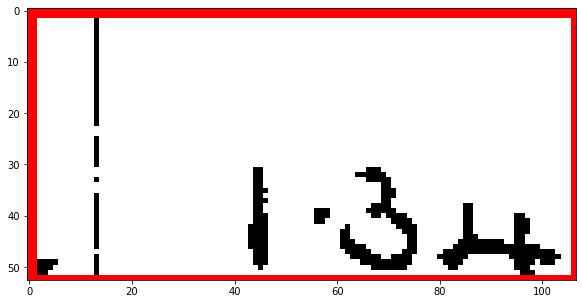

============1113================== 
Above cells:[[310, 987, 623, 1042, 1]] 
Current cells: [[310, 1113, 619, 1168, 1]] 
Below cells: [[310, 1306, 726, 1362, 1], [826, 1306, 1036, 1363, 1]]


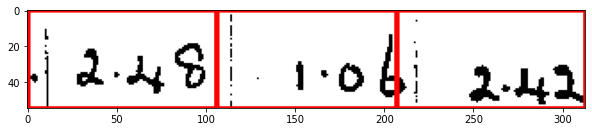

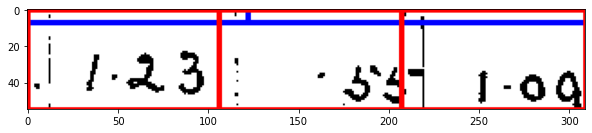

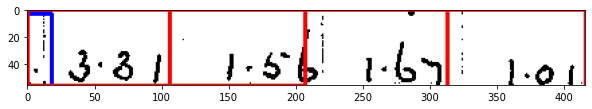

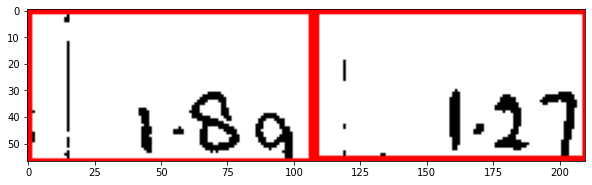

============1178================== 
Above cells:[] 
Current cells: [[623, 1178, 727, 1239, 1]] 
Below cells: [[310, 1306, 726, 1362, 1], [826, 1306, 1036, 1363, 1]]


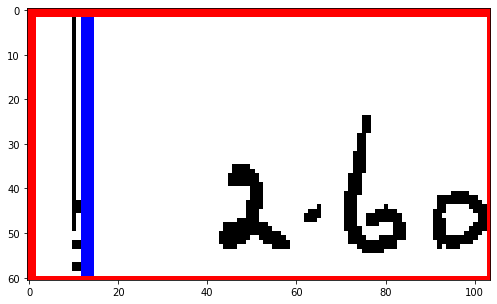

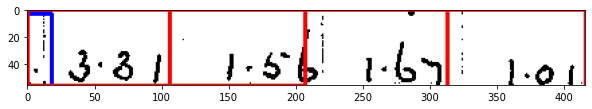

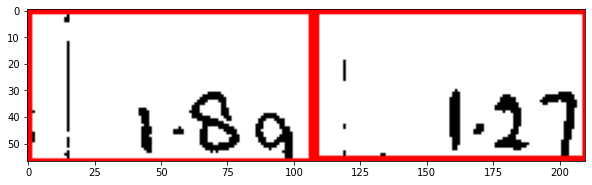

============1306================== 
Above cells:[[623, 1178, 727, 1239, 1]] 
Current cells: [[310, 1306, 726, 1362, 1], [826, 1306, 1036, 1363, 1]] 
Below cells: [[421, 1438, 930, 1500, 1], [1041, 1438, 1140, 1500, 1]]


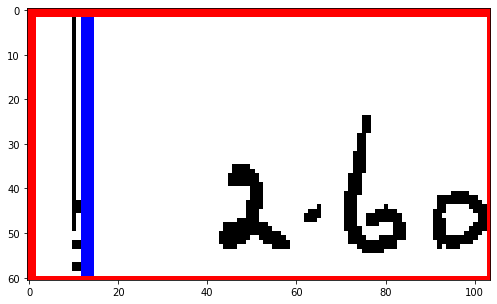

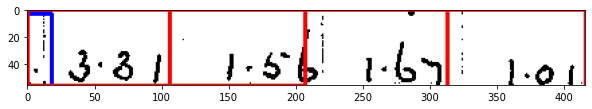

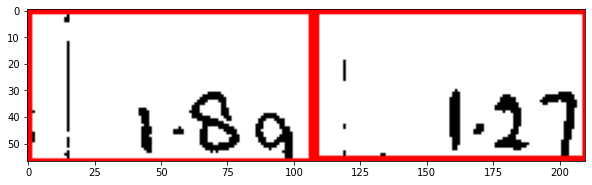

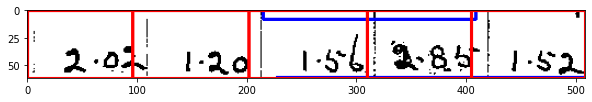

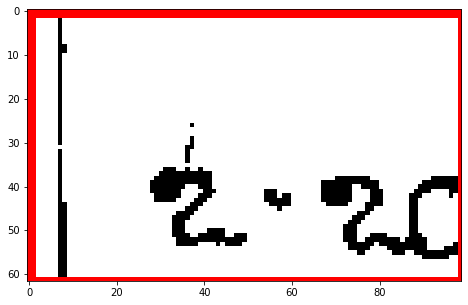

============1372================== 
Above cells:[[310, 1306, 726, 1362, 1], [826, 1306, 1036, 1363, 1]] 
Current cells: [[310, 1372, 623, 1428, 1], [1041, 1372, 1344, 1430, 1]] 
Below cells: [[421, 1510, 623, 1584, 1], [1041, 1510, 1140, 1584, 1]]


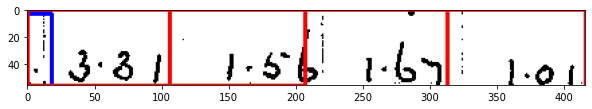

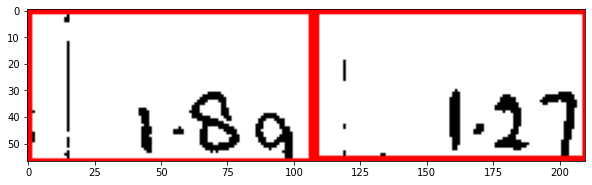

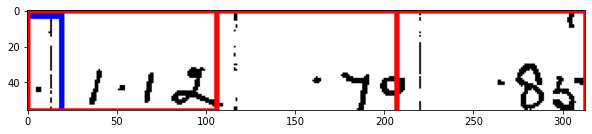

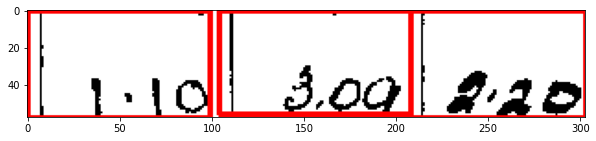

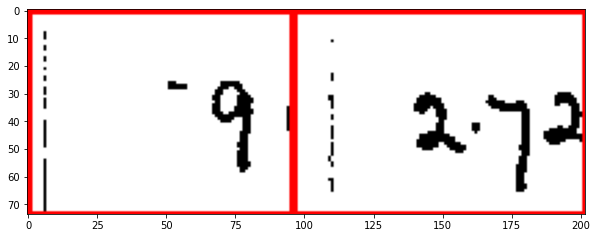

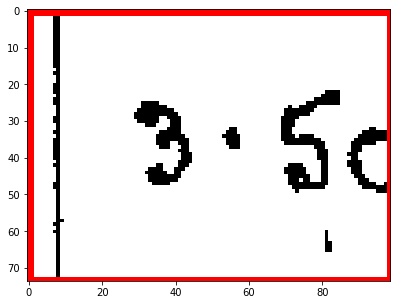

============1438================== 
Above cells:[[310, 1372, 623, 1428, 1], [1041, 1372, 1344, 1430, 1]] 
Current cells: [[421, 1438, 930, 1500, 1], [1041, 1438, 1140, 1500, 1]] 
Below cells: [[518, 1594, 933, 1694, 1], [1038, 1594, 1526, 1694, 1]]


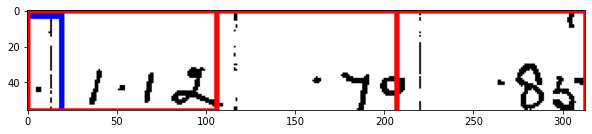

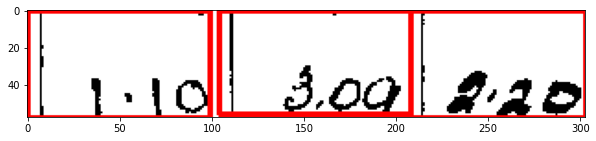

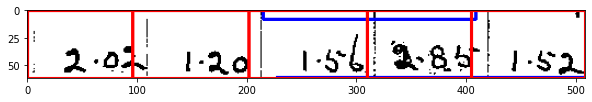

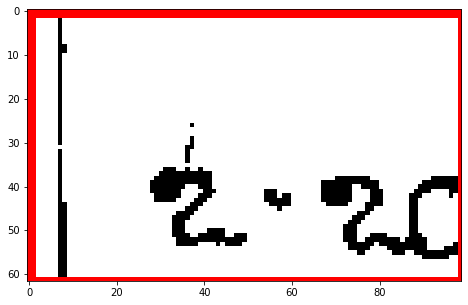

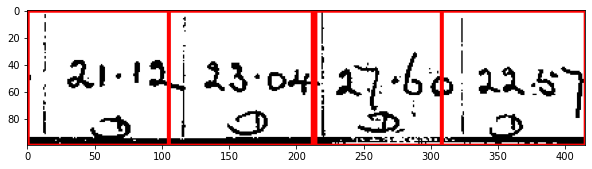

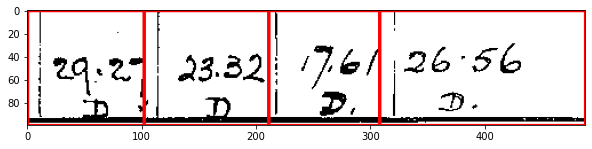

============1510================== 
Above cells:[[310, 1372, 623, 1428, 1], [1041, 1372, 1344, 1430, 1]] 
Current cells: [[421, 1510, 623, 1584, 1], [1041, 1510, 1140, 1584, 1]] 
Below cells: []


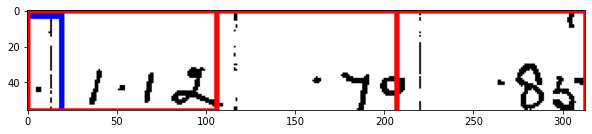

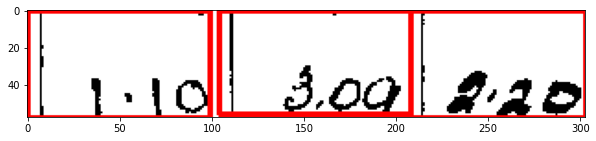

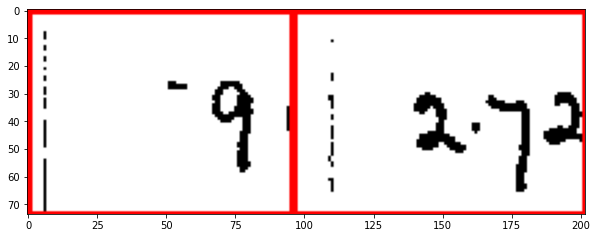

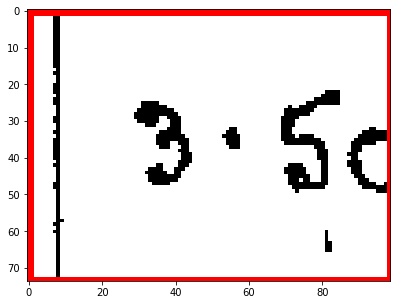

============1594================== 
Above cells:[[421, 1438, 930, 1500, 1], [1041, 1438, 1140, 1500, 1]] 
Current cells: [[518, 1594, 933, 1694, 1], [1038, 1594, 1526, 1694, 1]] 
Below cells: []


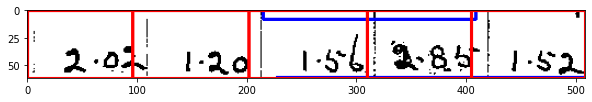

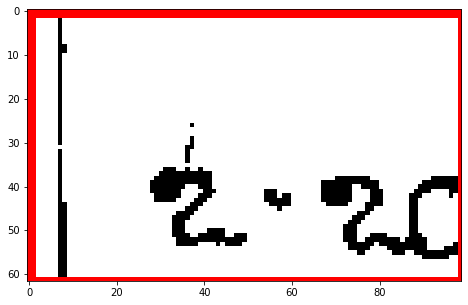

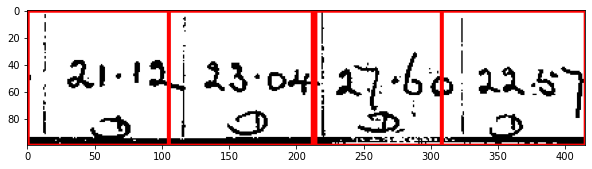

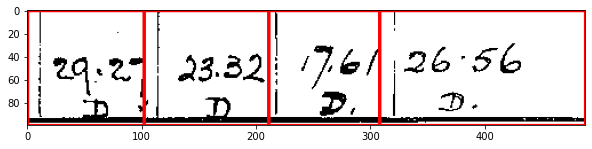

============2088================== 
Above cells:[] 
Current cells: [[68, 2088, 1354, 2160, 0]] 
Below cells: []


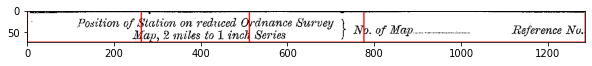

In [66]:
# combine x and y neighbours v2
error_merged_cells = []
neighbours = []
if len(x_y_neighbouring_cells_dict)>0:
    for yid in x_y_neighbouring_cells_dict:
        ynid, xnid = x_y_neighbouring_cells_dict[yid]

        above_cells = []
        cur_cells = []
        below_cells = []
        for y_n in ynid:
            if y_n < yid:
                above_cells = x_y_neighbouring_cells_dict[y_n][1]
            else:
                cur_cells = xnid
                if y_n > yid:
                    below_cells = x_y_neighbouring_cells_dict[y_n][1]
                
        print(f'============{yid}================== \nAbove cells:{above_cells} \nCurrent cells: {xnid} \nBelow cells: {below_cells}')
        
        
        for cur_cell2 in xnid:
            xc0,yc0,xc1,yc1,tid = cur_cell2[0:5]
            avg_x, avg_y = average_cordinates[tid]
            cur_neigh = []
            for cur_cell_a in above_cells:
                xa0,ya0,xa1,ya1,tid_a = cur_cell_a[0:5]
                if abs(ya1-yc0)<avg_y*0.1 and abs(xa0-xc0)<avg_x*0.1 : #10% of average size
                    cur_neigh.append(cur_cell_a)
            cur_neigh.append(cur_cell2)
            for cur_cell_b in below_cells:
                xb0,yb0,xb1,yb1,tid_b = cur_cell_b[0:5]
                if abs(yb0-yc1)<avg_y*0.1 and abs(xb0-xc0)<avg_x*0.1 : #10% of average size
                    cur_neigh.append(cur_cell_b)
            neighbours.append(cur_neigh)
        
        for cur_cell2 in above_cells:
            tid = cur_cell2[4]
            croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
            plt.rcParams["figure.figsize"] = (10,5)
            plt.imshow(croppedimage_full)
#             plt.title(f'corrected cell of {cur_cell2} {average_cordinates[tid]}, x-dist: {abs(cur_cell2[0]-cur_cell2[2])}, y-dist: {abs(cur_cell2[1]-cur_cell2[3])}')
            plt.show() 
    
        for cur_cell2 in xnid:
            tid = cur_cell2[4]
            croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
            plt.rcParams["figure.figsize"] = (10,5)
            plt.imshow(croppedimage_full)
#             plt.title(f'corrected cell of {cur_cell2} {average_cordinates[tid]}, x-dist: {abs(cur_cell2[0]-cur_cell2[2])}, y-dist: {abs(cur_cell2[1]-cur_cell2[3])}')
            plt.show()       
    
        for cur_cell2 in below_cells:
            tid = cur_cell2[4]
            croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
            plt.rcParams["figure.figsize"] = (10,5)
            plt.imshow(croppedimage_full)
#             plt.title(f'corrected cell of {cur_cell2} {average_cordinates[tid]}, x-dist: {abs(cur_cell2[0]-cur_cell2[2])}, y-dist: {abs(cur_cell2[1]-cur_cell2[3])}')
            plt.show() 


In [67]:
merged_cells = []
for neigh_cells in neighbours:
    if len(neigh_cells)>1:
        cell = neigh_cells[0]
        end_cell =  neigh_cells[-1]
        print(cell, end_cell)
        cur_cell2 = list(cell)
        cur_cell2[3] = end_cell[3]
        merged_cells.append(cur_cell2)
    else:
        merged_cells+=neigh_cells

[1351, 688, 1526, 749, 1] [1351, 749, 1526, 807, 1]
[1351, 688, 1526, 749, 1] [1351, 749, 1526, 807, 1]


In [68]:
merged_cells

[[1351, 688, 1526, 807, 1],
 [1351, 688, 1526, 807, 1],
 [1346, 817, 1526, 918, 1],
 [310, 987, 623, 1042, 1],
 [826, 1052, 933, 1105, 1],
 [310, 1113, 619, 1168, 1],
 [623, 1178, 727, 1239, 1],
 [310, 1306, 726, 1362, 1],
 [826, 1306, 1036, 1363, 1],
 [310, 1372, 623, 1428, 1],
 [1041, 1372, 1344, 1430, 1],
 [421, 1438, 930, 1500, 1],
 [1041, 1438, 1140, 1500, 1],
 [421, 1510, 623, 1584, 1],
 [1041, 1510, 1140, 1584, 1],
 [518, 1594, 933, 1694, 1],
 [1038, 1594, 1526, 1694, 1],
 [68, 2088, 1354, 2160, 0]]

In [69]:
merged_cells =filter_overlapped_cell(merged_cells, average_cordinates)

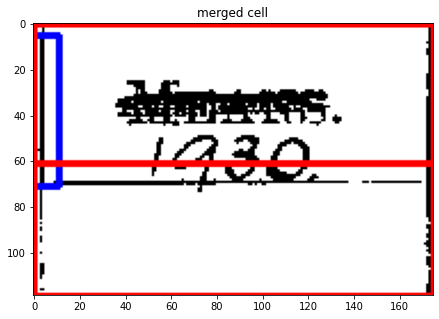

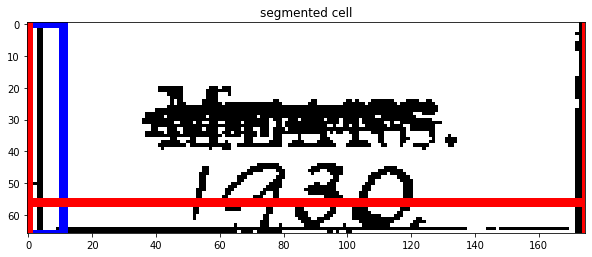

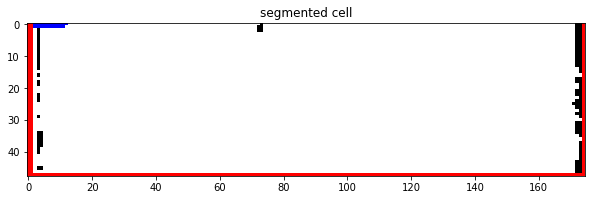

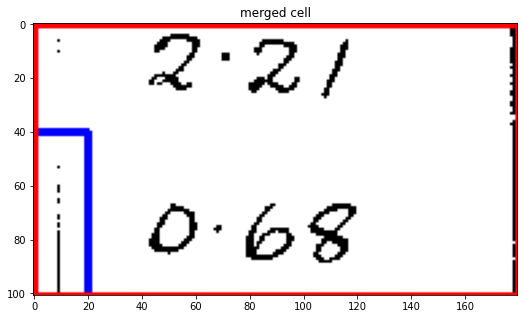

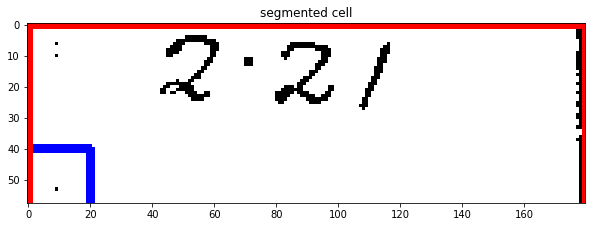

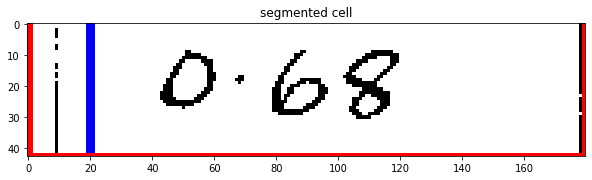

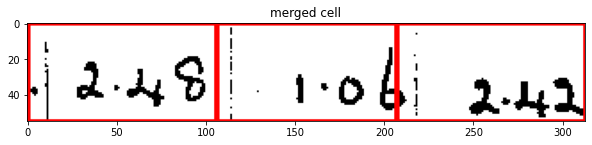

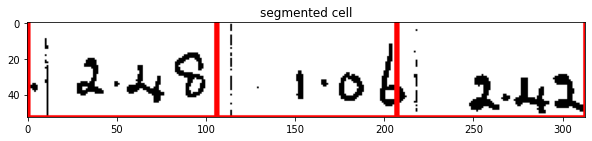

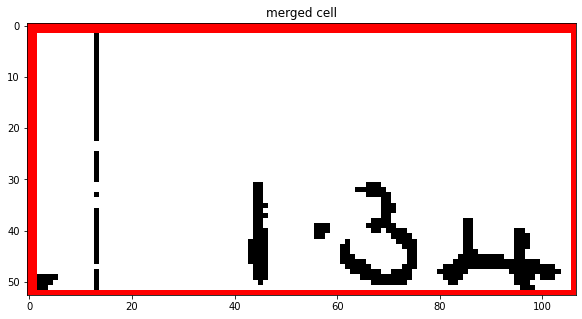

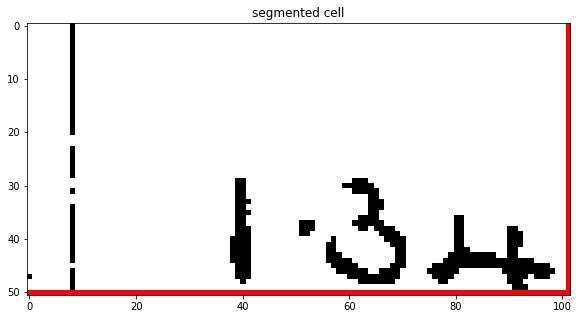

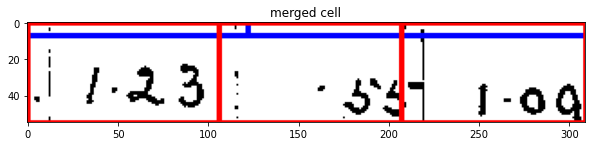

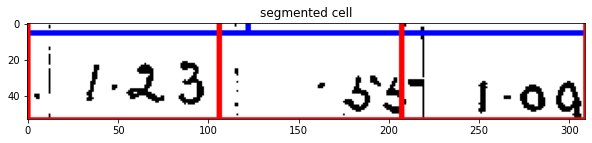

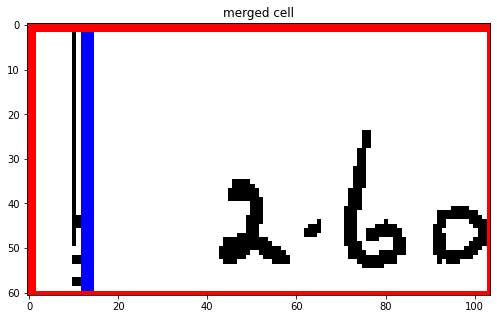

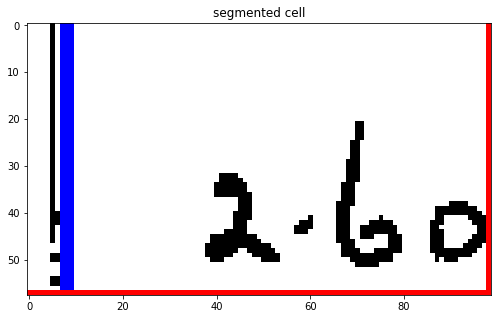

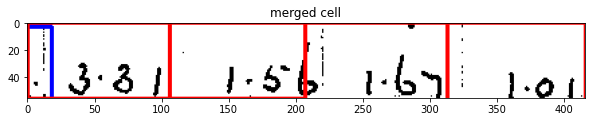

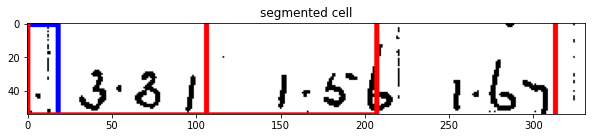

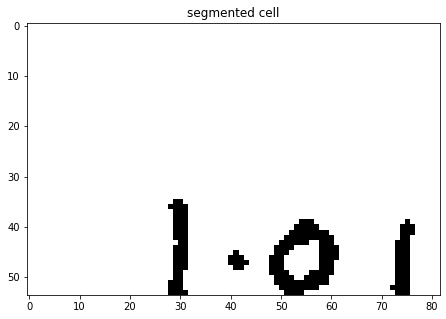

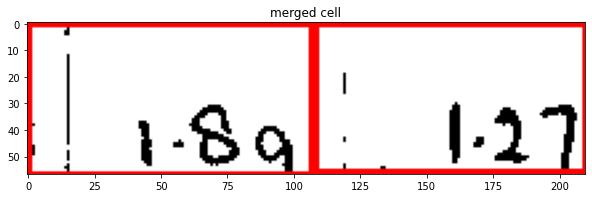

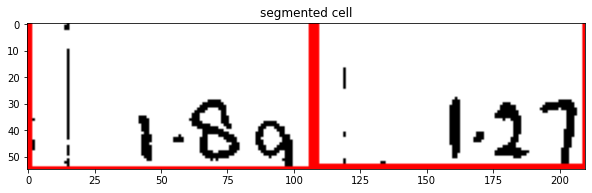

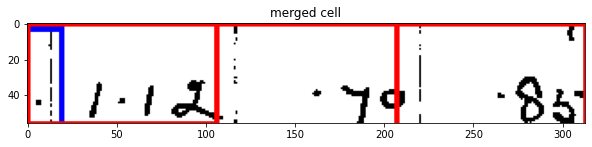

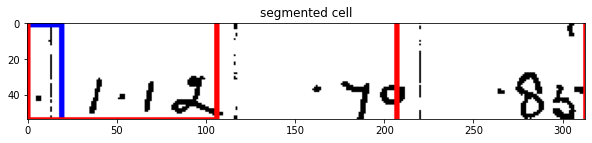

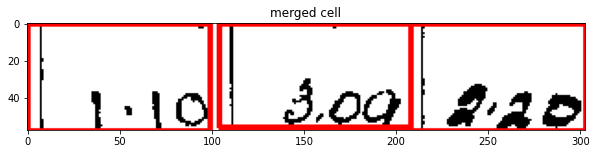

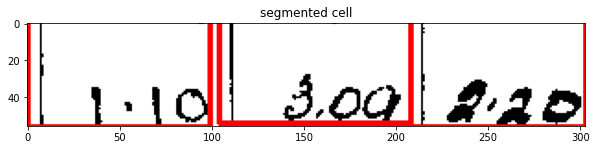

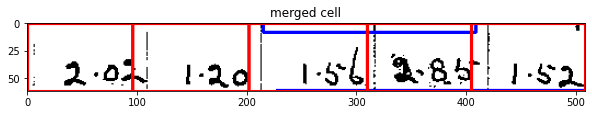

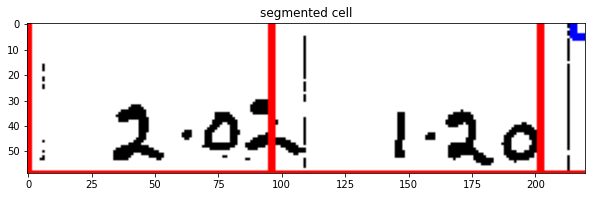

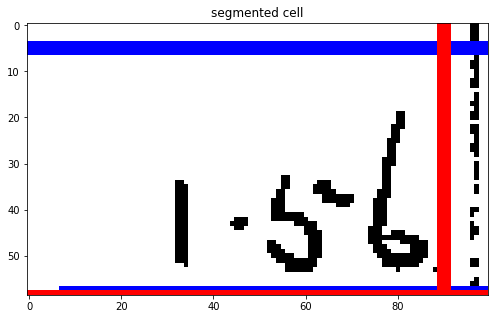

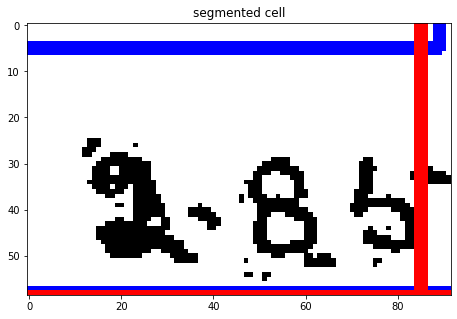

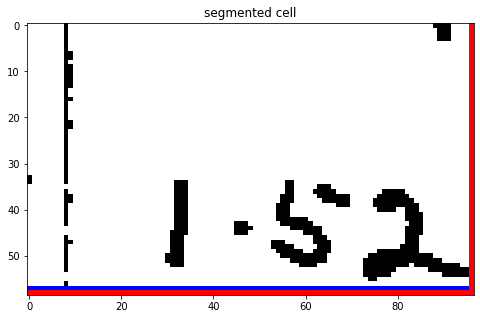

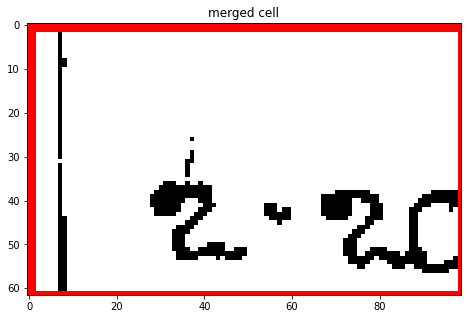

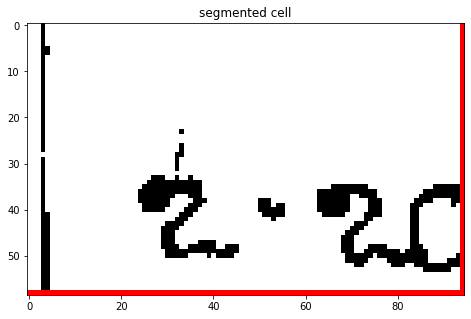

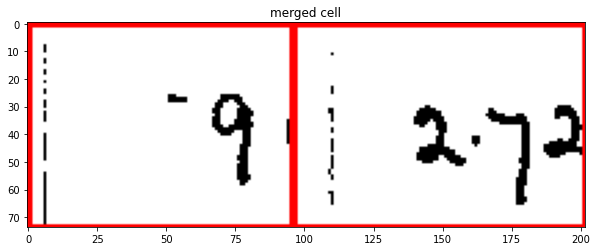

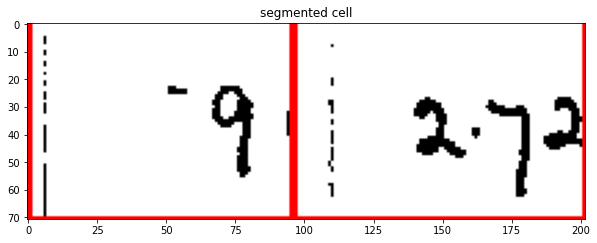

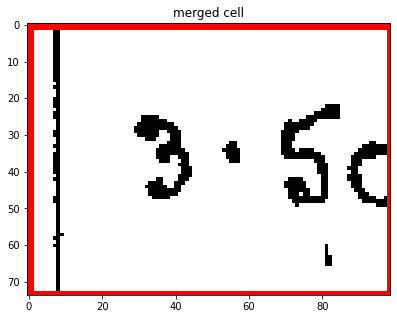

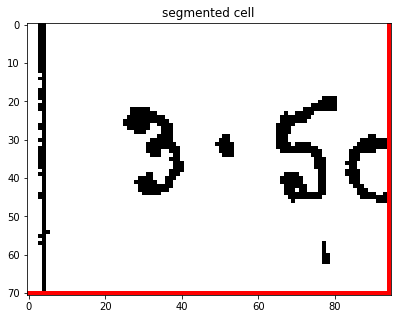

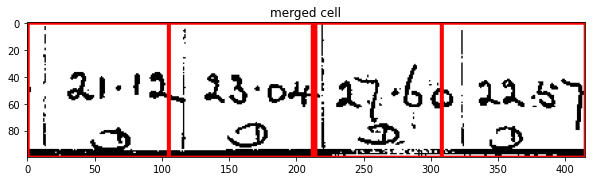

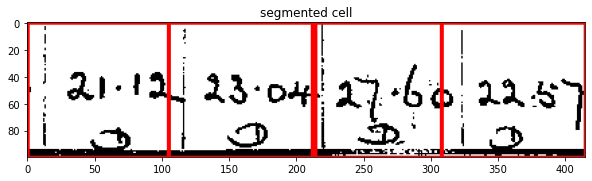

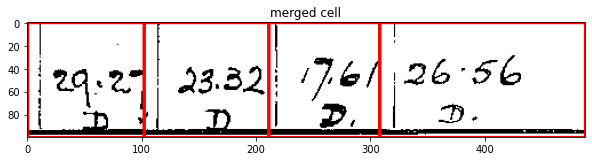

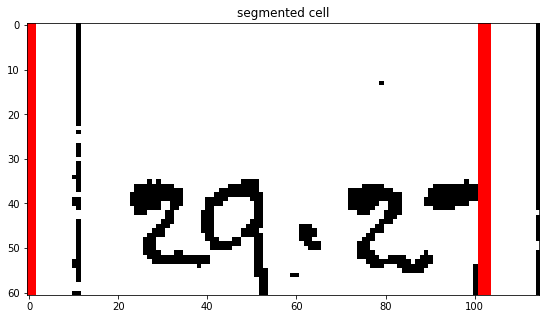

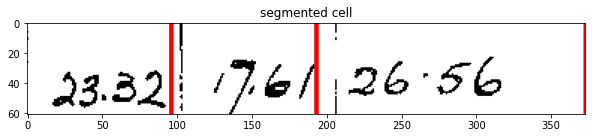

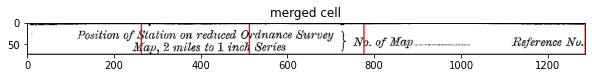

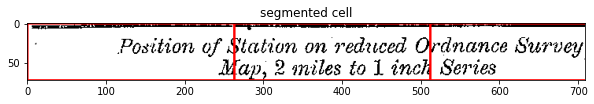

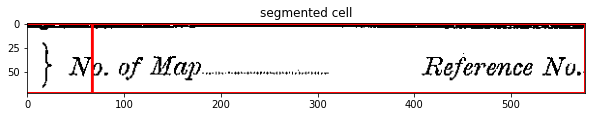

In [70]:
seg_cells = []
for cur_cell2 in merged_cells:
    croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
    plt.rcParams["figure.figsize"] = (10,5)
    plt.imshow(croppedimage_full)
    plt.title(f'merged cell')
    plt.show()  
    
    cur_corrected = segment_image(cur_cell2, masks[1], average_cordinates,tables,segmenter=0.05)
    for cur_cell in cur_corrected:
        croppedimage_full=image[int(cur_cell[1]):int(cur_cell[3]),int(cur_cell[0]):int(cur_cell[2])] 
        plt.rcParams["figure.figsize"] = (10,5)
        plt.imshow(croppedimage_full)
        plt.title(f'segmented cell')
        plt.show()  
        seg_cells.append(cur_cell)


### Filter large cells from valid cells

In [71]:
filter_considered_cells,large_cells_n =filter_overlapped_cell_final(all_valid_cells, average_cordinates)

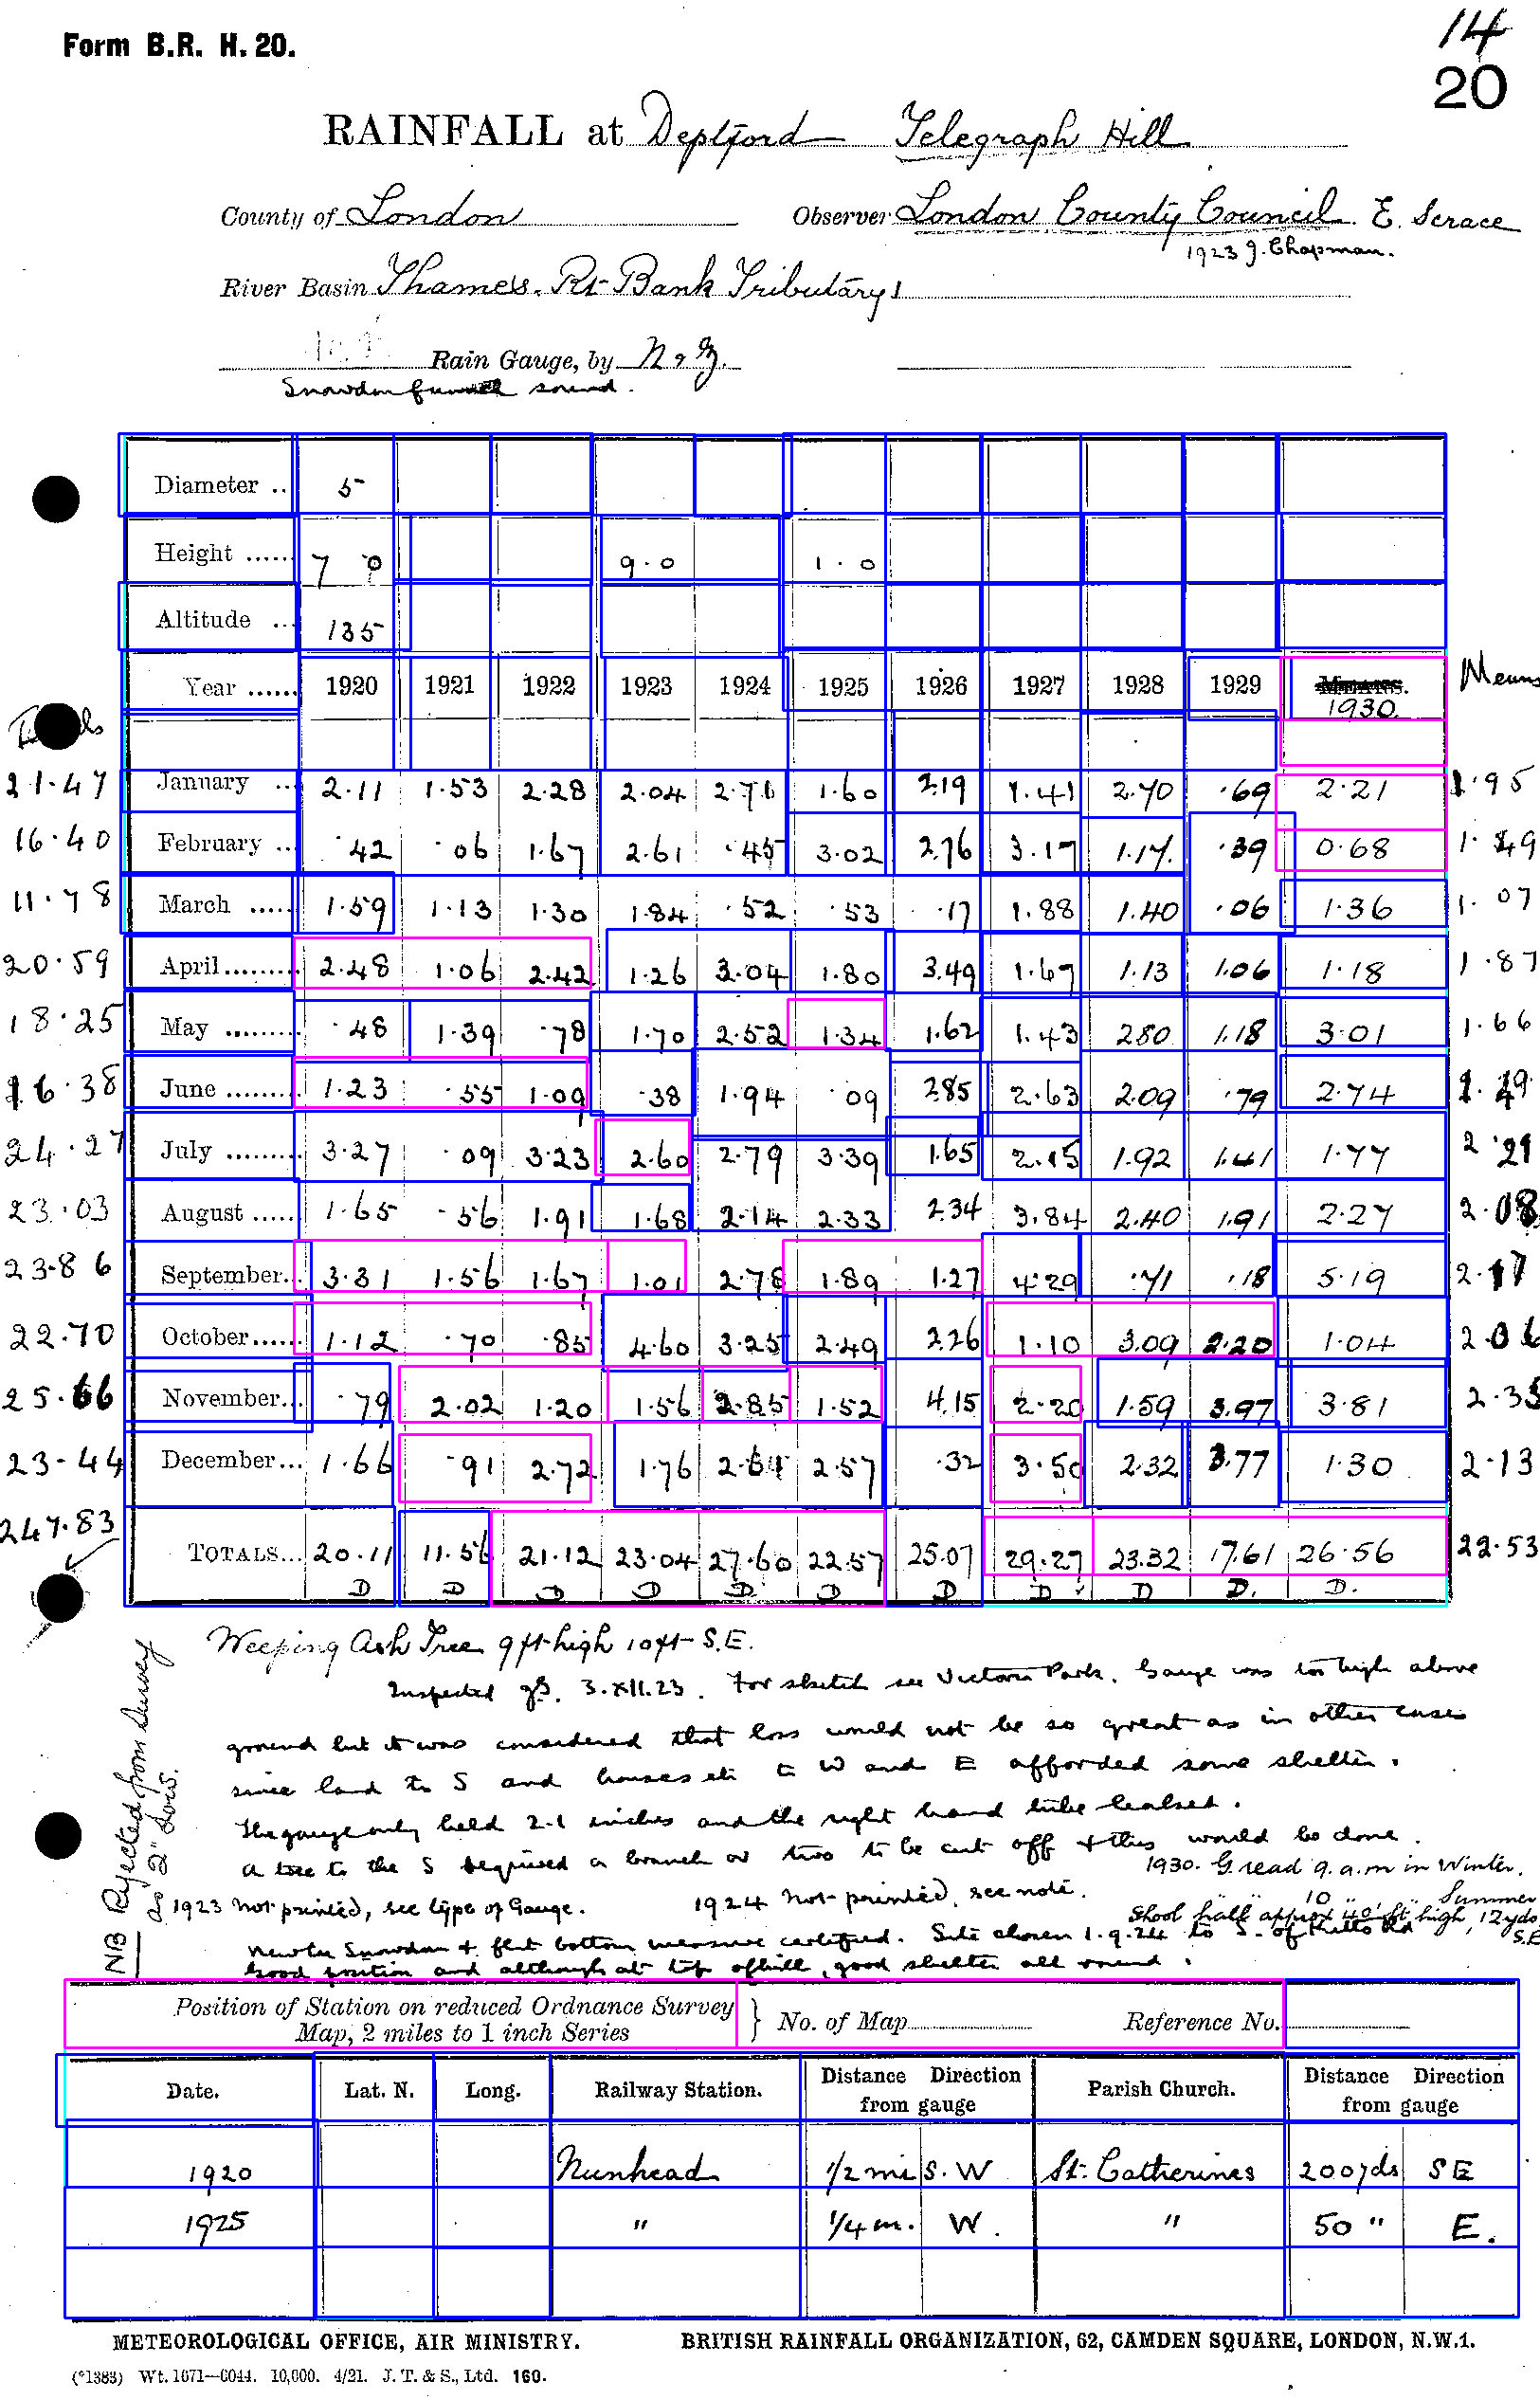

In [72]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 

for box in filter_considered_cells:
#     box = list(map(int, box[0:4]))
    put_box(image,box,(0,0,color)) # Blue
    
for box in seg_cells:
#     box = list(map(int, box[0:4]))
    put_box(image,box,(color,0,color)) # Blue

    
for box in large_cells_n:
    put_box(image,box,(color,color,0)) # Blue
    
        
# for box in exclude_cells_pred:
#     put_box(image,box,(color,0,0))  # pink


im_pil = Image.fromarray(image)
# im_pil.save(f"{outdirectory}/{filename}/13.final_considered.jpg")
im_pil

In [73]:
large_corrected = []
for cell in large_cells_n:
    large_corrected+=segment_image(cell, masks[1], average_cordinates,tables,segmenter=0.05)

In [74]:
large_corrected, filter_considered_cells = find_overlapped_cell_final(filter_considered_cells, large_corrected, average_cordinates)
seg_cells, filter_considered_cells = find_overlapped_cell_final(filter_considered_cells+large_corrected, seg_cells, average_cordinates)

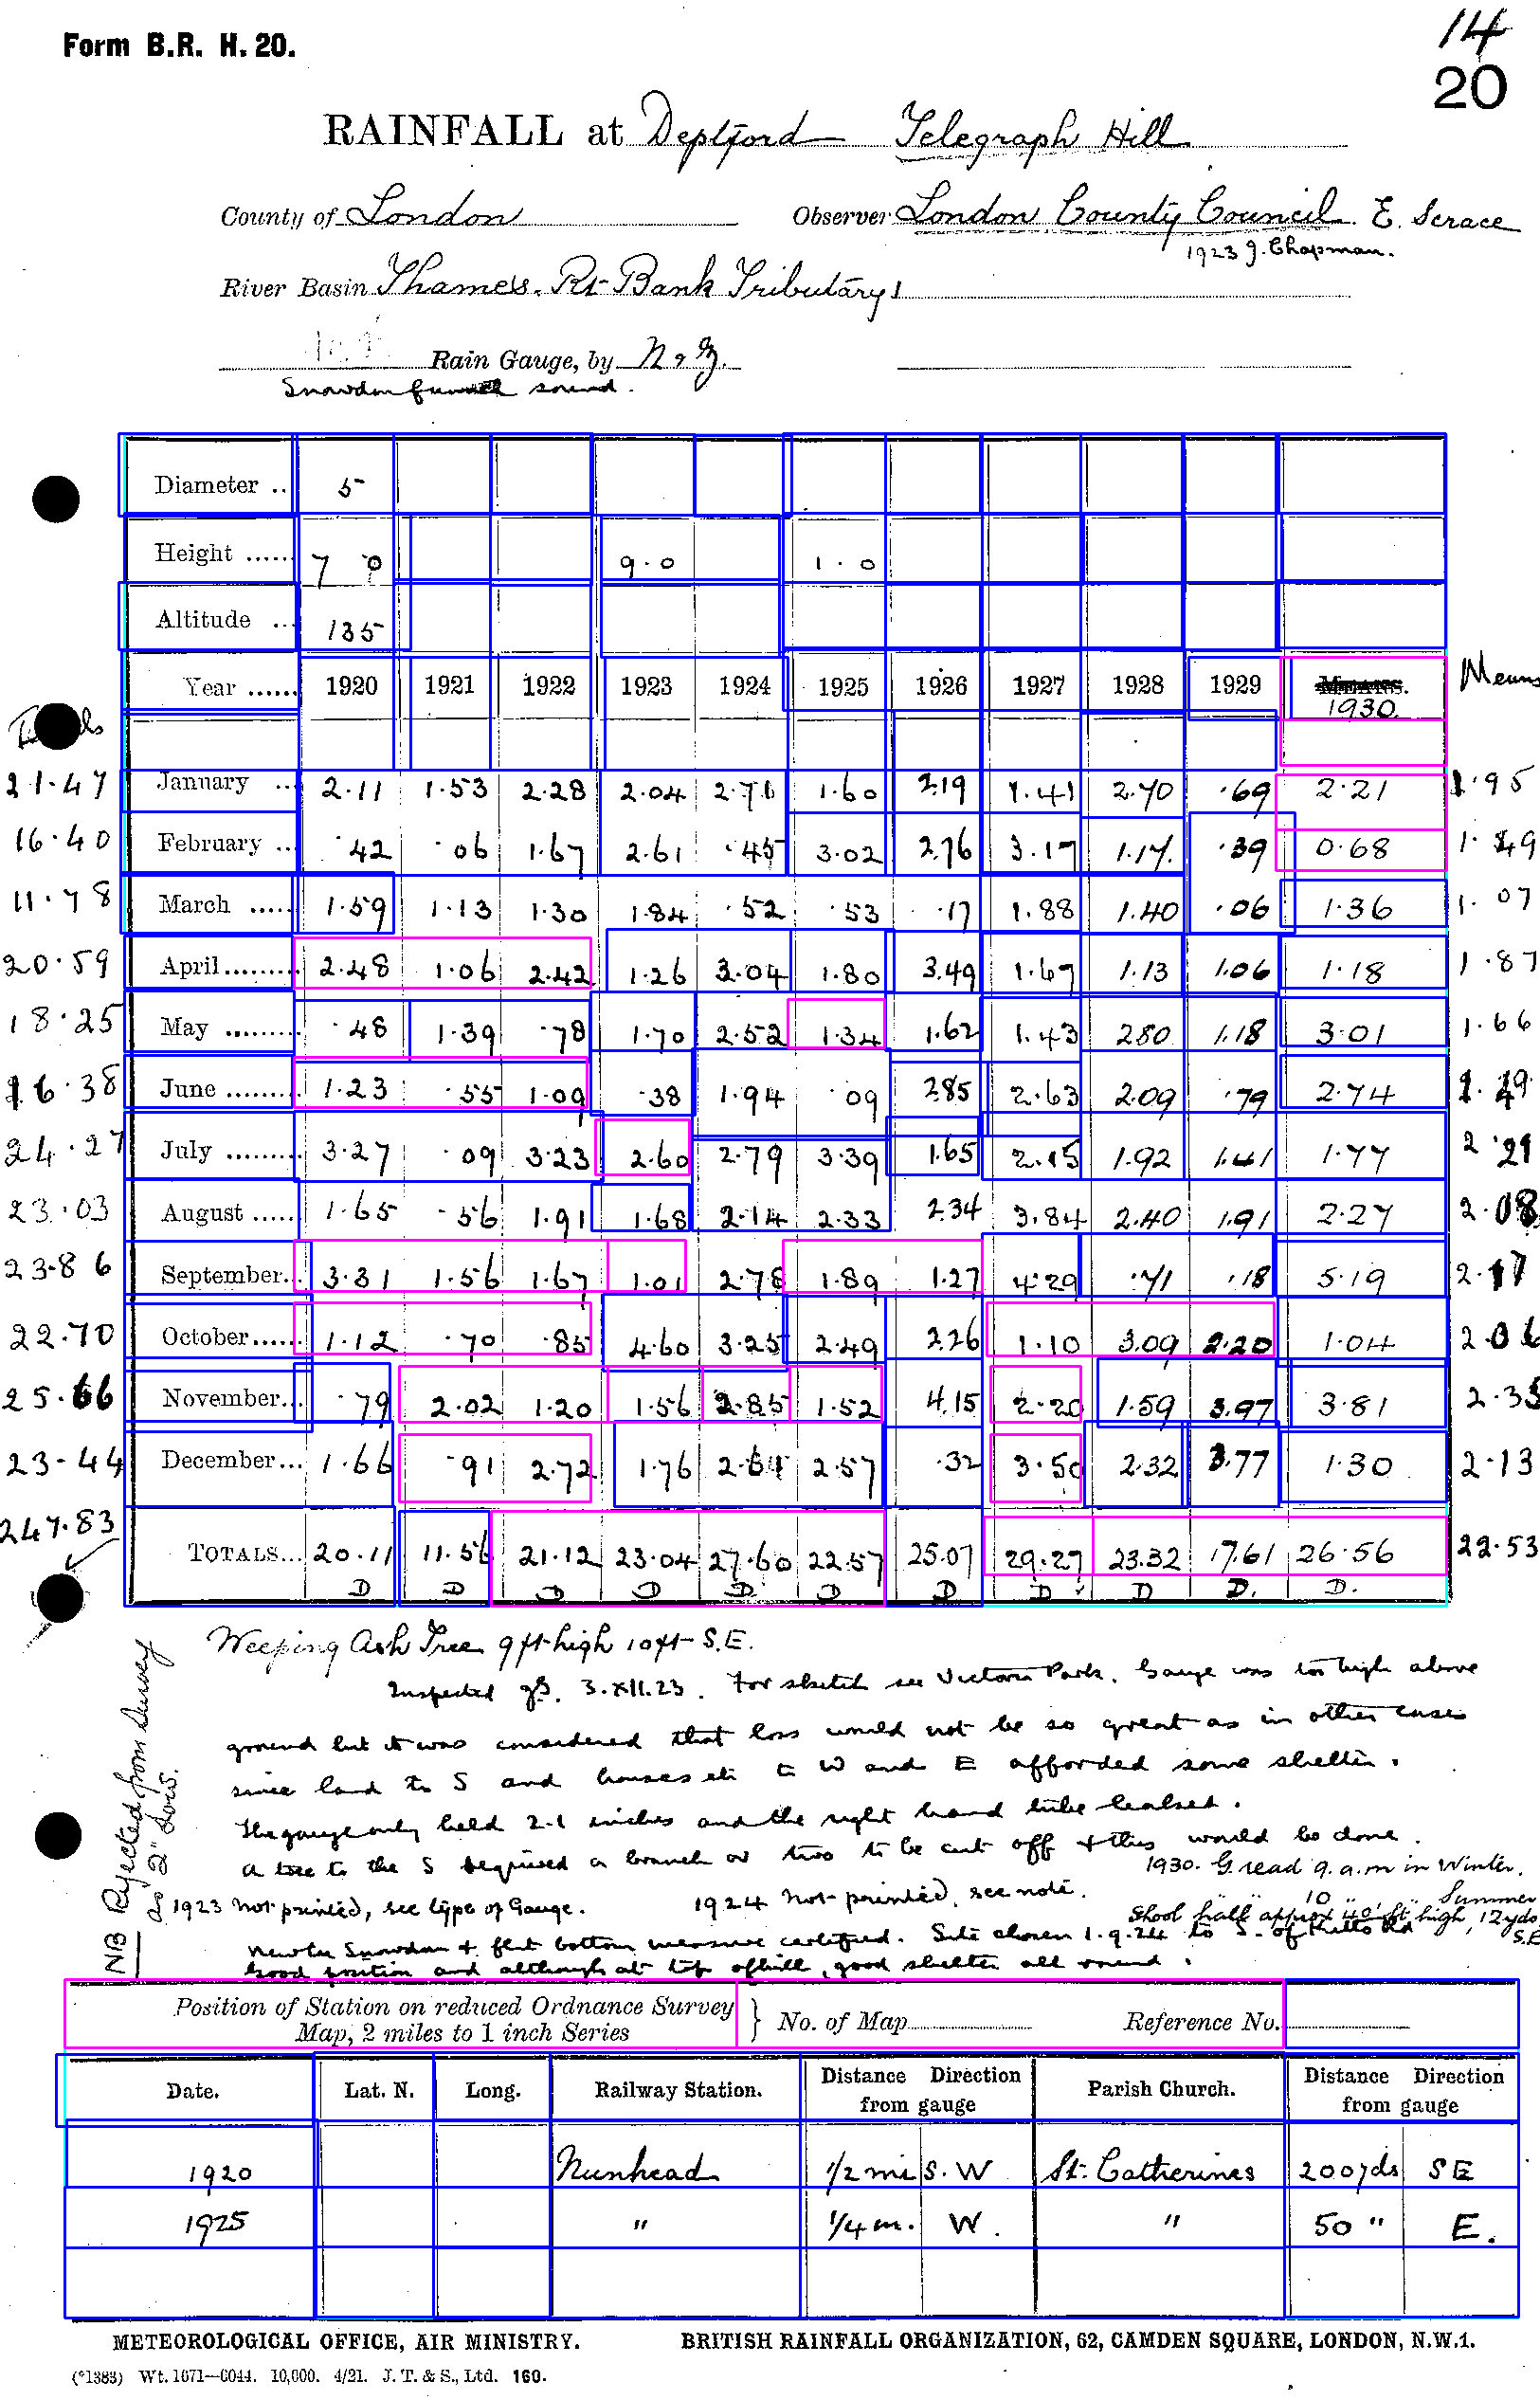

In [75]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 

for box in filter_considered_cells:
    put_box(image,box,(0,0,color)) # Blue
    
for box in large_corrected:
    put_box(image,box,(0,color,0)) # Blue
    
# for box in blank_cells_new:
#     put_box(image,box,(color,color,0)) # Blue
    
for box in seg_cells:
    put_box(image,box,(color,0,color)) # Blue
        
# for box in exclude_cells_pred:
#     put_box(image,box,(color,0,0))  # pink


im_pil = Image.fromarray(image)
im_pil.save(f"{outdirectory}/{filename}/13.final_considered.jpg")
im_pil

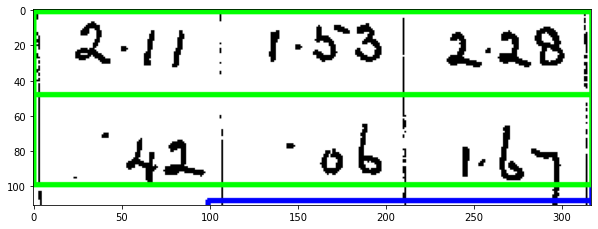

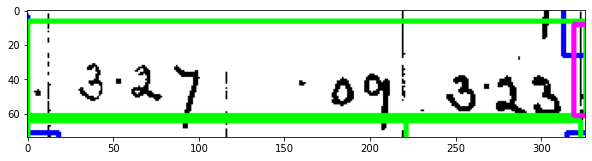

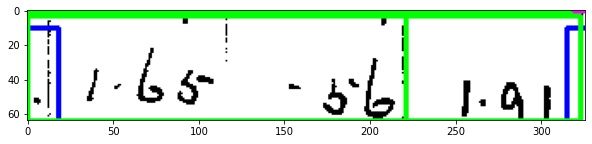

In [83]:
for cur_cell2 in large_cells_n:
    croppedimage_full=image[int(cur_cell2[1]):int(cur_cell2[3]),int(cur_cell2[0]):int(cur_cell2[2])] 
    plt.rcParams["figure.figsize"] = (10,5)
    plt.imshow(croppedimage_full)
#             plt.title(f'corrected cell of {cur_cell2} {average_cordinates[tid]}, x-dist: {abs(cur_cell2[0]-cur_cell2[2])}, y-dist: {abs(cur_cell2[1]-cur_cell2[3])}')
    plt.show()  